# 1. load data

In [1]:
import random
import numpy as np
import torch
import torch.utils.data as Data
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import pypianoroll as ppr
import pretty_midi
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

In [2]:
from vae_rnn import *

run on GPU


In [3]:
random.seed(0)

In [4]:
train_x_reduced = np.load('./../explore_data/data/train_x_drum_reduced_Electronic.npy')
print(train_x_reduced.shape)

(34452, 96, 9)


In [5]:
LR = 0.015
NUM_EPOCHS = 300
BATCH_SIZE = 256
BETA = 15.0
BEAT = 48

TESTING_RATIO = 0.05
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

In [6]:
def pltReducedDrumTrack(track, beat_resolution=12, cmap='Blues'):
    track = np.append(track, np.zeros((track.shape[0], 119)), axis=1)
    # track = np.where(track == 1, 128, 0)
    track = track * 128
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        yticklabel='number',
        beat_resolution=beat_resolution,
        cmap=cmap,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(0, 10) # C0 - C2
    y = axs.set_yticks(range(10))
    plt.show()

In [7]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

# 2. training

In [8]:
train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [9]:
encoder = Encoder().to(device)
decoder = Decoder(beat=BEAT).to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=LR)
test_err = 0

In [10]:
for epoch in range(NUM_EPOCHS):
    loss_sum = 0
    bce_sum = 0
    kld_sum = 0
    for batch_i, data in enumerate(train_loader):
        data = Variable(data[0]).type(torch.float32).to(device)
        optimizer.zero_grad()
        data_out = vae(data)
        
        loss, bce, kld = elbo(
            data_out,
            data,
            vae.z_mean,
            vae.z_sigma,
            beta=BETA
        )
        loss.backward()
        optimizer.step()

        loss_sum += loss.data.item()
        bce_sum += bce.data.item()
        kld_sum += kld.data.item()
        
        if batch_i % 5 == 0:
            print('Train Epoch: {} [{:4d}/{} ({:2.0f}%)]      Loss: {:.6f}'.format(
                epoch,
                batch_i * BATCH_SIZE,
                len(train_loader.dataset),
                100. * batch_i / len(train_loader),
                loss.data.item() / BATCH_SIZE))
            print('bce: {:.6f}, kld: {:.6f}'.format(
                bce.data.item() / BATCH_SIZE,
                kld.data.item() / BATCH_SIZE))
    print('====> Epoch: {} Average loss: {:.4f}, bce: {:.4f}, kld: {:.4f}'.format(
        epoch, loss_sum / len(train_loader.dataset),
        bce_sum / len(train_loader.dataset),
        kld_sum / len(train_loader.dataset),
    ))
#     print('Average bce: {:.4f}, kld: {:.4f}'.format(
#         bce_sum / len(train_loader.dataset),
#         kld_sum / len(train_loader.dataset)))

    
    if epoch % 5 == 0:
        loss_sum_test = 0
        for batch_i, data in enumerate(test_loader):
            with torch.no_grad():
                data = Variable(data[0]).type(torch.float32).to(device)
                data_out = vae(data)

                loss = F.binary_cross_entropy(
                    data_out,
                    data,
                    reduction='sum'
                )
                loss_sum_test += loss.item()

        print('====> Testing Average Loss: {}'.format(
            loss_sum_test / len(test_loader.dataset)))
        test_err = loss_sum_test / len(test_loader.dataset)

Train Epoch: 0 [   0/32730 ( 0%)]      Loss: 1253.533936
bce: 542.680054, kld: 47.390259
Train Epoch: 0 [1280/32730 ( 4%)]      Loss: 820.522705
bce: 513.282837, kld: 20.482658
Train Epoch: 0 [2560/32730 ( 8%)]      Loss: 663.928589
bce: 488.584381, kld: 11.689613
Train Epoch: 0 [3840/32730 (12%)]      Loss: 543.301819
bce: 464.184753, kld: 5.274472
Train Epoch: 0 [5120/32730 (16%)]      Loss: 473.010986
bce: 440.817749, kld: 2.146216
Train Epoch: 0 [6400/32730 (20%)]      Loss: 433.735931
bce: 418.958801, kld: 0.985142
Train Epoch: 0 [7680/32730 (24%)]      Loss: 406.324921
bce: 397.989502, kld: 0.555695
Train Epoch: 0 [8960/32730 (28%)]      Loss: 382.238525
bce: 376.564240, kld: 0.378287
Train Epoch: 0 [10240/32730 (31%)]      Loss: 360.432465
bce: 356.035400, kld: 0.293137
Train Epoch: 0 [11520/32730 (35%)]      Loss: 340.548401
bce: 336.980560, kld: 0.237855
Train Epoch: 0 [12800/32730 (39%)]      Loss: 322.104065
bce: 318.955231, kld: 0.209922
Train Epoch: 0 [14080/32730 (43%)]  

Train Epoch: 3 [20480/32730 (63%)]      Loss: 61.508568
bce: 58.526581, kld: 0.198799
Train Epoch: 3 [21760/32730 (67%)]      Loss: 62.447315
bce: 60.195728, kld: 0.150106
Train Epoch: 3 [23040/32730 (71%)]      Loss: 57.011410
bce: 54.603008, kld: 0.160560
Train Epoch: 3 [24320/32730 (75%)]      Loss: 58.590740
bce: 55.737877, kld: 0.190191
Train Epoch: 3 [25600/32730 (79%)]      Loss: 55.121895
bce: 52.512573, kld: 0.173955
Train Epoch: 3 [26880/32730 (83%)]      Loss: 58.135921
bce: 54.463997, kld: 0.244795
Train Epoch: 3 [28160/32730 (87%)]      Loss: 60.705952
bce: 56.335060, kld: 0.291393
Train Epoch: 3 [29440/32730 (91%)]      Loss: 57.627544
bce: 55.004780, kld: 0.174851
Train Epoch: 3 [30720/32730 (94%)]      Loss: 57.373112
bce: 54.897404, kld: 0.165047
Train Epoch: 3 [32000/32730 (98%)]      Loss: 56.281273
bce: 53.549950, kld: 0.182088
====> Epoch: 3 Average loss: 62.7544, bce: 59.6523, kld: 0.2068
Train Epoch: 4 [   0/32730 ( 0%)]      Loss: 56.163235
bce: 53.436718, kld: 

Train Epoch: 7 [6400/32730 (20%)]      Loss: 38.287361
bce: 37.604858, kld: 0.045500
Train Epoch: 7 [7680/32730 (24%)]      Loss: 40.408722
bce: 39.743595, kld: 0.044342
Train Epoch: 7 [8960/32730 (28%)]      Loss: 37.963909
bce: 37.275398, kld: 0.045901
Train Epoch: 7 [10240/32730 (31%)]      Loss: 38.117477
bce: 37.525578, kld: 0.039460
Train Epoch: 7 [11520/32730 (35%)]      Loss: 41.163551
bce: 40.615707, kld: 0.036523
Train Epoch: 7 [12800/32730 (39%)]      Loss: 38.467140
bce: 37.886913, kld: 0.038682
Train Epoch: 7 [14080/32730 (43%)]      Loss: 38.239475
bce: 37.585724, kld: 0.043583
Train Epoch: 7 [15360/32730 (47%)]      Loss: 37.394459
bce: 36.872826, kld: 0.034776
Train Epoch: 7 [16640/32730 (51%)]      Loss: 39.509766
bce: 38.752647, kld: 0.050475
Train Epoch: 7 [17920/32730 (55%)]      Loss: 37.599003
bce: 37.054638, kld: 0.036291
Train Epoch: 7 [19200/32730 (59%)]      Loss: 37.008331
bce: 36.485554, kld: 0.034852
Train Epoch: 7 [20480/32730 (63%)]      Loss: 39.094902
b

Train Epoch: 10 [26880/32730 (83%)]      Loss: 31.859493
bce: 31.584375, kld: 0.018341
Train Epoch: 10 [28160/32730 (87%)]      Loss: 26.827368
bce: 26.576401, kld: 0.016731
Train Epoch: 10 [29440/32730 (91%)]      Loss: 29.916220
bce: 29.628780, kld: 0.019163
Train Epoch: 10 [30720/32730 (94%)]      Loss: 29.328058
bce: 29.049747, kld: 0.018554
Train Epoch: 10 [32000/32730 (98%)]      Loss: 27.629293
bce: 27.319963, kld: 0.020622
====> Epoch: 10 Average loss: 29.5573, bce: 29.2466, kld: 0.0207
====> Testing Average Loss: 30.19211088351118
Train Epoch: 11 [   0/32730 ( 0%)]      Loss: 29.314512
bce: 29.049860, kld: 0.017643
Train Epoch: 11 [1280/32730 ( 4%)]      Loss: 28.268318
bce: 28.019825, kld: 0.016566
Train Epoch: 11 [2560/32730 ( 8%)]      Loss: 29.388771
bce: 29.119072, kld: 0.017980
Train Epoch: 11 [3840/32730 (12%)]      Loss: 26.933649
bce: 26.684368, kld: 0.016619
Train Epoch: 11 [5120/32730 (16%)]      Loss: 26.039595
bce: 25.788342, kld: 0.016750
Train Epoch: 11 [6400/32

Train Epoch: 14 [12800/32730 (39%)]      Loss: 22.279316
bce: 22.065039, kld: 0.014285
Train Epoch: 14 [14080/32730 (43%)]      Loss: 23.166203
bce: 22.940554, kld: 0.015043
Train Epoch: 14 [15360/32730 (47%)]      Loss: 23.285055
bce: 23.049942, kld: 0.015674
Train Epoch: 14 [16640/32730 (51%)]      Loss: 25.890898
bce: 25.651869, kld: 0.015935
Train Epoch: 14 [17920/32730 (55%)]      Loss: 25.027300
bce: 24.786587, kld: 0.016048
Train Epoch: 14 [19200/32730 (59%)]      Loss: 23.291836
bce: 23.067371, kld: 0.014964
Train Epoch: 14 [20480/32730 (63%)]      Loss: 25.313715
bce: 25.084398, kld: 0.015288
Train Epoch: 14 [21760/32730 (67%)]      Loss: 24.001421
bce: 23.771038, kld: 0.015359
Train Epoch: 14 [23040/32730 (71%)]      Loss: 24.150019
bce: 23.914391, kld: 0.015709
Train Epoch: 14 [24320/32730 (75%)]      Loss: 22.709620
bce: 22.469646, kld: 0.015998
Train Epoch: 14 [25600/32730 (79%)]      Loss: 23.212934
bce: 22.979881, kld: 0.015537
Train Epoch: 14 [26880/32730 (83%)]      Lo

Train Epoch: 17 [30720/32730 (94%)]      Loss: 20.466578
bce: 20.233646, kld: 0.015529
Train Epoch: 17 [32000/32730 (98%)]      Loss: 21.305838
bce: 21.087734, kld: 0.014540
====> Epoch: 17 Average loss: 21.4898, bce: 21.2524, kld: 0.0158
Train Epoch: 18 [   0/32730 ( 0%)]      Loss: 21.948923
bce: 21.727238, kld: 0.014779
Train Epoch: 18 [1280/32730 ( 4%)]      Loss: 21.366318
bce: 21.118202, kld: 0.016541
Train Epoch: 18 [2560/32730 ( 8%)]      Loss: 19.399649
bce: 19.149490, kld: 0.016677
Train Epoch: 18 [3840/32730 (12%)]      Loss: 20.947540
bce: 20.701288, kld: 0.016417
Train Epoch: 18 [5120/32730 (16%)]      Loss: 20.358953
bce: 20.111658, kld: 0.016486
Train Epoch: 18 [6400/32730 (20%)]      Loss: 22.374668
bce: 22.118176, kld: 0.017100
Train Epoch: 18 [7680/32730 (24%)]      Loss: 22.088707
bce: 21.847254, kld: 0.016097
Train Epoch: 18 [8960/32730 (28%)]      Loss: 21.263081
bce: 21.000084, kld: 0.017533
Train Epoch: 18 [10240/32730 (31%)]      Loss: 20.943104
bce: 20.696028, 

Train Epoch: 21 [16640/32730 (51%)]      Loss: 18.516102
bce: 18.288548, kld: 0.015170
Train Epoch: 21 [17920/32730 (55%)]      Loss: 19.646664
bce: 19.409954, kld: 0.015781
Train Epoch: 21 [19200/32730 (59%)]      Loss: 20.126974
bce: 19.895718, kld: 0.015417
Train Epoch: 21 [20480/32730 (63%)]      Loss: 17.984121
bce: 17.745836, kld: 0.015886
Train Epoch: 21 [21760/32730 (67%)]      Loss: 21.665974
bce: 21.426609, kld: 0.015958
Train Epoch: 21 [23040/32730 (71%)]      Loss: 18.207018
bce: 17.980295, kld: 0.015115
Train Epoch: 21 [24320/32730 (75%)]      Loss: 20.620014
bce: 20.377678, kld: 0.016156
Train Epoch: 21 [25600/32730 (79%)]      Loss: 18.988506
bce: 18.737217, kld: 0.016753
Train Epoch: 21 [26880/32730 (83%)]      Loss: 18.449743
bce: 18.202013, kld: 0.016515
Train Epoch: 21 [28160/32730 (87%)]      Loss: 20.199587
bce: 19.963608, kld: 0.015732
Train Epoch: 21 [29440/32730 (91%)]      Loss: 19.642818
bce: 19.405907, kld: 0.015794
Train Epoch: 21 [30720/32730 (94%)]      Lo

Train Epoch: 25 [2560/32730 ( 8%)]      Loss: 17.904247
bce: 17.650621, kld: 0.016908
Train Epoch: 25 [3840/32730 (12%)]      Loss: 17.776136
bce: 17.521755, kld: 0.016959
Train Epoch: 25 [5120/32730 (16%)]      Loss: 18.248529
bce: 17.958134, kld: 0.019360
Train Epoch: 25 [6400/32730 (20%)]      Loss: 16.291124
bce: 15.995330, kld: 0.019720
Train Epoch: 25 [7680/32730 (24%)]      Loss: 18.122772
bce: 17.821587, kld: 0.020079
Train Epoch: 25 [8960/32730 (28%)]      Loss: 19.407013
bce: 19.113371, kld: 0.019576
Train Epoch: 25 [10240/32730 (31%)]      Loss: 18.418537
bce: 18.144333, kld: 0.018280
Train Epoch: 25 [11520/32730 (35%)]      Loss: 16.668772
bce: 16.421932, kld: 0.016456
Train Epoch: 25 [12800/32730 (39%)]      Loss: 19.098000
bce: 18.865564, kld: 0.015496
Train Epoch: 25 [14080/32730 (43%)]      Loss: 17.657385
bce: 17.377596, kld: 0.018653
Train Epoch: 25 [15360/32730 (47%)]      Loss: 17.113394
bce: 16.815756, kld: 0.019843
Train Epoch: 25 [16640/32730 (51%)]      Loss: 17

Train Epoch: 28 [21760/32730 (67%)]      Loss: 17.647552
bce: 17.339037, kld: 0.020568
Train Epoch: 28 [23040/32730 (71%)]      Loss: 16.818514
bce: 16.503534, kld: 0.020999
Train Epoch: 28 [24320/32730 (75%)]      Loss: 17.078026
bce: 16.761662, kld: 0.021091
Train Epoch: 28 [25600/32730 (79%)]      Loss: 16.604160
bce: 16.303986, kld: 0.020012
Train Epoch: 28 [26880/32730 (83%)]      Loss: 17.527685
bce: 17.247545, kld: 0.018676
Train Epoch: 28 [28160/32730 (87%)]      Loss: 14.670451
bce: 14.379317, kld: 0.019409
Train Epoch: 28 [29440/32730 (91%)]      Loss: 16.448298
bce: 16.117542, kld: 0.022050
Train Epoch: 28 [30720/32730 (94%)]      Loss: 17.483509
bce: 17.181271, kld: 0.020149
Train Epoch: 28 [32000/32730 (98%)]      Loss: 15.640095
bce: 15.360767, kld: 0.018622
====> Epoch: 28 Average loss: 16.5219, bce: 16.2301, kld: 0.0195
Train Epoch: 29 [   0/32730 ( 0%)]      Loss: 16.773714
bce: 16.482119, kld: 0.019440
Train Epoch: 29 [1280/32730 ( 4%)]      Loss: 16.257158
bce: 15.95

Train Epoch: 32 [5120/32730 (16%)]      Loss: 15.674487
bce: 15.415492, kld: 0.017266
Train Epoch: 32 [6400/32730 (20%)]      Loss: 15.069061
bce: 14.808357, kld: 0.017380
Train Epoch: 32 [7680/32730 (24%)]      Loss: 16.126741
bce: 15.853095, kld: 0.018243
Train Epoch: 32 [8960/32730 (28%)]      Loss: 15.205809
bce: 14.919861, kld: 0.019063
Train Epoch: 32 [10240/32730 (31%)]      Loss: 15.378620
bce: 15.085012, kld: 0.019574
Train Epoch: 32 [11520/32730 (35%)]      Loss: 15.080697
bce: 14.777819, kld: 0.020192
Train Epoch: 32 [12800/32730 (39%)]      Loss: 16.341007
bce: 16.023596, kld: 0.021161
Train Epoch: 32 [14080/32730 (43%)]      Loss: 14.165345
bce: 13.870023, kld: 0.019688
Train Epoch: 32 [15360/32730 (47%)]      Loss: 16.670391
bce: 16.356152, kld: 0.020949
Train Epoch: 32 [16640/32730 (51%)]      Loss: 14.763423
bce: 14.487922, kld: 0.018367
Train Epoch: 32 [17920/32730 (55%)]      Loss: 15.503040
bce: 15.214445, kld: 0.019240
Train Epoch: 32 [19200/32730 (59%)]      Loss: 

Train Epoch: 35 [24320/32730 (75%)]      Loss: 15.504265
bce: 15.211868, kld: 0.019493
Train Epoch: 35 [25600/32730 (79%)]      Loss: 15.319351
bce: 15.012762, kld: 0.020439
Train Epoch: 35 [26880/32730 (83%)]      Loss: 14.415670
bce: 14.115570, kld: 0.020007
Train Epoch: 35 [28160/32730 (87%)]      Loss: 14.085376
bce: 13.786095, kld: 0.019952
Train Epoch: 35 [29440/32730 (91%)]      Loss: 13.429243
bce: 13.132860, kld: 0.019759
Train Epoch: 35 [30720/32730 (94%)]      Loss: 14.856894
bce: 14.569221, kld: 0.019178
Train Epoch: 35 [32000/32730 (98%)]      Loss: 13.969119
bce: 13.698075, kld: 0.018070
====> Epoch: 35 Average loss: 14.8582, bce: 14.5763, kld: 0.0188
====> Testing Average Loss: 23.7378352184052
Train Epoch: 36 [   0/32730 ( 0%)]      Loss: 13.895892
bce: 13.633301, kld: 0.017506
Train Epoch: 36 [1280/32730 ( 4%)]      Loss: 15.942538
bce: 15.671715, kld: 0.018055
Train Epoch: 36 [2560/32730 ( 8%)]      Loss: 15.863946
bce: 15.573126, kld: 0.019388
Train Epoch: 36 [3840/3

Train Epoch: 39 [10240/32730 (31%)]      Loss: 14.480742
bce: 14.171232, kld: 0.020634
Train Epoch: 39 [11520/32730 (35%)]      Loss: 16.289658
bce: 15.957350, kld: 0.022154
Train Epoch: 39 [12800/32730 (39%)]      Loss: 17.451767
bce: 17.122673, kld: 0.021940
Train Epoch: 39 [14080/32730 (43%)]      Loss: 14.991280
bce: 14.669933, kld: 0.021423
Train Epoch: 39 [15360/32730 (47%)]      Loss: 14.091166
bce: 13.759046, kld: 0.022141
Train Epoch: 39 [16640/32730 (51%)]      Loss: 15.769217
bce: 15.452703, kld: 0.021101
Train Epoch: 39 [17920/32730 (55%)]      Loss: 16.943893
bce: 16.620317, kld: 0.021572
Train Epoch: 39 [19200/32730 (59%)]      Loss: 15.669299
bce: 15.340981, kld: 0.021888
Train Epoch: 39 [20480/32730 (63%)]      Loss: 16.629295
bce: 16.316065, kld: 0.020882
Train Epoch: 39 [21760/32730 (67%)]      Loss: 15.782674
bce: 15.475950, kld: 0.020448
Train Epoch: 39 [23040/32730 (71%)]      Loss: 14.443792
bce: 14.139000, kld: 0.020319
Train Epoch: 39 [24320/32730 (75%)]      Lo

Train Epoch: 42 [28160/32730 (87%)]      Loss: 15.101887
bce: 14.790280, kld: 0.020774
Train Epoch: 42 [29440/32730 (91%)]      Loss: 15.371351
bce: 15.060881, kld: 0.020698
Train Epoch: 42 [30720/32730 (94%)]      Loss: 12.548779
bce: 12.216713, kld: 0.022138
Train Epoch: 42 [32000/32730 (98%)]      Loss: 14.103102
bce: 13.783371, kld: 0.021315
====> Epoch: 42 Average loss: 14.5423, bce: 14.2435, kld: 0.0199
Train Epoch: 43 [   0/32730 ( 0%)]      Loss: 15.245219
bce: 14.928734, kld: 0.021099
Train Epoch: 43 [1280/32730 ( 4%)]      Loss: 13.762383
bce: 13.468299, kld: 0.019606
Train Epoch: 43 [2560/32730 ( 8%)]      Loss: 14.704572
bce: 14.420177, kld: 0.018960
Train Epoch: 43 [3840/32730 (12%)]      Loss: 13.493423
bce: 13.199371, kld: 0.019603
Train Epoch: 43 [5120/32730 (16%)]      Loss: 13.913778
bce: 13.601285, kld: 0.020833
Train Epoch: 43 [6400/32730 (20%)]      Loss: 14.176148
bce: 13.845634, kld: 0.022034
Train Epoch: 43 [7680/32730 (24%)]      Loss: 15.116652
bce: 14.802602,

bce: 13.464477, kld: 0.021553
Train Epoch: 46 [15360/32730 (47%)]      Loss: 14.142160
bce: 13.840429, kld: 0.020115
Train Epoch: 46 [16640/32730 (51%)]      Loss: 14.035881
bce: 13.754892, kld: 0.018733
Train Epoch: 46 [17920/32730 (55%)]      Loss: 14.043196
bce: 13.746426, kld: 0.019785
Train Epoch: 46 [19200/32730 (59%)]      Loss: 13.484084
bce: 13.153667, kld: 0.022028
Train Epoch: 46 [20480/32730 (63%)]      Loss: 13.154622
bce: 12.777832, kld: 0.025119
Train Epoch: 46 [21760/32730 (67%)]      Loss: 12.922652
bce: 12.522841, kld: 0.026654
Train Epoch: 46 [23040/32730 (71%)]      Loss: 13.354420
bce: 12.977480, kld: 0.025129
Train Epoch: 46 [24320/32730 (75%)]      Loss: 14.310343
bce: 13.969589, kld: 0.022717
Train Epoch: 46 [25600/32730 (79%)]      Loss: 14.092836
bce: 13.795530, kld: 0.019820
Train Epoch: 46 [26880/32730 (83%)]      Loss: 13.431572
bce: 13.158215, kld: 0.018224
Train Epoch: 46 [28160/32730 (87%)]      Loss: 15.721131
bce: 15.454389, kld: 0.017783
Train Epoch: 

Train Epoch: 50 [   0/32730 ( 0%)]      Loss: 14.096263
bce: 13.780098, kld: 0.021078
Train Epoch: 50 [1280/32730 ( 4%)]      Loss: 14.514450
bce: 14.200579, kld: 0.020925
Train Epoch: 50 [2560/32730 ( 8%)]      Loss: 14.477588
bce: 14.159209, kld: 0.021225
Train Epoch: 50 [3840/32730 (12%)]      Loss: 14.446476
bce: 14.139340, kld: 0.020476
Train Epoch: 50 [5120/32730 (16%)]      Loss: 14.136395
bce: 13.816940, kld: 0.021297
Train Epoch: 50 [6400/32730 (20%)]      Loss: 13.386550
bce: 13.074733, kld: 0.020788
Train Epoch: 50 [7680/32730 (24%)]      Loss: 14.037936
bce: 13.723864, kld: 0.020938
Train Epoch: 50 [8960/32730 (28%)]      Loss: 13.106803
bce: 12.794291, kld: 0.020834
Train Epoch: 50 [10240/32730 (31%)]      Loss: 15.334392
bce: 15.035992, kld: 0.019893
Train Epoch: 50 [11520/32730 (35%)]      Loss: 13.459942
bce: 13.151734, kld: 0.020547
Train Epoch: 50 [12800/32730 (39%)]      Loss: 14.230296
bce: 13.903336, kld: 0.021797
Train Epoch: 50 [14080/32730 (43%)]      Loss: 14.8

Train Epoch: 53 [17920/32730 (55%)]      Loss: 15.487993
bce: 15.174434, kld: 0.020904
Train Epoch: 53 [19200/32730 (59%)]      Loss: 13.517444
bce: 13.182671, kld: 0.022318
Train Epoch: 53 [20480/32730 (63%)]      Loss: 14.082110
bce: 13.745886, kld: 0.022415
Train Epoch: 53 [21760/32730 (67%)]      Loss: 13.269354
bce: 12.932258, kld: 0.022473
Train Epoch: 53 [23040/32730 (71%)]      Loss: 13.281403
bce: 12.961136, kld: 0.021351
Train Epoch: 53 [24320/32730 (75%)]      Loss: 12.887097
bce: 12.589435, kld: 0.019844
Train Epoch: 53 [25600/32730 (79%)]      Loss: 13.117224
bce: 12.839750, kld: 0.018498
Train Epoch: 53 [26880/32730 (83%)]      Loss: 12.910078
bce: 12.643404, kld: 0.017778
Train Epoch: 53 [28160/32730 (87%)]      Loss: 13.227261
bce: 12.962799, kld: 0.017631
Train Epoch: 53 [29440/32730 (91%)]      Loss: 13.839686
bce: 13.553311, kld: 0.019092
Train Epoch: 53 [30720/32730 (94%)]      Loss: 14.009356
bce: 13.693480, kld: 0.021058
Train Epoch: 53 [32000/32730 (98%)]      Lo

Train Epoch: 57 [1280/32730 ( 4%)]      Loss: 12.723835
bce: 12.361562, kld: 0.024152
Train Epoch: 57 [2560/32730 ( 8%)]      Loss: 14.318287
bce: 13.941378, kld: 0.025127
Train Epoch: 57 [3840/32730 (12%)]      Loss: 13.996325
bce: 13.619381, kld: 0.025130
Train Epoch: 57 [5120/32730 (16%)]      Loss: 13.702202
bce: 13.344399, kld: 0.023853
Train Epoch: 57 [6400/32730 (20%)]      Loss: 13.206691
bce: 12.859776, kld: 0.023128
Train Epoch: 57 [7680/32730 (24%)]      Loss: 12.946025
bce: 12.607117, kld: 0.022594
Train Epoch: 57 [8960/32730 (28%)]      Loss: 14.180958
bce: 13.849732, kld: 0.022082
Train Epoch: 57 [10240/32730 (31%)]      Loss: 14.011132
bce: 13.667476, kld: 0.022910
Train Epoch: 57 [11520/32730 (35%)]      Loss: 12.917101
bce: 12.579922, kld: 0.022479
Train Epoch: 57 [12800/32730 (39%)]      Loss: 14.351991
bce: 13.988542, kld: 0.024230
Train Epoch: 57 [14080/32730 (43%)]      Loss: 13.881709
bce: 13.494709, kld: 0.025800
Train Epoch: 57 [15360/32730 (47%)]      Loss: 15.

bce: 13.362188, kld: 0.022229
Train Epoch: 60 [21760/32730 (67%)]      Loss: 13.420082
bce: 13.066783, kld: 0.023553
Train Epoch: 60 [23040/32730 (71%)]      Loss: 14.625816
bce: 14.252531, kld: 0.024886
Train Epoch: 60 [24320/32730 (75%)]      Loss: 13.180703
bce: 12.788769, kld: 0.026129
Train Epoch: 60 [25600/32730 (79%)]      Loss: 16.605507
bce: 16.191126, kld: 0.027625
Train Epoch: 60 [26880/32730 (83%)]      Loss: 14.692399
bce: 14.267873, kld: 0.028302
Train Epoch: 60 [28160/32730 (87%)]      Loss: 14.656771
bce: 14.278296, kld: 0.025232
Train Epoch: 60 [29440/32730 (91%)]      Loss: 12.684971
bce: 12.369311, kld: 0.021044
Train Epoch: 60 [30720/32730 (94%)]      Loss: 15.106186
bce: 14.803768, kld: 0.020161
Train Epoch: 60 [32000/32730 (98%)]      Loss: 15.507290
bce: 15.218554, kld: 0.019249
====> Epoch: 60 Average loss: 13.7884, bce: 13.4517, kld: 0.0224
====> Testing Average Loss: 27.01740118684669
Train Epoch: 61 [   0/32730 ( 0%)]      Loss: 15.898127
bce: 15.583565, kld:

Train Epoch: 64 [5120/32730 (16%)]      Loss: 14.614697
bce: 14.253489, kld: 0.024081
Train Epoch: 64 [6400/32730 (20%)]      Loss: 12.220720
bce: 11.850531, kld: 0.024679
Train Epoch: 64 [7680/32730 (24%)]      Loss: 12.422582
bce: 12.061462, kld: 0.024075
Train Epoch: 64 [8960/32730 (28%)]      Loss: 14.828295
bce: 14.450370, kld: 0.025195
Train Epoch: 64 [10240/32730 (31%)]      Loss: 14.949735
bce: 14.589998, kld: 0.023982
Train Epoch: 64 [11520/32730 (35%)]      Loss: 13.961436
bce: 13.586470, kld: 0.024998
Train Epoch: 64 [12800/32730 (39%)]      Loss: 12.966059
bce: 12.627769, kld: 0.022553
Train Epoch: 64 [14080/32730 (43%)]      Loss: 14.235520
bce: 13.859794, kld: 0.025048
Train Epoch: 64 [15360/32730 (47%)]      Loss: 13.895718
bce: 13.503374, kld: 0.026156
Train Epoch: 64 [16640/32730 (51%)]      Loss: 12.926277
bce: 12.525581, kld: 0.026713
Train Epoch: 64 [17920/32730 (55%)]      Loss: 13.282207
bce: 12.894420, kld: 0.025852
Train Epoch: 64 [19200/32730 (59%)]      Loss: 

Train Epoch: 67 [25600/32730 (79%)]      Loss: 12.980424
bce: 12.572830, kld: 0.027173
Train Epoch: 67 [26880/32730 (83%)]      Loss: 14.326928
bce: 13.948233, kld: 0.025246
Train Epoch: 67 [28160/32730 (87%)]      Loss: 13.032089
bce: 12.692108, kld: 0.022665
Train Epoch: 67 [29440/32730 (91%)]      Loss: 14.464580
bce: 14.152863, kld: 0.020781
Train Epoch: 67 [30720/32730 (94%)]      Loss: 14.072429
bce: 13.698304, kld: 0.024942
Train Epoch: 67 [32000/32730 (98%)]      Loss: 14.181564
bce: 13.763297, kld: 0.027885
====> Epoch: 67 Average loss: 13.6534, bce: 13.2844, kld: 0.0246
Train Epoch: 68 [   0/32730 ( 0%)]      Loss: 14.580753
bce: 14.141141, kld: 0.029307
Train Epoch: 68 [1280/32730 ( 4%)]      Loss: 13.468014
bce: 13.036479, kld: 0.028769
Train Epoch: 68 [2560/32730 ( 8%)]      Loss: 13.872422
bce: 13.465715, kld: 0.027114
Train Epoch: 68 [3840/32730 (12%)]      Loss: 13.456602
bce: 13.105677, kld: 0.023395
Train Epoch: 68 [5120/32730 (16%)]      Loss: 11.978526
bce: 11.65853

Train Epoch: 71 [8960/32730 (28%)]      Loss: 12.338274
bce: 12.049046, kld: 0.019282
Train Epoch: 71 [10240/32730 (31%)]      Loss: 13.385670
bce: 13.097139, kld: 0.019235
Train Epoch: 71 [11520/32730 (35%)]      Loss: 13.539775
bce: 13.195272, kld: 0.022967
Train Epoch: 71 [12800/32730 (39%)]      Loss: 14.269648
bce: 13.879284, kld: 0.026024
Train Epoch: 71 [14080/32730 (43%)]      Loss: 12.969956
bce: 12.551838, kld: 0.027875
Train Epoch: 71 [15360/32730 (47%)]      Loss: 13.782714
bce: 13.405982, kld: 0.025115
Train Epoch: 71 [16640/32730 (51%)]      Loss: 12.904741
bce: 12.560993, kld: 0.022917
Train Epoch: 71 [17920/32730 (55%)]      Loss: 13.002632
bce: 12.655875, kld: 0.023117
Train Epoch: 71 [19200/32730 (59%)]      Loss: 12.348851
bce: 12.013748, kld: 0.022340
Train Epoch: 71 [20480/32730 (63%)]      Loss: 13.057501
bce: 12.705040, kld: 0.023497
Train Epoch: 71 [21760/32730 (67%)]      Loss: 12.843433
bce: 12.459883, kld: 0.025570
Train Epoch: 71 [23040/32730 (71%)]      Los

Train Epoch: 74 [29440/32730 (91%)]      Loss: 14.088778
bce: 13.637436, kld: 0.030090
Train Epoch: 74 [30720/32730 (94%)]      Loss: 14.430571
bce: 13.983352, kld: 0.029815
Train Epoch: 74 [32000/32730 (98%)]      Loss: 15.622288
bce: 14.958839, kld: 0.044230
====> Epoch: 74 Average loss: 14.1860, bce: 13.7319, kld: 0.0303
Train Epoch: 75 [   0/32730 ( 0%)]      Loss: 15.178578
bce: 14.513270, kld: 0.044354
Train Epoch: 75 [1280/32730 ( 4%)]      Loss: 14.496745
bce: 13.914510, kld: 0.038816
Train Epoch: 75 [2560/32730 ( 8%)]      Loss: 12.276420
bce: 11.720993, kld: 0.037028
Train Epoch: 75 [3840/32730 (12%)]      Loss: 16.129330
bce: 15.602660, kld: 0.035111
Train Epoch: 75 [5120/32730 (16%)]      Loss: 14.352552
bce: 13.903688, kld: 0.029924
Train Epoch: 75 [6400/32730 (20%)]      Loss: 13.235092
bce: 12.850920, kld: 0.025611
Train Epoch: 75 [7680/32730 (24%)]      Loss: 13.282889
bce: 12.904758, kld: 0.025209
Train Epoch: 75 [8960/32730 (28%)]      Loss: 13.918900
bce: 13.501858, 

Train Epoch: 78 [14080/32730 (43%)]      Loss: 16.399742
bce: 15.952032, kld: 0.029847
Train Epoch: 78 [15360/32730 (47%)]      Loss: 14.286367
bce: 13.835817, kld: 0.030037
Train Epoch: 78 [16640/32730 (51%)]      Loss: 13.766218
bce: 13.318592, kld: 0.029842
Train Epoch: 78 [17920/32730 (55%)]      Loss: 15.612032
bce: 15.186914, kld: 0.028341
Train Epoch: 78 [19200/32730 (59%)]      Loss: 15.498449
bce: 15.102163, kld: 0.026419
Train Epoch: 78 [20480/32730 (63%)]      Loss: 15.509191
bce: 15.135835, kld: 0.024890
Train Epoch: 78 [21760/32730 (67%)]      Loss: 14.200520
bce: 13.592471, kld: 0.040537
Train Epoch: 78 [23040/32730 (71%)]      Loss: 14.249648
bce: 13.554991, kld: 0.046310
Train Epoch: 78 [24320/32730 (75%)]      Loss: 15.097897
bce: 14.477397, kld: 0.041367
Train Epoch: 78 [25600/32730 (79%)]      Loss: 13.904462
bce: 13.444954, kld: 0.030634
Train Epoch: 78 [26880/32730 (83%)]      Loss: 11.443394
bce: 11.123116, kld: 0.021352
Train Epoch: 78 [28160/32730 (87%)]      Lo

Train Epoch: 81 [32000/32730 (98%)]      Loss: 12.901048
bce: 12.554402, kld: 0.023110
====> Epoch: 81 Average loss: 13.5467, bce: 13.1760, kld: 0.0247
Train Epoch: 82 [   0/32730 ( 0%)]      Loss: 13.352620
bce: 12.995628, kld: 0.023799
Train Epoch: 82 [1280/32730 ( 4%)]      Loss: 12.366281
bce: 11.965259, kld: 0.026735
Train Epoch: 82 [2560/32730 ( 8%)]      Loss: 13.962037
bce: 13.537508, kld: 0.028302
Train Epoch: 82 [3840/32730 (12%)]      Loss: 12.707415
bce: 12.258477, kld: 0.029929
Train Epoch: 82 [5120/32730 (16%)]      Loss: 14.249907
bce: 13.823095, kld: 0.028454
Train Epoch: 82 [6400/32730 (20%)]      Loss: 12.301064
bce: 11.927624, kld: 0.024896
Train Epoch: 82 [7680/32730 (24%)]      Loss: 11.613126
bce: 11.262672, kld: 0.023364
Train Epoch: 82 [8960/32730 (28%)]      Loss: 13.481005
bce: 13.138824, kld: 0.022812
Train Epoch: 82 [10240/32730 (31%)]      Loss: 13.958840
bce: 13.575046, kld: 0.025586
Train Epoch: 82 [11520/32730 (35%)]      Loss: 13.317095
bce: 12.923378, 

Train Epoch: 85 [16640/32730 (51%)]      Loss: 14.311537
bce: 13.891214, kld: 0.028021
Train Epoch: 85 [17920/32730 (55%)]      Loss: 12.494849
bce: 12.078321, kld: 0.027769
Train Epoch: 85 [19200/32730 (59%)]      Loss: 13.902699
bce: 13.492620, kld: 0.027339
Train Epoch: 85 [20480/32730 (63%)]      Loss: 14.018740
bce: 13.622038, kld: 0.026447
Train Epoch: 85 [21760/32730 (67%)]      Loss: 13.585542
bce: 13.180727, kld: 0.026988
Train Epoch: 85 [23040/32730 (71%)]      Loss: 14.277620
bce: 13.869730, kld: 0.027193
Train Epoch: 85 [24320/32730 (75%)]      Loss: 13.019096
bce: 12.634764, kld: 0.025622
Train Epoch: 85 [25600/32730 (79%)]      Loss: 15.434785
bce: 15.027205, kld: 0.027172
Train Epoch: 85 [26880/32730 (83%)]      Loss: 13.922525
bce: 13.525558, kld: 0.026465
Train Epoch: 85 [28160/32730 (87%)]      Loss: 15.396460
bce: 14.997486, kld: 0.026598
Train Epoch: 85 [29440/32730 (91%)]      Loss: 15.282485
bce: 14.900349, kld: 0.025476
Train Epoch: 85 [30720/32730 (94%)]      Lo

Train Epoch: 89 [   0/32730 ( 0%)]      Loss: 13.824731
bce: 12.974882, kld: 0.056657
Train Epoch: 89 [1280/32730 ( 4%)]      Loss: 12.962431
bce: 12.448310, kld: 0.034275
Train Epoch: 89 [2560/32730 ( 8%)]      Loss: 15.739694
bce: 15.374525, kld: 0.024345
Train Epoch: 89 [3840/32730 (12%)]      Loss: 14.827004
bce: 14.560049, kld: 0.017797
Train Epoch: 89 [5120/32730 (16%)]      Loss: 13.508132
bce: 13.187147, kld: 0.021399
Train Epoch: 89 [6400/32730 (20%)]      Loss: 15.380460
bce: 14.965414, kld: 0.027670
Train Epoch: 89 [7680/32730 (24%)]      Loss: 16.128422
bce: 15.634214, kld: 0.032947
Train Epoch: 89 [8960/32730 (28%)]      Loss: 13.527402
bce: 13.036554, kld: 0.032723
Train Epoch: 89 [10240/32730 (31%)]      Loss: 12.687578
bce: 12.250401, kld: 0.029145
Train Epoch: 89 [11520/32730 (35%)]      Loss: 14.232828
bce: 13.837194, kld: 0.026376
Train Epoch: 89 [12800/32730 (39%)]      Loss: 13.165055
bce: 12.804617, kld: 0.024029
Train Epoch: 89 [14080/32730 (43%)]      Loss: 13.0

Train Epoch: 92 [19200/32730 (59%)]      Loss: 13.461806
bce: 13.088581, kld: 0.024882
Train Epoch: 92 [20480/32730 (63%)]      Loss: 12.649292
bce: 12.284205, kld: 0.024339
Train Epoch: 92 [21760/32730 (67%)]      Loss: 14.431169
bce: 14.073031, kld: 0.023876
Train Epoch: 92 [23040/32730 (71%)]      Loss: 13.372635
bce: 12.983046, kld: 0.025973
Train Epoch: 92 [24320/32730 (75%)]      Loss: 14.502161
bce: 14.051566, kld: 0.030040
Train Epoch: 92 [25600/32730 (79%)]      Loss: 15.161979
bce: 14.696310, kld: 0.031045
Train Epoch: 92 [26880/32730 (83%)]      Loss: 14.961712
bce: 14.500546, kld: 0.030744
Train Epoch: 92 [28160/32730 (87%)]      Loss: 13.285440
bce: 12.865650, kld: 0.027986
Train Epoch: 92 [29440/32730 (91%)]      Loss: 12.588938
bce: 12.227373, kld: 0.024104
Train Epoch: 92 [30720/32730 (94%)]      Loss: 14.175353
bce: 13.868587, kld: 0.020451
Train Epoch: 92 [32000/32730 (98%)]      Loss: 12.461329
bce: 12.136604, kld: 0.021648
====> Epoch: 92 Average loss: 13.5451, bce:

Train Epoch: 96 [2560/32730 ( 8%)]      Loss: 14.470184
bce: 14.093348, kld: 0.025122
Train Epoch: 96 [3840/32730 (12%)]      Loss: 13.329549
bce: 12.952143, kld: 0.025160
Train Epoch: 96 [5120/32730 (16%)]      Loss: 13.519073
bce: 13.130966, kld: 0.025874
Train Epoch: 96 [6400/32730 (20%)]      Loss: 15.141739
bce: 14.760814, kld: 0.025395
Train Epoch: 96 [7680/32730 (24%)]      Loss: 14.261244
bce: 13.878494, kld: 0.025517
Train Epoch: 96 [8960/32730 (28%)]      Loss: 13.721421
bce: 13.293197, kld: 0.028548
Train Epoch: 96 [10240/32730 (31%)]      Loss: 17.154369
bce: 16.666374, kld: 0.032533
Train Epoch: 96 [11520/32730 (35%)]      Loss: 15.165291
bce: 14.672432, kld: 0.032857
Train Epoch: 96 [12800/32730 (39%)]      Loss: 15.055066
bce: 14.588321, kld: 0.031116
Train Epoch: 96 [14080/32730 (43%)]      Loss: 14.238637
bce: 13.836238, kld: 0.026827
Train Epoch: 96 [15360/32730 (47%)]      Loss: 13.699986
bce: 13.342625, kld: 0.023824
Train Epoch: 96 [16640/32730 (51%)]      Loss: 13

Train Epoch: 99 [23040/32730 (71%)]      Loss: 14.168545
bce: 13.754726, kld: 0.027588
Train Epoch: 99 [24320/32730 (75%)]      Loss: 15.379547
bce: 14.988995, kld: 0.026037
Train Epoch: 99 [25600/32730 (79%)]      Loss: 15.429343
bce: 15.003453, kld: 0.028393
Train Epoch: 99 [26880/32730 (83%)]      Loss: 13.831768
bce: 13.429758, kld: 0.026801
Train Epoch: 99 [28160/32730 (87%)]      Loss: 12.742746
bce: 12.367064, kld: 0.025045
Train Epoch: 99 [29440/32730 (91%)]      Loss: 14.512436
bce: 14.125694, kld: 0.025783
Train Epoch: 99 [30720/32730 (94%)]      Loss: 14.006353
bce: 13.596809, kld: 0.027303
Train Epoch: 99 [32000/32730 (98%)]      Loss: 14.148785
bce: 13.734092, kld: 0.027646
====> Epoch: 99 Average loss: 13.9208, bce: 13.5330, kld: 0.0259
Train Epoch: 100 [   0/32730 ( 0%)]      Loss: 14.491744
bce: 14.062160, kld: 0.028639
Train Epoch: 100 [1280/32730 ( 4%)]      Loss: 14.759142
bce: 14.337550, kld: 0.028106
Train Epoch: 100 [2560/32730 ( 8%)]      Loss: 16.386076
bce: 15.

Train Epoch: 103 [7680/32730 (24%)]      Loss: 13.328754
bce: 12.984735, kld: 0.022935
Train Epoch: 103 [8960/32730 (28%)]      Loss: 14.922449
bce: 14.539320, kld: 0.025542
Train Epoch: 103 [10240/32730 (31%)]      Loss: 13.929659
bce: 13.563734, kld: 0.024395
Train Epoch: 103 [11520/32730 (35%)]      Loss: 14.106084
bce: 13.730635, kld: 0.025030
Train Epoch: 103 [12800/32730 (39%)]      Loss: 14.323441
bce: 13.978165, kld: 0.023018
Train Epoch: 103 [14080/32730 (43%)]      Loss: 13.608885
bce: 13.241378, kld: 0.024500
Train Epoch: 103 [15360/32730 (47%)]      Loss: 13.703818
bce: 13.329005, kld: 0.024988
Train Epoch: 103 [16640/32730 (51%)]      Loss: 13.996353
bce: 13.579630, kld: 0.027782
Train Epoch: 103 [17920/32730 (55%)]      Loss: 14.878203
bce: 14.435382, kld: 0.029521
Train Epoch: 103 [19200/32730 (59%)]      Loss: 13.967336
bce: 13.556784, kld: 0.027370
Train Epoch: 103 [20480/32730 (63%)]      Loss: 15.387762
bce: 15.013762, kld: 0.024933
Train Epoch: 103 [21760/32730 (67%

Train Epoch: 106 [24320/32730 (75%)]      Loss: 13.021024
bce: 12.682692, kld: 0.022555
Train Epoch: 106 [25600/32730 (79%)]      Loss: 13.339099
bce: 12.992381, kld: 0.023115
Train Epoch: 106 [26880/32730 (83%)]      Loss: 14.774047
bce: 14.402264, kld: 0.024786
Train Epoch: 106 [28160/32730 (87%)]      Loss: 12.358912
bce: 11.904489, kld: 0.030295
Train Epoch: 106 [29440/32730 (91%)]      Loss: 15.710846
bce: 15.267359, kld: 0.029566
Train Epoch: 106 [30720/32730 (94%)]      Loss: 13.380202
bce: 12.963185, kld: 0.027801
Train Epoch: 106 [32000/32730 (98%)]      Loss: 13.583135
bce: 13.219681, kld: 0.024230
====> Epoch: 106 Average loss: 13.7493, bce: 13.3355, kld: 0.0276
Train Epoch: 107 [   0/32730 ( 0%)]      Loss: 15.236940
bce: 14.889997, kld: 0.023130
Train Epoch: 107 [1280/32730 ( 4%)]      Loss: 12.995676
bce: 12.590820, kld: 0.026990
Train Epoch: 107 [2560/32730 ( 8%)]      Loss: 16.038946
bce: 15.606594, kld: 0.028823
Train Epoch: 107 [3840/32730 (12%)]      Loss: 13.432073


Train Epoch: 110 [7680/32730 (24%)]      Loss: 11.873798
bce: 11.480927, kld: 0.026191
Train Epoch: 110 [8960/32730 (28%)]      Loss: 13.902383
bce: 13.582506, kld: 0.021325
Train Epoch: 110 [10240/32730 (31%)]      Loss: 14.477890
bce: 14.179489, kld: 0.019893
Train Epoch: 110 [11520/32730 (35%)]      Loss: 14.662244
bce: 14.330353, kld: 0.022126
Train Epoch: 110 [12800/32730 (39%)]      Loss: 12.466471
bce: 12.046665, kld: 0.027987
Train Epoch: 110 [14080/32730 (43%)]      Loss: 15.407175
bce: 14.962402, kld: 0.029652
Train Epoch: 110 [15360/32730 (47%)]      Loss: 13.289492
bce: 12.874203, kld: 0.027686
Train Epoch: 110 [16640/32730 (51%)]      Loss: 13.488477
bce: 13.085882, kld: 0.026840
Train Epoch: 110 [17920/32730 (55%)]      Loss: 11.639688
bce: 11.276763, kld: 0.024195
Train Epoch: 110 [19200/32730 (59%)]      Loss: 15.127641
bce: 14.750331, kld: 0.025154
Train Epoch: 110 [20480/32730 (63%)]      Loss: 14.312167
bce: 13.883596, kld: 0.028571
Train Epoch: 110 [21760/32730 (67%

Train Epoch: 113 [25600/32730 (79%)]      Loss: 13.762556
bce: 13.434118, kld: 0.021896
Train Epoch: 113 [26880/32730 (83%)]      Loss: 14.624565
bce: 14.289762, kld: 0.022320
Train Epoch: 113 [28160/32730 (87%)]      Loss: 14.805316
bce: 14.465857, kld: 0.022631
Train Epoch: 113 [29440/32730 (91%)]      Loss: 13.540970
bce: 13.160067, kld: 0.025394
Train Epoch: 113 [30720/32730 (94%)]      Loss: 12.713605
bce: 12.262407, kld: 0.030080
Train Epoch: 113 [32000/32730 (98%)]      Loss: 14.331831
bce: 13.886648, kld: 0.029679
====> Epoch: 113 Average loss: 13.5404, bce: 13.1508, kld: 0.0260
Train Epoch: 114 [   0/32730 ( 0%)]      Loss: 13.779555
bce: 13.302765, kld: 0.031786
Train Epoch: 114 [1280/32730 ( 4%)]      Loss: 14.083866
bce: 13.619898, kld: 0.030931
Train Epoch: 114 [2560/32730 ( 8%)]      Loss: 13.184855
bce: 12.782005, kld: 0.026857
Train Epoch: 114 [3840/32730 (12%)]      Loss: 14.659968
bce: 14.320686, kld: 0.022619
Train Epoch: 114 [5120/32730 (16%)]      Loss: 13.349663
b

Train Epoch: 117 [7680/32730 (24%)]      Loss: 12.236440
bce: 11.870174, kld: 0.024418
Train Epoch: 117 [8960/32730 (28%)]      Loss: 13.438341
bce: 13.047462, kld: 0.026059
Train Epoch: 117 [10240/32730 (31%)]      Loss: 14.277794
bce: 13.899601, kld: 0.025213
Train Epoch: 117 [11520/32730 (35%)]      Loss: 13.396917
bce: 13.036732, kld: 0.024012
Train Epoch: 117 [12800/32730 (39%)]      Loss: 15.138136
bce: 13.877728, kld: 0.084027
Train Epoch: 117 [14080/32730 (43%)]      Loss: 16.110020
bce: 14.259988, kld: 0.123335
Train Epoch: 117 [15360/32730 (47%)]      Loss: 14.916630
bce: 13.407545, kld: 0.100606
Train Epoch: 117 [16640/32730 (51%)]      Loss: 14.196357
bce: 13.261200, kld: 0.062344
Train Epoch: 117 [17920/32730 (55%)]      Loss: 14.089458
bce: 13.628590, kld: 0.030725
Train Epoch: 117 [19200/32730 (59%)]      Loss: 12.766308
bce: 12.503874, kld: 0.017496
Train Epoch: 117 [20480/32730 (63%)]      Loss: 12.267831
bce: 12.062653, kld: 0.013679
Train Epoch: 117 [21760/32730 (67%

Train Epoch: 120 [26880/32730 (83%)]      Loss: 13.938881
bce: 13.569500, kld: 0.024625
Train Epoch: 120 [28160/32730 (87%)]      Loss: 13.672939
bce: 13.280510, kld: 0.026162
Train Epoch: 120 [29440/32730 (91%)]      Loss: 12.310103
bce: 11.931705, kld: 0.025227
Train Epoch: 120 [30720/32730 (94%)]      Loss: 14.697984
bce: 14.301219, kld: 0.026451
Train Epoch: 120 [32000/32730 (98%)]      Loss: 12.836982
bce: 12.428282, kld: 0.027247
====> Epoch: 120 Average loss: 13.5367, bce: 13.1361, kld: 0.0267
====> Testing Average Loss: 21.53499207180967
Train Epoch: 121 [   0/32730 ( 0%)]      Loss: 15.302838
bce: 14.878740, kld: 0.028273
Train Epoch: 121 [1280/32730 ( 4%)]      Loss: 13.022294
bce: 12.625744, kld: 0.026437
Train Epoch: 121 [2560/32730 ( 8%)]      Loss: 15.388467
bce: 14.983406, kld: 0.027004
Train Epoch: 121 [3840/32730 (12%)]      Loss: 12.967770
bce: 12.596640, kld: 0.024742
Train Epoch: 121 [5120/32730 (16%)]      Loss: 14.299660
bce: 13.956207, kld: 0.022897
Train Epoch: 

Train Epoch: 124 [8960/32730 (28%)]      Loss: 14.190085
bce: 13.776804, kld: 0.027552
Train Epoch: 124 [10240/32730 (31%)]      Loss: 13.817008
bce: 13.330107, kld: 0.032460
Train Epoch: 124 [11520/32730 (35%)]      Loss: 12.608251
bce: 12.168597, kld: 0.029310
Train Epoch: 124 [12800/32730 (39%)]      Loss: 15.060950
bce: 14.644274, kld: 0.027778
Train Epoch: 124 [14080/32730 (43%)]      Loss: 12.521255
bce: 12.154957, kld: 0.024420
Train Epoch: 124 [15360/32730 (47%)]      Loss: 14.075516
bce: 13.718110, kld: 0.023827
Train Epoch: 124 [16640/32730 (51%)]      Loss: 13.151758
bce: 12.751896, kld: 0.026657
Train Epoch: 124 [17920/32730 (55%)]      Loss: 12.350532
bce: 11.942669, kld: 0.027191
Train Epoch: 124 [19200/32730 (59%)]      Loss: 13.074300
bce: 12.682061, kld: 0.026149
Train Epoch: 124 [20480/32730 (63%)]      Loss: 13.874373
bce: 13.534449, kld: 0.022662
Train Epoch: 124 [21760/32730 (67%)]      Loss: 15.094028
bce: 14.735870, kld: 0.023877
Train Epoch: 124 [23040/32730 (71

Train Epoch: 127 [25600/32730 (79%)]      Loss: 45.792110
bce: 37.842758, kld: 0.529957
Train Epoch: 127 [26880/32730 (83%)]      Loss: 18.208599
bce: 16.033005, kld: 0.145040
Train Epoch: 127 [28160/32730 (87%)]      Loss: 17.092152
bce: 14.339424, kld: 0.183515
Train Epoch: 127 [29440/32730 (91%)]      Loss: 15.770584
bce: 13.750906, kld: 0.134645
Train Epoch: 127 [30720/32730 (94%)]      Loss: 14.644850
bce: 13.568512, kld: 0.071756
Train Epoch: 127 [32000/32730 (98%)]      Loss: 13.798306
bce: 13.250048, kld: 0.036551
====> Epoch: 127 Average loss: 14.3965, bce: 13.6853, kld: 0.0474
Train Epoch: 128 [   0/32730 ( 0%)]      Loss: 15.032626
bce: 14.603160, kld: 0.028631
Train Epoch: 128 [1280/32730 ( 4%)]      Loss: 15.686426
bce: 15.435164, kld: 0.016751
Train Epoch: 128 [2560/32730 ( 8%)]      Loss: 13.202380
bce: 12.948032, kld: 0.016957
Train Epoch: 128 [3840/32730 (12%)]      Loss: 14.495971
bce: 14.093092, kld: 0.026859
Train Epoch: 128 [5120/32730 (16%)]      Loss: 14.015942
b

Train Epoch: 131 [7680/32730 (24%)]      Loss: 12.889306
bce: 12.281899, kld: 0.040494
Train Epoch: 131 [8960/32730 (28%)]      Loss: 12.827749
bce: 12.434608, kld: 0.026209
Train Epoch: 131 [10240/32730 (31%)]      Loss: 12.828403
bce: 12.552353, kld: 0.018403
Train Epoch: 131 [11520/32730 (35%)]      Loss: 12.819150
bce: 12.523028, kld: 0.019741
Train Epoch: 131 [12800/32730 (39%)]      Loss: 15.051738
bce: 14.688515, kld: 0.024215
Train Epoch: 131 [14080/32730 (43%)]      Loss: 12.500406
bce: 12.045225, kld: 0.030345
Train Epoch: 131 [15360/32730 (47%)]      Loss: 13.929571
bce: 13.442648, kld: 0.032462
Train Epoch: 131 [16640/32730 (51%)]      Loss: 12.903253
bce: 12.445300, kld: 0.030530
Train Epoch: 131 [17920/32730 (55%)]      Loss: 14.207950
bce: 13.788657, kld: 0.027953
Train Epoch: 131 [19200/32730 (59%)]      Loss: 12.140791
bce: 11.792167, kld: 0.023242
Train Epoch: 131 [20480/32730 (63%)]      Loss: 14.510324
bce: 14.169897, kld: 0.022695
Train Epoch: 131 [21760/32730 (67%

Train Epoch: 134 [25600/32730 (79%)]      Loss: 15.076845
bce: 14.689800, kld: 0.025803
Train Epoch: 134 [26880/32730 (83%)]      Loss: 14.853289
bce: 14.457331, kld: 0.026397
Train Epoch: 134 [28160/32730 (87%)]      Loss: 13.839849
bce: 13.413043, kld: 0.028454
Train Epoch: 134 [29440/32730 (91%)]      Loss: 13.133419
bce: 12.673494, kld: 0.030662
Train Epoch: 134 [30720/32730 (94%)]      Loss: 14.531219
bce: 14.044353, kld: 0.032458
Train Epoch: 134 [32000/32730 (98%)]      Loss: 14.773565
bce: 14.263989, kld: 0.033972
====> Epoch: 134 Average loss: 14.0400, bce: 13.5568, kld: 0.0322
Train Epoch: 135 [   0/32730 ( 0%)]      Loss: 13.856205
bce: 13.352517, kld: 0.033579
Train Epoch: 135 [1280/32730 ( 4%)]      Loss: 12.904712
bce: 12.402302, kld: 0.033494
Train Epoch: 135 [2560/32730 ( 8%)]      Loss: 13.564630
bce: 13.128527, kld: 0.029074
Train Epoch: 135 [3840/32730 (12%)]      Loss: 14.739395
bce: 14.335568, kld: 0.026922
Train Epoch: 135 [5120/32730 (16%)]      Loss: 15.095552
b

Train Epoch: 138 [7680/32730 (24%)]      Loss: 13.477970
bce: 13.116568, kld: 0.024094
Train Epoch: 138 [8960/32730 (28%)]      Loss: 13.741701
bce: 13.318084, kld: 0.028241
Train Epoch: 138 [10240/32730 (31%)]      Loss: 13.069744
bce: 12.504866, kld: 0.037659
Train Epoch: 138 [11520/32730 (35%)]      Loss: 13.154335
bce: 12.561872, kld: 0.039498
Train Epoch: 138 [12800/32730 (39%)]      Loss: 14.752605
bce: 14.265556, kld: 0.032470
Train Epoch: 138 [14080/32730 (43%)]      Loss: 12.504354
bce: 12.114712, kld: 0.025976
Train Epoch: 138 [15360/32730 (47%)]      Loss: 13.318932
bce: 12.997037, kld: 0.021460
Train Epoch: 138 [16640/32730 (51%)]      Loss: 13.453128
bce: 13.157597, kld: 0.019702
Train Epoch: 138 [17920/32730 (55%)]      Loss: 12.940075
bce: 12.609249, kld: 0.022055
Train Epoch: 138 [19200/32730 (59%)]      Loss: 17.022242
bce: 16.442883, kld: 0.038624
Train Epoch: 138 [20480/32730 (63%)]      Loss: 13.463408
bce: 12.924828, kld: 0.035905
Train Epoch: 138 [21760/32730 (67%

Train Epoch: 141 [24320/32730 (75%)]      Loss: 12.873553
bce: 12.424095, kld: 0.029964
Train Epoch: 141 [25600/32730 (79%)]      Loss: 13.680096
bce: 13.165369, kld: 0.034315
Train Epoch: 141 [26880/32730 (83%)]      Loss: 12.584451
bce: 12.071223, kld: 0.034215
Train Epoch: 141 [28160/32730 (87%)]      Loss: 13.368831
bce: 12.933358, kld: 0.029031
Train Epoch: 141 [29440/32730 (91%)]      Loss: 12.120912
bce: 11.737433, kld: 0.025565
Train Epoch: 141 [30720/32730 (94%)]      Loss: 13.920848
bce: 13.569921, kld: 0.023395
Train Epoch: 141 [32000/32730 (98%)]      Loss: 13.024716
bce: 12.676520, kld: 0.023213
====> Epoch: 141 Average loss: 13.4585, bce: 13.0226, kld: 0.0291
Train Epoch: 142 [   0/32730 ( 0%)]      Loss: 13.590686
bce: 13.204524, kld: 0.025744
Train Epoch: 142 [1280/32730 ( 4%)]      Loss: 12.092756
bce: 11.695544, kld: 0.026481
Train Epoch: 142 [2560/32730 ( 8%)]      Loss: 13.680646
bce: 13.280083, kld: 0.026704
Train Epoch: 142 [3840/32730 (12%)]      Loss: 14.026855


Train Epoch: 145 [7680/32730 (24%)]      Loss: 13.908340
bce: 13.465338, kld: 0.029534
Train Epoch: 145 [8960/32730 (28%)]      Loss: 13.280215
bce: 12.794941, kld: 0.032352
Train Epoch: 145 [10240/32730 (31%)]      Loss: 14.424597
bce: 13.924569, kld: 0.033335
Train Epoch: 145 [11520/32730 (35%)]      Loss: 14.009175
bce: 13.597938, kld: 0.027416
Train Epoch: 145 [12800/32730 (39%)]      Loss: 14.882999
bce: 14.501732, kld: 0.025418
Train Epoch: 145 [14080/32730 (43%)]      Loss: 12.016402
bce: 11.666792, kld: 0.023307
Train Epoch: 145 [15360/32730 (47%)]      Loss: 13.883589
bce: 13.500838, kld: 0.025517
Train Epoch: 145 [16640/32730 (51%)]      Loss: 13.984898
bce: 13.586049, kld: 0.026590
Train Epoch: 145 [17920/32730 (55%)]      Loss: 13.048923
bce: 12.591987, kld: 0.030462
Train Epoch: 145 [19200/32730 (59%)]      Loss: 14.882495
bce: 14.425987, kld: 0.030434
Train Epoch: 145 [20480/32730 (63%)]      Loss: 12.322538
bce: 11.869965, kld: 0.030172
Train Epoch: 145 [21760/32730 (67%

Train Epoch: 148 [24320/32730 (75%)]      Loss: 14.142304
bce: 13.675588, kld: 0.031114
Train Epoch: 148 [25600/32730 (79%)]      Loss: 15.588537
bce: 15.135446, kld: 0.030206
Train Epoch: 148 [26880/32730 (83%)]      Loss: 13.498940
bce: 13.089547, kld: 0.027293
Train Epoch: 148 [28160/32730 (87%)]      Loss: 13.367105
bce: 12.996982, kld: 0.024675
Train Epoch: 148 [29440/32730 (91%)]      Loss: 13.583310
bce: 13.175819, kld: 0.027166
Train Epoch: 148 [30720/32730 (94%)]      Loss: 13.885797
bce: 13.457951, kld: 0.028523
Train Epoch: 148 [32000/32730 (98%)]      Loss: 13.987016
bce: 13.530632, kld: 0.030426
====> Epoch: 148 Average loss: 13.5224, bce: 13.1114, kld: 0.0274
Train Epoch: 149 [   0/32730 ( 0%)]      Loss: 12.596828
bce: 12.142986, kld: 0.030256
Train Epoch: 149 [1280/32730 ( 4%)]      Loss: 13.251628
bce: 12.833290, kld: 0.027889
Train Epoch: 149 [2560/32730 ( 8%)]      Loss: 12.924222
bce: 12.505806, kld: 0.027894
Train Epoch: 149 [3840/32730 (12%)]      Loss: 13.896847


Train Epoch: 152 [6400/32730 (20%)]      Loss: 12.591307
bce: 12.234438, kld: 0.023791
Train Epoch: 152 [7680/32730 (24%)]      Loss: 13.453389
bce: 13.071726, kld: 0.025444
Train Epoch: 152 [8960/32730 (28%)]      Loss: 14.467848
bce: 14.060162, kld: 0.027179
Train Epoch: 152 [10240/32730 (31%)]      Loss: 12.962098
bce: 12.571478, kld: 0.026041
Train Epoch: 152 [11520/32730 (35%)]      Loss: 13.160829
bce: 12.801865, kld: 0.023931
Train Epoch: 152 [12800/32730 (39%)]      Loss: 14.554711
bce: 14.193483, kld: 0.024082
Train Epoch: 152 [14080/32730 (43%)]      Loss: 12.985689
bce: 12.647532, kld: 0.022544
Train Epoch: 152 [15360/32730 (47%)]      Loss: 13.298564
bce: 12.962912, kld: 0.022377
Train Epoch: 152 [16640/32730 (51%)]      Loss: 12.754119
bce: 12.391622, kld: 0.024166
Train Epoch: 152 [17920/32730 (55%)]      Loss: 14.104272
bce: 13.686401, kld: 0.027858
Train Epoch: 152 [19200/32730 (59%)]      Loss: 14.457134
bce: 13.996809, kld: 0.030688
Train Epoch: 152 [20480/32730 (63%)

Train Epoch: 155 [24320/32730 (75%)]      Loss: 13.196244
bce: 12.822126, kld: 0.024941
Train Epoch: 155 [25600/32730 (79%)]      Loss: 12.259624
bce: 11.911663, kld: 0.023197
Train Epoch: 155 [26880/32730 (83%)]      Loss: 13.218870
bce: 12.852561, kld: 0.024421
Train Epoch: 155 [28160/32730 (87%)]      Loss: 16.259663
bce: 15.883362, kld: 0.025087
Train Epoch: 155 [29440/32730 (91%)]      Loss: 12.282998
bce: 11.870614, kld: 0.027492
Train Epoch: 155 [30720/32730 (94%)]      Loss: 12.533253
bce: 12.096496, kld: 0.029117
Train Epoch: 155 [32000/32730 (98%)]      Loss: 13.834029
bce: 13.414830, kld: 0.027947
====> Epoch: 155 Average loss: 13.3120, bce: 12.9276, kld: 0.0256
====> Testing Average Loss: 22.688998870317945
Train Epoch: 156 [   0/32730 ( 0%)]      Loss: 15.047305
bce: 14.644559, kld: 0.026850
Train Epoch: 156 [1280/32730 ( 4%)]      Loss: 19.948240
bce: 18.530092, kld: 0.094543
Train Epoch: 156 [2560/32730 ( 8%)]      Loss: 12.502806
bce: 11.624674, kld: 0.058542
Train Epoc

Train Epoch: 159 [7680/32730 (24%)]      Loss: 15.507795
bce: 15.062887, kld: 0.029661
Train Epoch: 159 [8960/32730 (28%)]      Loss: 13.171282
bce: 12.745401, kld: 0.028392
Train Epoch: 159 [10240/32730 (31%)]      Loss: 14.808231
bce: 14.429790, kld: 0.025229
Train Epoch: 159 [11520/32730 (35%)]      Loss: 12.981931
bce: 12.619513, kld: 0.024161
Train Epoch: 159 [12800/32730 (39%)]      Loss: 13.744160
bce: 13.394241, kld: 0.023328
Train Epoch: 159 [14080/32730 (43%)]      Loss: 13.040537
bce: 12.685516, kld: 0.023668
Train Epoch: 159 [15360/32730 (47%)]      Loss: 12.567227
bce: 12.187572, kld: 0.025310
Train Epoch: 159 [16640/32730 (51%)]      Loss: 13.301108
bce: 12.881597, kld: 0.027967
Train Epoch: 159 [17920/32730 (55%)]      Loss: 13.835637
bce: 13.395205, kld: 0.029362
Train Epoch: 159 [19200/32730 (59%)]      Loss: 12.827866
bce: 12.375377, kld: 0.030166
Train Epoch: 159 [20480/32730 (63%)]      Loss: 13.171894
bce: 12.732864, kld: 0.029269
Train Epoch: 159 [21760/32730 (67%

Train Epoch: 162 [24320/32730 (75%)]      Loss: 12.965619
bce: 12.554688, kld: 0.027395
Train Epoch: 162 [25600/32730 (79%)]      Loss: 13.357295
bce: 12.902491, kld: 0.030320
Train Epoch: 162 [26880/32730 (83%)]      Loss: 14.336588
bce: 13.867872, kld: 0.031248
Train Epoch: 162 [28160/32730 (87%)]      Loss: 12.593157
bce: 12.174335, kld: 0.027921
Train Epoch: 162 [29440/32730 (91%)]      Loss: 13.539557
bce: 13.151536, kld: 0.025868
Train Epoch: 162 [30720/32730 (94%)]      Loss: 13.635816
bce: 13.247160, kld: 0.025910
Train Epoch: 162 [32000/32730 (98%)]      Loss: 16.051590
bce: 15.683630, kld: 0.024531
====> Epoch: 162 Average loss: 13.2266, bce: 12.8438, kld: 0.0255
Train Epoch: 163 [   0/32730 ( 0%)]      Loss: 12.612207
bce: 12.245363, kld: 0.024456
Train Epoch: 163 [1280/32730 ( 4%)]      Loss: 13.210250
bce: 12.826649, kld: 0.025573
Train Epoch: 163 [2560/32730 ( 8%)]      Loss: 15.930770
bce: 15.520460, kld: 0.027354
Train Epoch: 163 [3840/32730 (12%)]      Loss: 12.068265


Train Epoch: 166 [6400/32730 (20%)]      Loss: 13.636880
bce: 13.273686, kld: 0.024213
Train Epoch: 166 [7680/32730 (24%)]      Loss: 11.977935
bce: 11.589413, kld: 0.025901
Train Epoch: 166 [8960/32730 (28%)]      Loss: 14.294542
bce: 13.843148, kld: 0.030093
Train Epoch: 166 [10240/32730 (31%)]      Loss: 12.550087
bce: 12.111259, kld: 0.029255
Train Epoch: 166 [11520/32730 (35%)]      Loss: 17.814938
bce: 17.353184, kld: 0.030784
Train Epoch: 166 [12800/32730 (39%)]      Loss: 14.569707
bce: 14.110233, kld: 0.030632
Train Epoch: 166 [14080/32730 (43%)]      Loss: 12.802705
bce: 12.352262, kld: 0.030030
Train Epoch: 166 [15360/32730 (47%)]      Loss: 14.503436
bce: 14.048018, kld: 0.030361
Train Epoch: 166 [16640/32730 (51%)]      Loss: 13.769027
bce: 13.215960, kld: 0.036871
Train Epoch: 166 [17920/32730 (55%)]      Loss: 12.744097
bce: 12.186397, kld: 0.037180
Train Epoch: 166 [19200/32730 (59%)]      Loss: 13.612278
bce: 13.153941, kld: 0.030556
Train Epoch: 166 [20480/32730 (63%)

Train Epoch: 169 [26880/32730 (83%)]      Loss: 15.841663
bce: 15.473789, kld: 0.024525
Train Epoch: 169 [28160/32730 (87%)]      Loss: 13.725330
bce: 13.318384, kld: 0.027130
Train Epoch: 169 [29440/32730 (91%)]      Loss: 13.227342
bce: 12.774321, kld: 0.030201
Train Epoch: 169 [30720/32730 (94%)]      Loss: 14.618741
bce: 14.128762, kld: 0.032665
Train Epoch: 169 [32000/32730 (98%)]      Loss: 12.406870
bce: 11.926312, kld: 0.032037
====> Epoch: 169 Average loss: 13.4580, bce: 13.0740, kld: 0.0256
Train Epoch: 170 [   0/32730 ( 0%)]      Loss: 14.170890
bce: 13.693586, kld: 0.031820
Train Epoch: 170 [1280/32730 ( 4%)]      Loss: 14.325369
bce: 13.890182, kld: 0.029012
Train Epoch: 170 [2560/32730 ( 8%)]      Loss: 12.979538
bce: 12.570055, kld: 0.027299
Train Epoch: 170 [3840/32730 (12%)]      Loss: 14.556072
bce: 14.192005, kld: 0.024271
Train Epoch: 170 [5120/32730 (16%)]      Loss: 13.099746
bce: 12.736585, kld: 0.024211
Train Epoch: 170 [6400/32730 (20%)]      Loss: 14.128754
bc

Train Epoch: 173 [8960/32730 (28%)]      Loss: 15.550958
bce: 15.121782, kld: 0.028612
Train Epoch: 173 [10240/32730 (31%)]      Loss: 12.850338
bce: 12.453934, kld: 0.026427
Train Epoch: 173 [11520/32730 (35%)]      Loss: 13.474681
bce: 13.105637, kld: 0.024603
Train Epoch: 173 [12800/32730 (39%)]      Loss: 13.124167
bce: 12.766163, kld: 0.023867
Train Epoch: 173 [14080/32730 (43%)]      Loss: 14.698564
bce: 14.319752, kld: 0.025254
Train Epoch: 173 [15360/32730 (47%)]      Loss: 13.876392
bce: 13.460718, kld: 0.027712
Train Epoch: 173 [16640/32730 (51%)]      Loss: 14.370594
bce: 13.923563, kld: 0.029802
Train Epoch: 173 [17920/32730 (55%)]      Loss: 13.825271
bce: 13.364562, kld: 0.030714
Train Epoch: 173 [19200/32730 (59%)]      Loss: 13.447697
bce: 12.978795, kld: 0.031260
Train Epoch: 173 [20480/32730 (63%)]      Loss: 12.090157
bce: 11.691466, kld: 0.026579
Train Epoch: 173 [21760/32730 (67%)]      Loss: 12.928872
bce: 12.559137, kld: 0.024649
Train Epoch: 173 [23040/32730 (71

Train Epoch: 176 [25600/32730 (79%)]      Loss: 13.239103
bce: 12.850222, kld: 0.025925
Train Epoch: 176 [26880/32730 (83%)]      Loss: 12.743170
bce: 12.359144, kld: 0.025602
Train Epoch: 176 [28160/32730 (87%)]      Loss: 13.517004
bce: 13.135584, kld: 0.025428
Train Epoch: 176 [29440/32730 (91%)]      Loss: 14.474512
bce: 14.134840, kld: 0.022645
Train Epoch: 176 [30720/32730 (94%)]      Loss: 13.059662
bce: 12.703617, kld: 0.023736
Train Epoch: 176 [32000/32730 (98%)]      Loss: 13.415940
bce: 13.050234, kld: 0.024380
====> Epoch: 176 Average loss: 13.2735, bce: 12.8975, kld: 0.0251
Train Epoch: 177 [   0/32730 ( 0%)]      Loss: 14.706722
bce: 14.323969, kld: 0.025517
Train Epoch: 177 [1280/32730 ( 4%)]      Loss: 12.978393
bce: 12.577372, kld: 0.026735
Train Epoch: 177 [2560/32730 ( 8%)]      Loss: 13.467690
bce: 13.018495, kld: 0.029946
Train Epoch: 177 [3840/32730 (12%)]      Loss: 12.930187
bce: 12.503400, kld: 0.028452
Train Epoch: 177 [5120/32730 (16%)]      Loss: 13.545956
b

Train Epoch: 180 [8960/32730 (28%)]      Loss: 14.824486
bce: 14.386959, kld: 0.029168
Train Epoch: 180 [10240/32730 (31%)]      Loss: 12.047012
bce: 11.603933, kld: 0.029539
Train Epoch: 180 [11520/32730 (35%)]      Loss: 12.913758
bce: 12.494517, kld: 0.027949
Train Epoch: 180 [12800/32730 (39%)]      Loss: 13.934755
bce: 13.562557, kld: 0.024813
Train Epoch: 180 [14080/32730 (43%)]      Loss: 13.975015
bce: 13.630111, kld: 0.022994
Train Epoch: 180 [15360/32730 (47%)]      Loss: 13.849422
bce: 13.502109, kld: 0.023154
Train Epoch: 180 [16640/32730 (51%)]      Loss: 13.210699
bce: 12.859291, kld: 0.023427
Train Epoch: 180 [17920/32730 (55%)]      Loss: 13.059023
bce: 12.666941, kld: 0.026139
Train Epoch: 180 [19200/32730 (59%)]      Loss: 13.467523
bce: 13.006424, kld: 0.030740
Train Epoch: 180 [20480/32730 (63%)]      Loss: 12.667195
bce: 12.205501, kld: 0.030780
Train Epoch: 180 [21760/32730 (67%)]      Loss: 13.033266
bce: 12.591595, kld: 0.029445
Train Epoch: 180 [23040/32730 (71

Train Epoch: 183 [25600/32730 (79%)]      Loss: 14.133986
bce: 12.945819, kld: 0.079211
Train Epoch: 183 [26880/32730 (83%)]      Loss: 13.392135
bce: 12.588690, kld: 0.053563
Train Epoch: 183 [28160/32730 (87%)]      Loss: 13.682912
bce: 13.225511, kld: 0.030493
Train Epoch: 183 [29440/32730 (91%)]      Loss: 12.365738
bce: 12.115419, kld: 0.016688
Train Epoch: 183 [30720/32730 (94%)]      Loss: 13.103016
bce: 12.872751, kld: 0.015351
Train Epoch: 183 [32000/32730 (98%)]      Loss: 13.747608
bce: 13.440565, kld: 0.020470
====> Epoch: 183 Average loss: 14.0745, bce: 13.3847, kld: 0.0460
Train Epoch: 184 [   0/32730 ( 0%)]      Loss: 14.490335
bce: 14.154808, kld: 0.022368
Train Epoch: 184 [1280/32730 ( 4%)]      Loss: 11.935658
bce: 11.511334, kld: 0.028288
Train Epoch: 184 [2560/32730 ( 8%)]      Loss: 25.822035
bce: 23.222973, kld: 0.173271
Train Epoch: 184 [3840/32730 (12%)]      Loss: 14.585244
bce: 13.657040, kld: 0.061880
Train Epoch: 184 [5120/32730 (16%)]      Loss: 15.018596
b

Train Epoch: 187 [7680/32730 (24%)]      Loss: 13.681640
bce: 12.864953, kld: 0.054446
Train Epoch: 187 [8960/32730 (28%)]      Loss: 13.491672
bce: 12.912834, kld: 0.038589
Train Epoch: 187 [10240/32730 (31%)]      Loss: 12.208809
bce: 11.839041, kld: 0.024651
Train Epoch: 187 [11520/32730 (35%)]      Loss: 13.525742
bce: 13.237580, kld: 0.019211
Train Epoch: 187 [12800/32730 (39%)]      Loss: 16.243176
bce: 15.911605, kld: 0.022105
Train Epoch: 187 [14080/32730 (43%)]      Loss: 11.958204
bce: 11.577538, kld: 0.025378
Train Epoch: 187 [15360/32730 (47%)]      Loss: 12.012311
bce: 11.594530, kld: 0.027852
Train Epoch: 187 [16640/32730 (51%)]      Loss: 12.511948
bce: 12.050726, kld: 0.030748
Train Epoch: 187 [17920/32730 (55%)]      Loss: 13.724882
bce: 13.299725, kld: 0.028344
Train Epoch: 187 [19200/32730 (59%)]      Loss: 14.123492
bce: 13.694974, kld: 0.028568
Train Epoch: 187 [20480/32730 (63%)]      Loss: 13.179710
bce: 12.797896, kld: 0.025454
Train Epoch: 187 [21760/32730 (67%

Train Epoch: 190 [25600/32730 (79%)]      Loss: 13.200417
bce: 12.885389, kld: 0.021002
Train Epoch: 190 [26880/32730 (83%)]      Loss: 13.496407
bce: 13.136706, kld: 0.023980
Train Epoch: 190 [28160/32730 (87%)]      Loss: 13.139147
bce: 12.753719, kld: 0.025695
Train Epoch: 190 [29440/32730 (91%)]      Loss: 11.771937
bce: 11.371786, kld: 0.026677
Train Epoch: 190 [30720/32730 (94%)]      Loss: 13.334229
bce: 12.931261, kld: 0.026865
Train Epoch: 190 [32000/32730 (98%)]      Loss: 13.031097
bce: 12.672808, kld: 0.023886
====> Epoch: 190 Average loss: 13.1274, bce: 12.7548, kld: 0.0248
====> Testing Average Loss: 22.855384534244337
Train Epoch: 191 [   0/32730 ( 0%)]      Loss: 13.558956
bce: 13.207323, kld: 0.023442
Train Epoch: 191 [1280/32730 ( 4%)]      Loss: 12.329901
bce: 11.977706, kld: 0.023480
Train Epoch: 191 [2560/32730 ( 8%)]      Loss: 12.474716
bce: 12.118006, kld: 0.023781
Train Epoch: 191 [3840/32730 (12%)]      Loss: 12.111033
bce: 11.768457, kld: 0.022838
Train Epoch

Train Epoch: 194 [7680/32730 (24%)]      Loss: 14.710070
bce: 14.330297, kld: 0.025318
Train Epoch: 194 [8960/32730 (28%)]      Loss: 12.353926
bce: 11.977491, kld: 0.025096
Train Epoch: 194 [10240/32730 (31%)]      Loss: 13.208429
bce: 12.841690, kld: 0.024449
Train Epoch: 194 [11520/32730 (35%)]      Loss: 14.068159
bce: 13.725313, kld: 0.022856
Train Epoch: 194 [12800/32730 (39%)]      Loss: 14.243689
bce: 13.927990, kld: 0.021047
Train Epoch: 194 [14080/32730 (43%)]      Loss: 13.899343
bce: 13.557579, kld: 0.022784
Train Epoch: 194 [15360/32730 (47%)]      Loss: 12.703558
bce: 12.302253, kld: 0.026754
Train Epoch: 194 [16640/32730 (51%)]      Loss: 13.065333
bce: 12.645999, kld: 0.027956
Train Epoch: 194 [17920/32730 (55%)]      Loss: 13.489668
bce: 13.063816, kld: 0.028390
Train Epoch: 194 [19200/32730 (59%)]      Loss: 13.806404
bce: 13.389380, kld: 0.027802
Train Epoch: 194 [20480/32730 (63%)]      Loss: 12.599910
bce: 12.194080, kld: 0.027055
Train Epoch: 194 [21760/32730 (67%

Train Epoch: 197 [24320/32730 (75%)]      Loss: 12.713186
bce: 12.390059, kld: 0.021542
Train Epoch: 197 [25600/32730 (79%)]      Loss: 12.692210
bce: 12.361248, kld: 0.022064
Train Epoch: 197 [26880/32730 (83%)]      Loss: 13.751283
bce: 13.383156, kld: 0.024542
Train Epoch: 197 [28160/32730 (87%)]      Loss: 14.583992
bce: 14.216674, kld: 0.024488
Train Epoch: 197 [29440/32730 (91%)]      Loss: 13.290953
bce: 12.914547, kld: 0.025094
Train Epoch: 197 [30720/32730 (94%)]      Loss: 12.870166
bce: 12.501699, kld: 0.024564
Train Epoch: 197 [32000/32730 (98%)]      Loss: 15.330930
bce: 14.931721, kld: 0.026614
====> Epoch: 197 Average loss: 13.1983, bce: 12.8234, kld: 0.0250
Train Epoch: 198 [   0/32730 ( 0%)]      Loss: 11.867699
bce: 11.467728, kld: 0.026665
Train Epoch: 198 [1280/32730 ( 4%)]      Loss: 12.827244
bce: 12.386469, kld: 0.029385
Train Epoch: 198 [2560/32730 ( 8%)]      Loss: 12.516666
bce: 12.082274, kld: 0.028959
Train Epoch: 198 [3840/32730 (12%)]      Loss: 12.082067


Train Epoch: 201 [6400/32730 (20%)]      Loss: 11.552082
bce: 11.120762, kld: 0.028755
Train Epoch: 201 [7680/32730 (24%)]      Loss: 12.983214
bce: 12.589527, kld: 0.026246
Train Epoch: 201 [8960/32730 (28%)]      Loss: 12.969380
bce: 12.609157, kld: 0.024015
Train Epoch: 201 [10240/32730 (31%)]      Loss: 11.968697
bce: 11.603121, kld: 0.024372
Train Epoch: 201 [11520/32730 (35%)]      Loss: 13.941196
bce: 13.544739, kld: 0.026430
Train Epoch: 201 [12800/32730 (39%)]      Loss: 13.508956
bce: 13.093733, kld: 0.027682
Train Epoch: 201 [14080/32730 (43%)]      Loss: 13.112531
bce: 12.690451, kld: 0.028139
Train Epoch: 201 [15360/32730 (47%)]      Loss: 14.456091
bce: 14.051996, kld: 0.026940
Train Epoch: 201 [16640/32730 (51%)]      Loss: 13.863338
bce: 13.462132, kld: 0.026747
Train Epoch: 201 [17920/32730 (55%)]      Loss: 13.401642
bce: 13.005061, kld: 0.026439
Train Epoch: 201 [19200/32730 (59%)]      Loss: 13.892688
bce: 13.469561, kld: 0.028208
Train Epoch: 201 [20480/32730 (63%)

Train Epoch: 204 [24320/32730 (75%)]      Loss: 11.507156
bce: 11.129498, kld: 0.025177
Train Epoch: 204 [25600/32730 (79%)]      Loss: 11.906097
bce: 11.553438, kld: 0.023511
Train Epoch: 204 [26880/32730 (83%)]      Loss: 13.050209
bce: 12.679976, kld: 0.024682
Train Epoch: 204 [28160/32730 (87%)]      Loss: 15.881529
bce: 15.481497, kld: 0.026669
Train Epoch: 204 [29440/32730 (91%)]      Loss: 13.495275
bce: 13.088776, kld: 0.027100
Train Epoch: 204 [30720/32730 (94%)]      Loss: 12.905869
bce: 12.495520, kld: 0.027357
Train Epoch: 204 [32000/32730 (98%)]      Loss: 14.019464
bce: 13.613553, kld: 0.027061
====> Epoch: 204 Average loss: 13.3369, bce: 12.9366, kld: 0.0267
Train Epoch: 205 [   0/32730 ( 0%)]      Loss: 11.884566
bce: 11.499878, kld: 0.025646
Train Epoch: 205 [1280/32730 ( 4%)]      Loss: 12.696176
bce: 12.297331, kld: 0.026590
Train Epoch: 205 [2560/32730 ( 8%)]      Loss: 12.307314
bce: 11.923512, kld: 0.025587
Train Epoch: 205 [3840/32730 (12%)]      Loss: 13.168129


Train Epoch: 208 [6400/32730 (20%)]      Loss: 11.999627
bce: 11.664769, kld: 0.022324
Train Epoch: 208 [7680/32730 (24%)]      Loss: 12.719277
bce: 12.326401, kld: 0.026192
Train Epoch: 208 [8960/32730 (28%)]      Loss: 14.339415
bce: 13.909242, kld: 0.028678
Train Epoch: 208 [10240/32730 (31%)]      Loss: 13.331890
bce: 12.901849, kld: 0.028669
Train Epoch: 208 [11520/32730 (35%)]      Loss: 11.396422
bce: 11.032634, kld: 0.024253
Train Epoch: 208 [12800/32730 (39%)]      Loss: 13.351089
bce: 13.008916, kld: 0.022811
Train Epoch: 208 [14080/32730 (43%)]      Loss: 13.536903
bce: 13.167787, kld: 0.024608
Train Epoch: 208 [15360/32730 (47%)]      Loss: 13.248393
bce: 12.836771, kld: 0.027441
Train Epoch: 208 [16640/32730 (51%)]      Loss: 14.362936
bce: 13.883732, kld: 0.031947
Train Epoch: 208 [17920/32730 (55%)]      Loss: 13.192592
bce: 12.704907, kld: 0.032512
Train Epoch: 208 [19200/32730 (59%)]      Loss: 12.230572
bce: 11.790449, kld: 0.029342
Train Epoch: 208 [20480/32730 (63%)

Train Epoch: 211 [23040/32730 (71%)]      Loss: 14.139235
bce: 13.810896, kld: 0.021889
Train Epoch: 211 [24320/32730 (75%)]      Loss: 14.190675
bce: 13.850518, kld: 0.022677
Train Epoch: 211 [25600/32730 (79%)]      Loss: 14.261128
bce: 13.884108, kld: 0.025135
Train Epoch: 211 [26880/32730 (83%)]      Loss: 14.916868
bce: 14.516887, kld: 0.026665
Train Epoch: 211 [28160/32730 (87%)]      Loss: 12.987897
bce: 12.542221, kld: 0.029712
Train Epoch: 211 [29440/32730 (91%)]      Loss: 16.017267
bce: 15.577756, kld: 0.029301
Train Epoch: 211 [30720/32730 (94%)]      Loss: 13.421354
bce: 12.995604, kld: 0.028383
Train Epoch: 211 [32000/32730 (98%)]      Loss: 11.694147
bce: 11.319050, kld: 0.025006
====> Epoch: 211 Average loss: 13.1985, bce: 12.8181, kld: 0.0254
Train Epoch: 212 [   0/32730 ( 0%)]      Loss: 13.174840
bce: 12.817888, kld: 0.023797
Train Epoch: 212 [1280/32730 ( 4%)]      Loss: 14.907874
bce: 14.579412, kld: 0.021897
Train Epoch: 212 [2560/32730 ( 8%)]      Loss: 11.856518

Train Epoch: 215 [6400/32730 (20%)]      Loss: 13.547391
bce: 13.118233, kld: 0.028611
Train Epoch: 215 [7680/32730 (24%)]      Loss: 15.149282
bce: 14.744511, kld: 0.026985
Train Epoch: 215 [8960/32730 (28%)]      Loss: 13.799428
bce: 13.415665, kld: 0.025584
Train Epoch: 215 [10240/32730 (31%)]      Loss: 14.061979
bce: 13.627301, kld: 0.028979
Train Epoch: 215 [11520/32730 (35%)]      Loss: 13.107717
bce: 12.655827, kld: 0.030126
Train Epoch: 215 [12800/32730 (39%)]      Loss: 12.904512
bce: 12.455206, kld: 0.029954
Train Epoch: 215 [14080/32730 (43%)]      Loss: 14.440151
bce: 14.009458, kld: 0.028713
Train Epoch: 215 [15360/32730 (47%)]      Loss: 13.115281
bce: 12.735392, kld: 0.025326
Train Epoch: 215 [16640/32730 (51%)]      Loss: 15.232633
bce: 14.822680, kld: 0.027330
Train Epoch: 215 [17920/32730 (55%)]      Loss: 12.940516
bce: 12.468759, kld: 0.031450
Train Epoch: 215 [19200/32730 (59%)]      Loss: 12.604571
bce: 12.107071, kld: 0.033167
Train Epoch: 215 [20480/32730 (63%)

Train Epoch: 218 [24320/32730 (75%)]      Loss: 14.130376
bce: 13.763253, kld: 0.024475
Train Epoch: 218 [25600/32730 (79%)]      Loss: 12.626710
bce: 12.255888, kld: 0.024721
Train Epoch: 218 [26880/32730 (83%)]      Loss: 12.721171
bce: 12.363472, kld: 0.023847
Train Epoch: 218 [28160/32730 (87%)]      Loss: 12.408427
bce: 12.033515, kld: 0.024994
Train Epoch: 218 [29440/32730 (91%)]      Loss: 11.970336
bce: 11.591132, kld: 0.025280
Train Epoch: 218 [30720/32730 (94%)]      Loss: 12.390913
bce: 12.002896, kld: 0.025868
Train Epoch: 218 [32000/32730 (98%)]      Loss: 12.083893
bce: 11.689924, kld: 0.026265
====> Epoch: 218 Average loss: 13.2632, bce: 12.8605, kld: 0.0268
Train Epoch: 219 [   0/32730 ( 0%)]      Loss: 13.861861
bce: 13.470926, kld: 0.026062
Train Epoch: 219 [1280/32730 ( 4%)]      Loss: 12.440639
bce: 12.054514, kld: 0.025742
Train Epoch: 219 [2560/32730 ( 8%)]      Loss: 12.906803
bce: 12.501366, kld: 0.027029
Train Epoch: 219 [3840/32730 (12%)]      Loss: 11.869172


Train Epoch: 222 [6400/32730 (20%)]      Loss: 12.093228
bce: 11.699597, kld: 0.026242
Train Epoch: 222 [7680/32730 (24%)]      Loss: 13.802753
bce: 13.407799, kld: 0.026330
Train Epoch: 222 [8960/32730 (28%)]      Loss: 13.171938
bce: 12.737771, kld: 0.028944
Train Epoch: 222 [10240/32730 (31%)]      Loss: 12.304457
bce: 11.844157, kld: 0.030687
Train Epoch: 222 [11520/32730 (35%)]      Loss: 12.819210
bce: 12.376213, kld: 0.029533
Train Epoch: 222 [12800/32730 (39%)]      Loss: 12.644410
bce: 12.229405, kld: 0.027667
Train Epoch: 222 [14080/32730 (43%)]      Loss: 12.664455
bce: 12.249042, kld: 0.027694
Train Epoch: 222 [15360/32730 (47%)]      Loss: 12.002806
bce: 11.600439, kld: 0.026824
Train Epoch: 222 [16640/32730 (51%)]      Loss: 13.762590
bce: 13.358852, kld: 0.026916
Train Epoch: 222 [17920/32730 (55%)]      Loss: 12.720313
bce: 12.276795, kld: 0.029568
Train Epoch: 222 [19200/32730 (59%)]      Loss: 12.905516
bce: 12.458024, kld: 0.029833
Train Epoch: 222 [20480/32730 (63%)

Train Epoch: 225 [25600/32730 (79%)]      Loss: 14.189654
bce: 13.797007, kld: 0.026177
Train Epoch: 225 [26880/32730 (83%)]      Loss: 13.159255
bce: 12.763428, kld: 0.026389
Train Epoch: 225 [28160/32730 (87%)]      Loss: 12.421605
bce: 11.988512, kld: 0.028873
Train Epoch: 225 [29440/32730 (91%)]      Loss: 13.316530
bce: 12.870788, kld: 0.029716
Train Epoch: 225 [30720/32730 (94%)]      Loss: 11.043815
bce: 10.630124, kld: 0.027579
Train Epoch: 225 [32000/32730 (98%)]      Loss: 13.408693
bce: 13.016903, kld: 0.026119
====> Epoch: 225 Average loss: 13.0487, bce: 12.6544, kld: 0.0263
====> Testing Average Loss: 20.66197893982288
Train Epoch: 226 [   0/32730 ( 0%)]      Loss: 13.093999
bce: 12.722593, kld: 0.024760
Train Epoch: 226 [1280/32730 ( 4%)]      Loss: 12.800557
bce: 12.409847, kld: 0.026047
Train Epoch: 226 [2560/32730 ( 8%)]      Loss: 12.803439
bce: 12.396581, kld: 0.027124
Train Epoch: 226 [3840/32730 (12%)]      Loss: 12.643715
bce: 12.217951, kld: 0.028384
Train Epoch:

Train Epoch: 229 [8960/32730 (28%)]      Loss: 13.369843
bce: 12.950773, kld: 0.027938
Train Epoch: 229 [10240/32730 (31%)]      Loss: 12.596809
bce: 12.213927, kld: 0.025525
Train Epoch: 229 [11520/32730 (35%)]      Loss: 13.293571
bce: 12.954148, kld: 0.022628
Train Epoch: 229 [12800/32730 (39%)]      Loss: 12.061975
bce: 11.698908, kld: 0.024204
Train Epoch: 229 [14080/32730 (43%)]      Loss: 12.321475
bce: 11.948807, kld: 0.024845
Train Epoch: 229 [15360/32730 (47%)]      Loss: 12.650076
bce: 12.265656, kld: 0.025628
Train Epoch: 229 [16640/32730 (51%)]      Loss: 13.474280
bce: 13.116209, kld: 0.023871
Train Epoch: 229 [17920/32730 (55%)]      Loss: 13.911252
bce: 13.527165, kld: 0.025606
Train Epoch: 229 [19200/32730 (59%)]      Loss: 12.748937
bce: 12.340655, kld: 0.027219
Train Epoch: 229 [20480/32730 (63%)]      Loss: 13.622169
bce: 13.188037, kld: 0.028942
Train Epoch: 229 [21760/32730 (67%)]      Loss: 13.049979
bce: 12.591936, kld: 0.030536
Train Epoch: 229 [23040/32730 (71

Train Epoch: 232 [25600/32730 (79%)]      Loss: 15.294211
bce: 14.920756, kld: 0.024897
Train Epoch: 232 [26880/32730 (83%)]      Loss: 12.681503
bce: 12.284157, kld: 0.026490
Train Epoch: 232 [28160/32730 (87%)]      Loss: 12.970498
bce: 12.550974, kld: 0.027968
Train Epoch: 232 [29440/32730 (91%)]      Loss: 12.725517
bce: 12.318741, kld: 0.027118
Train Epoch: 232 [30720/32730 (94%)]      Loss: 15.223569
bce: 14.782251, kld: 0.029421
Train Epoch: 232 [32000/32730 (98%)]      Loss: 13.262710
bce: 12.842401, kld: 0.028021
====> Epoch: 232 Average loss: 13.1334, bce: 12.7411, kld: 0.0262
Train Epoch: 233 [   0/32730 ( 0%)]      Loss: 12.412962
bce: 12.009748, kld: 0.026881
Train Epoch: 233 [1280/32730 ( 4%)]      Loss: 12.800834
bce: 12.407299, kld: 0.026236
Train Epoch: 233 [2560/32730 ( 8%)]      Loss: 12.846639
bce: 12.479752, kld: 0.024459
Train Epoch: 233 [3840/32730 (12%)]      Loss: 13.714653
bce: 13.366789, kld: 0.023191
Train Epoch: 233 [5120/32730 (16%)]      Loss: 12.379697
b

Train Epoch: 236 [7680/32730 (24%)]      Loss: 13.233825
bce: 12.763027, kld: 0.031386
Train Epoch: 236 [8960/32730 (28%)]      Loss: 12.555974
bce: 12.122587, kld: 0.028892
Train Epoch: 236 [10240/32730 (31%)]      Loss: 15.563584
bce: 15.162656, kld: 0.026729
Train Epoch: 236 [11520/32730 (35%)]      Loss: 14.736023
bce: 14.367821, kld: 0.024547
Train Epoch: 236 [12800/32730 (39%)]      Loss: 12.690537
bce: 12.324973, kld: 0.024371
Train Epoch: 236 [14080/32730 (43%)]      Loss: 11.662234
bce: 11.279412, kld: 0.025521
Train Epoch: 236 [15360/32730 (47%)]      Loss: 13.079658
bce: 12.673061, kld: 0.027106
Train Epoch: 236 [16640/32730 (51%)]      Loss: 12.235538
bce: 11.807154, kld: 0.028559
Train Epoch: 236 [17920/32730 (55%)]      Loss: 13.896401
bce: 13.465805, kld: 0.028706
Train Epoch: 236 [19200/32730 (59%)]      Loss: 14.886416
bce: 14.459827, kld: 0.028439
Train Epoch: 236 [20480/32730 (63%)]      Loss: 12.529672
bce: 12.110798, kld: 0.027925
Train Epoch: 236 [21760/32730 (67%

Train Epoch: 239 [25600/32730 (79%)]      Loss: 12.988777
bce: 12.561730, kld: 0.028470
Train Epoch: 239 [26880/32730 (83%)]      Loss: 13.743675
bce: 13.353633, kld: 0.026003
Train Epoch: 239 [28160/32730 (87%)]      Loss: 11.838104
bce: 11.479178, kld: 0.023928
Train Epoch: 239 [29440/32730 (91%)]      Loss: 12.206910
bce: 11.836325, kld: 0.024706
Train Epoch: 239 [30720/32730 (94%)]      Loss: 13.773659
bce: 13.339853, kld: 0.028920
Train Epoch: 239 [32000/32730 (98%)]      Loss: 13.854665
bce: 13.383641, kld: 0.031402
====> Epoch: 239 Average loss: 13.2304, bce: 12.8071, kld: 0.0282
Train Epoch: 240 [   0/32730 ( 0%)]      Loss: 13.030055
bce: 12.550790, kld: 0.031951
Train Epoch: 240 [1280/32730 ( 4%)]      Loss: 11.956792
bce: 11.504446, kld: 0.030156
Train Epoch: 240 [2560/32730 ( 8%)]      Loss: 13.082200
bce: 12.682591, kld: 0.026641
Train Epoch: 240 [3840/32730 (12%)]      Loss: 12.090040
bce: 11.751361, kld: 0.022579
Train Epoch: 240 [5120/32730 (16%)]      Loss: 12.356394
b

Train Epoch: 243 [7680/32730 (24%)]      Loss: 13.023729
bce: 12.600769, kld: 0.028197
Train Epoch: 243 [8960/32730 (28%)]      Loss: 12.842908
bce: 12.400854, kld: 0.029470
Train Epoch: 243 [10240/32730 (31%)]      Loss: 13.166631
bce: 12.753968, kld: 0.027511
Train Epoch: 243 [11520/32730 (35%)]      Loss: 12.641352
bce: 12.248497, kld: 0.026190
Train Epoch: 243 [12800/32730 (39%)]      Loss: 12.508846
bce: 12.146509, kld: 0.024156
Train Epoch: 243 [14080/32730 (43%)]      Loss: 12.586415
bce: 12.213927, kld: 0.024833
Train Epoch: 243 [15360/32730 (47%)]      Loss: 15.432182
bce: 15.037974, kld: 0.026281
Train Epoch: 243 [16640/32730 (51%)]      Loss: 13.570781
bce: 13.160995, kld: 0.027319
Train Epoch: 243 [17920/32730 (55%)]      Loss: 12.948780
bce: 12.510911, kld: 0.029191
Train Epoch: 243 [19200/32730 (59%)]      Loss: 12.542226
bce: 12.105124, kld: 0.029140
Train Epoch: 243 [20480/32730 (63%)]      Loss: 12.933976
bce: 12.497429, kld: 0.029103
Train Epoch: 243 [21760/32730 (67%

Train Epoch: 246 [25600/32730 (79%)]      Loss: 14.844225
bce: 14.472379, kld: 0.024790
Train Epoch: 246 [26880/32730 (83%)]      Loss: 13.627620
bce: 13.276112, kld: 0.023434
Train Epoch: 246 [28160/32730 (87%)]      Loss: 12.942130
bce: 12.593529, kld: 0.023240
Train Epoch: 246 [29440/32730 (91%)]      Loss: 13.171478
bce: 12.768135, kld: 0.026890
Train Epoch: 246 [30720/32730 (94%)]      Loss: 16.492800
bce: 16.033195, kld: 0.030640
Train Epoch: 246 [32000/32730 (98%)]      Loss: 13.668769
bce: 13.207094, kld: 0.030778
====> Epoch: 246 Average loss: 13.0774, bce: 12.6828, kld: 0.0263
Train Epoch: 247 [   0/32730 ( 0%)]      Loss: 14.852234
bce: 14.399316, kld: 0.030195
Train Epoch: 247 [1280/32730 ( 4%)]      Loss: 12.706735
bce: 12.289688, kld: 0.027803
Train Epoch: 247 [2560/32730 ( 8%)]      Loss: 13.314537
bce: 12.924597, kld: 0.025996
Train Epoch: 247 [3840/32730 (12%)]      Loss: 13.240206
bce: 12.862657, kld: 0.025170
Train Epoch: 247 [5120/32730 (16%)]      Loss: 15.027322
b

Train Epoch: 250 [8960/32730 (28%)]      Loss: 14.187325
bce: 13.856749, kld: 0.022038
Train Epoch: 250 [10240/32730 (31%)]      Loss: 11.396324
bce: 11.098763, kld: 0.019837
Train Epoch: 250 [11520/32730 (35%)]      Loss: 12.152154
bce: 11.813667, kld: 0.022566
Train Epoch: 250 [12800/32730 (39%)]      Loss: 13.452000
bce: 13.062004, kld: 0.026000
Train Epoch: 250 [14080/32730 (43%)]      Loss: 11.394981
bce: 10.974789, kld: 0.028013
Train Epoch: 250 [15360/32730 (47%)]      Loss: 12.774074
bce: 12.327974, kld: 0.029740
Train Epoch: 250 [16640/32730 (51%)]      Loss: 13.524077
bce: 13.108601, kld: 0.027698
Train Epoch: 250 [17920/32730 (55%)]      Loss: 12.951609
bce: 12.550799, kld: 0.026721
Train Epoch: 250 [19200/32730 (59%)]      Loss: 13.026711
bce: 12.657843, kld: 0.024591
Train Epoch: 250 [20480/32730 (63%)]      Loss: 10.878583
bce: 10.525538, kld: 0.023536
Train Epoch: 250 [21760/32730 (67%)]      Loss: 13.259645
bce: 12.924715, kld: 0.022329
Train Epoch: 250 [23040/32730 (71

Train Epoch: 253 [25600/32730 (79%)]      Loss: 11.906402
bce: 11.517067, kld: 0.025956
Train Epoch: 253 [26880/32730 (83%)]      Loss: 12.555624
bce: 12.153330, kld: 0.026820
Train Epoch: 253 [28160/32730 (87%)]      Loss: 11.619783
bce: 11.209409, kld: 0.027358
Train Epoch: 253 [29440/32730 (91%)]      Loss: 12.066254
bce: 11.654819, kld: 0.027429
Train Epoch: 253 [30720/32730 (94%)]      Loss: 13.583511
bce: 13.168533, kld: 0.027665
Train Epoch: 253 [32000/32730 (98%)]      Loss: 14.667072
bce: 14.301402, kld: 0.024378
====> Epoch: 253 Average loss: 13.0871, bce: 12.6916, kld: 0.0264
Train Epoch: 254 [   0/32730 ( 0%)]      Loss: 14.126719
bce: 13.759539, kld: 0.024479
Train Epoch: 254 [1280/32730 ( 4%)]      Loss: 13.011212
bce: 12.620996, kld: 0.026014
Train Epoch: 254 [2560/32730 ( 8%)]      Loss: 13.564194
bce: 13.151091, kld: 0.027540
Train Epoch: 254 [3840/32730 (12%)]      Loss: 13.932746
bce: 13.499181, kld: 0.028904
Train Epoch: 254 [5120/32730 (16%)]      Loss: 11.305904
b

Train Epoch: 257 [7680/32730 (24%)]      Loss: 12.368660
bce: 11.935908, kld: 0.028850
Train Epoch: 257 [8960/32730 (28%)]      Loss: 14.596155
bce: 14.170656, kld: 0.028367
Train Epoch: 257 [10240/32730 (31%)]      Loss: 12.427496
bce: 11.996815, kld: 0.028712
Train Epoch: 257 [11520/32730 (35%)]      Loss: 12.673883
bce: 12.251823, kld: 0.028137
Train Epoch: 257 [12800/32730 (39%)]      Loss: 12.064957
bce: 11.639278, kld: 0.028379
Train Epoch: 257 [14080/32730 (43%)]      Loss: 13.833101
bce: 13.426598, kld: 0.027100
Train Epoch: 257 [15360/32730 (47%)]      Loss: 13.555296
bce: 13.133614, kld: 0.028112
Train Epoch: 257 [16640/32730 (51%)]      Loss: 14.402382
bce: 13.993037, kld: 0.027290
Train Epoch: 257 [17920/32730 (55%)]      Loss: 12.417375
bce: 11.980970, kld: 0.029094
Train Epoch: 257 [19200/32730 (59%)]      Loss: 13.035392
bce: 12.629272, kld: 0.027075
Train Epoch: 257 [20480/32730 (63%)]      Loss: 12.716935
bce: 12.309107, kld: 0.027189
Train Epoch: 257 [21760/32730 (67%

Train Epoch: 260 [25600/32730 (79%)]      Loss: 13.393913
bce: 13.063683, kld: 0.022015
Train Epoch: 260 [26880/32730 (83%)]      Loss: 13.681896
bce: 13.312869, kld: 0.024602
Train Epoch: 260 [28160/32730 (87%)]      Loss: 12.489978
bce: 12.057756, kld: 0.028815
Train Epoch: 260 [29440/32730 (91%)]      Loss: 13.479697
bce: 13.003034, kld: 0.031778
Train Epoch: 260 [30720/32730 (94%)]      Loss: 12.470716
bce: 12.022178, kld: 0.029903
Train Epoch: 260 [32000/32730 (98%)]      Loss: 12.527109
bce: 12.148419, kld: 0.025246
====> Epoch: 260 Average loss: 13.0886, bce: 12.6832, kld: 0.0270
====> Testing Average Loss: 21.13769049206954
Train Epoch: 261 [   0/32730 ( 0%)]      Loss: 12.054921
bce: 11.683138, kld: 0.024786
Train Epoch: 261 [1280/32730 ( 4%)]      Loss: 12.564821
bce: 12.240360, kld: 0.021631
Train Epoch: 261 [2560/32730 ( 8%)]      Loss: 15.216088
bce: 14.842348, kld: 0.024916
Train Epoch: 261 [3840/32730 (12%)]      Loss: 13.919228
bce: 13.492837, kld: 0.028426
Train Epoch:

Train Epoch: 264 [7680/32730 (24%)]      Loss: 13.614508
bce: 13.176723, kld: 0.029186
Train Epoch: 264 [8960/32730 (28%)]      Loss: 13.475169
bce: 13.001581, kld: 0.031573
Train Epoch: 264 [10240/32730 (31%)]      Loss: 15.063968
bce: 14.605232, kld: 0.030582
Train Epoch: 264 [11520/32730 (35%)]      Loss: 13.483911
bce: 13.086342, kld: 0.026505
Train Epoch: 264 [12800/32730 (39%)]      Loss: 12.217093
bce: 11.826027, kld: 0.026071
Train Epoch: 264 [14080/32730 (43%)]      Loss: 12.243187
bce: 11.901582, kld: 0.022774
Train Epoch: 264 [15360/32730 (47%)]      Loss: 12.735320
bce: 12.376547, kld: 0.023918
Train Epoch: 264 [16640/32730 (51%)]      Loss: 12.748806
bce: 12.337769, kld: 0.027402
Train Epoch: 264 [17920/32730 (55%)]      Loss: 13.889461
bce: 13.420065, kld: 0.031293
Train Epoch: 264 [19200/32730 (59%)]      Loss: 13.098153
bce: 12.635090, kld: 0.030871
Train Epoch: 264 [20480/32730 (63%)]      Loss: 13.095736
bce: 12.668005, kld: 0.028515
Train Epoch: 264 [21760/32730 (67%

Train Epoch: 267 [25600/32730 (79%)]      Loss: 11.149249
bce: 10.768162, kld: 0.025406
Train Epoch: 267 [26880/32730 (83%)]      Loss: 12.551859
bce: 12.225834, kld: 0.021735
Train Epoch: 267 [28160/32730 (87%)]      Loss: 13.892113
bce: 13.502811, kld: 0.025953
Train Epoch: 267 [29440/32730 (91%)]      Loss: 12.922845
bce: 12.520967, kld: 0.026792
Train Epoch: 267 [30720/32730 (94%)]      Loss: 13.143236
bce: 12.706341, kld: 0.029126
Train Epoch: 267 [32000/32730 (98%)]      Loss: 14.707531
bce: 14.250422, kld: 0.030474
====> Epoch: 267 Average loss: 13.1403, bce: 12.7248, kld: 0.0277
Train Epoch: 268 [   0/32730 ( 0%)]      Loss: 14.285638
bce: 13.847378, kld: 0.029217
Train Epoch: 268 [1280/32730 ( 4%)]      Loss: 12.810404
bce: 12.404702, kld: 0.027047
Train Epoch: 268 [2560/32730 ( 8%)]      Loss: 12.718296
bce: 12.326424, kld: 0.026125
Train Epoch: 268 [3840/32730 (12%)]      Loss: 12.614037
bce: 12.215425, kld: 0.026574
Train Epoch: 268 [5120/32730 (16%)]      Loss: 12.898391
b

Train Epoch: 271 [7680/32730 (24%)]      Loss: 14.138930
bce: 13.765578, kld: 0.024890
Train Epoch: 271 [8960/32730 (28%)]      Loss: 14.859957
bce: 14.459692, kld: 0.026684
Train Epoch: 271 [10240/32730 (31%)]      Loss: 14.260366
bce: 13.856337, kld: 0.026935
Train Epoch: 271 [11520/32730 (35%)]      Loss: 12.825882
bce: 12.422956, kld: 0.026862
Train Epoch: 271 [12800/32730 (39%)]      Loss: 16.523794
bce: 16.094738, kld: 0.028604
Train Epoch: 271 [14080/32730 (43%)]      Loss: 14.108372
bce: 13.676512, kld: 0.028791
Train Epoch: 271 [15360/32730 (47%)]      Loss: 12.572338
bce: 12.132817, kld: 0.029301
Train Epoch: 271 [16640/32730 (51%)]      Loss: 13.764607
bce: 13.340433, kld: 0.028278
Train Epoch: 271 [17920/32730 (55%)]      Loss: 11.340283
bce: 10.951809, kld: 0.025898
Train Epoch: 271 [19200/32730 (59%)]      Loss: 14.445438
bce: 14.058927, kld: 0.025767
Train Epoch: 271 [20480/32730 (63%)]      Loss: 13.293675
bce: 12.907123, kld: 0.025770
Train Epoch: 271 [21760/32730 (67%

Train Epoch: 274 [25600/32730 (79%)]      Loss: 14.548440
bce: 14.115965, kld: 0.028832
Train Epoch: 274 [26880/32730 (83%)]      Loss: 13.417947
bce: 13.004828, kld: 0.027541
Train Epoch: 274 [28160/32730 (87%)]      Loss: 13.322502
bce: 12.845930, kld: 0.031771
Train Epoch: 274 [29440/32730 (91%)]      Loss: 13.902427
bce: 13.423058, kld: 0.031958
Train Epoch: 274 [30720/32730 (94%)]      Loss: 14.434816
bce: 13.961029, kld: 0.031586
Train Epoch: 274 [32000/32730 (98%)]      Loss: 14.083792
bce: 13.648979, kld: 0.028988
====> Epoch: 274 Average loss: 13.5614, bce: 13.1069, kld: 0.0303
Train Epoch: 275 [   0/32730 ( 0%)]      Loss: 14.070518
bce: 13.645290, kld: 0.028348
Train Epoch: 275 [1280/32730 ( 4%)]      Loss: 13.617004
bce: 13.235361, kld: 0.025443
Train Epoch: 275 [2560/32730 ( 8%)]      Loss: 13.052132
bce: 12.670638, kld: 0.025433
Train Epoch: 275 [3840/32730 (12%)]      Loss: 14.232936
bce: 13.828382, kld: 0.026970
Train Epoch: 275 [5120/32730 (16%)]      Loss: 14.270187
b

Train Epoch: 278 [8960/32730 (28%)]      Loss: 11.878551
bce: 11.432865, kld: 0.029712
Train Epoch: 278 [10240/32730 (31%)]      Loss: 13.727426
bce: 13.320784, kld: 0.027109
Train Epoch: 278 [11520/32730 (35%)]      Loss: 12.848696
bce: 12.477751, kld: 0.024730
Train Epoch: 278 [12800/32730 (39%)]      Loss: 15.962600
bce: 15.590702, kld: 0.024793
Train Epoch: 278 [14080/32730 (43%)]      Loss: 14.711337
bce: 14.300071, kld: 0.027418
Train Epoch: 278 [15360/32730 (47%)]      Loss: 14.101377
bce: 13.617486, kld: 0.032259
Train Epoch: 278 [16640/32730 (51%)]      Loss: 12.800627
bce: 12.319250, kld: 0.032092
Train Epoch: 278 [17920/32730 (55%)]      Loss: 12.749935
bce: 12.301899, kld: 0.029869
Train Epoch: 278 [19200/32730 (59%)]      Loss: 15.289357
bce: 14.872823, kld: 0.027769
Train Epoch: 278 [20480/32730 (63%)]      Loss: 13.419161
bce: 13.023467, kld: 0.026380
Train Epoch: 278 [21760/32730 (67%)]      Loss: 13.835291
bce: 13.428680, kld: 0.027107
Train Epoch: 278 [23040/32730 (71

bce: 11.220043, kld: 0.026840
Train Epoch: 281 [26880/32730 (83%)]      Loss: 12.977266
bce: 12.597712, kld: 0.025304
Train Epoch: 281 [28160/32730 (87%)]      Loss: 13.419651
bce: 13.008326, kld: 0.027422
Train Epoch: 281 [29440/32730 (91%)]      Loss: 14.100350
bce: 13.710866, kld: 0.025966
Train Epoch: 281 [30720/32730 (94%)]      Loss: 13.277447
bce: 12.867451, kld: 0.027333
Train Epoch: 281 [32000/32730 (98%)]      Loss: 12.663488
bce: 12.236697, kld: 0.028453
====> Epoch: 281 Average loss: 13.0663, bce: 12.6623, kld: 0.0269
Train Epoch: 282 [   0/32730 ( 0%)]      Loss: 12.854623
bce: 12.437284, kld: 0.027823
Train Epoch: 282 [1280/32730 ( 4%)]      Loss: 12.306026
bce: 11.875746, kld: 0.028685
Train Epoch: 282 [2560/32730 ( 8%)]      Loss: 13.462876
bce: 13.060371, kld: 0.026834
Train Epoch: 282 [3840/32730 (12%)]      Loss: 12.457316
bce: 12.065500, kld: 0.026121
Train Epoch: 282 [5120/32730 (16%)]      Loss: 13.242388
bce: 12.858669, kld: 0.025581
Train Epoch: 282 [6400/32730 

Train Epoch: 285 [11520/32730 (35%)]      Loss: 13.991621
bce: 13.550326, kld: 0.029420
Train Epoch: 285 [12800/32730 (39%)]      Loss: 12.296327
bce: 11.856470, kld: 0.029324
Train Epoch: 285 [14080/32730 (43%)]      Loss: 12.491213
bce: 12.088178, kld: 0.026869
Train Epoch: 285 [15360/32730 (47%)]      Loss: 13.813436
bce: 13.386290, kld: 0.028476
Train Epoch: 285 [16640/32730 (51%)]      Loss: 14.026289
bce: 13.611726, kld: 0.027638
Train Epoch: 285 [17920/32730 (55%)]      Loss: 13.030931
bce: 12.613974, kld: 0.027797
Train Epoch: 285 [19200/32730 (59%)]      Loss: 13.726756
bce: 13.344534, kld: 0.025481
Train Epoch: 285 [20480/32730 (63%)]      Loss: 12.985605
bce: 12.612304, kld: 0.024887
Train Epoch: 285 [21760/32730 (67%)]      Loss: 13.583482
bce: 13.194614, kld: 0.025925
Train Epoch: 285 [23040/32730 (71%)]      Loss: 13.287838
bce: 12.858212, kld: 0.028642
Train Epoch: 285 [24320/32730 (75%)]      Loss: 15.087740
bce: 14.635193, kld: 0.030170
Train Epoch: 285 [25600/32730 (7

Train Epoch: 288 [29440/32730 (91%)]      Loss: 12.692119
bce: 12.197529, kld: 0.032973
Train Epoch: 288 [30720/32730 (94%)]      Loss: 12.518418
bce: 12.035232, kld: 0.032212
Train Epoch: 288 [32000/32730 (98%)]      Loss: 13.756304
bce: 13.355124, kld: 0.026745
====> Epoch: 288 Average loss: 12.8317, bce: 12.4523, kld: 0.0253
Train Epoch: 289 [   0/32730 ( 0%)]      Loss: 13.503598
bce: 13.129559, kld: 0.024936
Train Epoch: 289 [1280/32730 ( 4%)]      Loss: 12.736705
bce: 12.377800, kld: 0.023927
Train Epoch: 289 [2560/32730 ( 8%)]      Loss: 13.887341
bce: 13.496419, kld: 0.026061
Train Epoch: 289 [3840/32730 (12%)]      Loss: 12.634482
bce: 12.193090, kld: 0.029426
Train Epoch: 289 [5120/32730 (16%)]      Loss: 12.877000
bce: 12.428249, kld: 0.029917
Train Epoch: 289 [6400/32730 (20%)]      Loss: 15.202918
bce: 14.810209, kld: 0.026181
Train Epoch: 289 [7680/32730 (24%)]      Loss: 11.997314
bce: 11.651934, kld: 0.023025
Train Epoch: 289 [8960/32730 (28%)]      Loss: 13.334984
bce:

Train Epoch: 292 [11520/32730 (35%)]      Loss: 12.672027
bce: 12.217923, kld: 0.030274
Train Epoch: 292 [12800/32730 (39%)]      Loss: 12.669699
bce: 12.190882, kld: 0.031921
Train Epoch: 292 [14080/32730 (43%)]      Loss: 12.374929
bce: 11.903496, kld: 0.031429
Train Epoch: 292 [15360/32730 (47%)]      Loss: 14.042770
bce: 13.601837, kld: 0.029396
Train Epoch: 292 [16640/32730 (51%)]      Loss: 11.417767
bce: 11.027365, kld: 0.026027
Train Epoch: 292 [17920/32730 (55%)]      Loss: 12.892736
bce: 12.515285, kld: 0.025163
Train Epoch: 292 [19200/32730 (59%)]      Loss: 13.598798
bce: 13.235321, kld: 0.024232
Train Epoch: 292 [20480/32730 (63%)]      Loss: 12.003438
bce: 11.637905, kld: 0.024369
Train Epoch: 292 [21760/32730 (67%)]      Loss: 12.628228
bce: 12.252720, kld: 0.025034
Train Epoch: 292 [23040/32730 (71%)]      Loss: 13.027283
bce: 12.661034, kld: 0.024417
Train Epoch: 292 [24320/32730 (75%)]      Loss: 12.122264
bce: 11.697262, kld: 0.028333
Train Epoch: 292 [25600/32730 (7

Train Epoch: 295 [29440/32730 (91%)]      Loss: 13.499583
bce: 13.085752, kld: 0.027589
Train Epoch: 295 [30720/32730 (94%)]      Loss: 12.506028
bce: 12.110289, kld: 0.026383
Train Epoch: 295 [32000/32730 (98%)]      Loss: 12.862958
bce: 12.451891, kld: 0.027404
====> Epoch: 295 Average loss: 12.8805, bce: 12.4922, kld: 0.0259
====> Testing Average Loss: 21.377879781867016
Train Epoch: 296 [   0/32730 ( 0%)]      Loss: 13.784642
bce: 13.370415, kld: 0.027615
Train Epoch: 296 [1280/32730 ( 4%)]      Loss: 12.127429
bce: 11.750328, kld: 0.025140
Train Epoch: 296 [2560/32730 ( 8%)]      Loss: 12.024498
bce: 11.643517, kld: 0.025399
Train Epoch: 296 [3840/32730 (12%)]      Loss: 12.520148
bce: 12.154521, kld: 0.024375
Train Epoch: 296 [5120/32730 (16%)]      Loss: 13.506297
bce: 13.159907, kld: 0.023093
Train Epoch: 296 [6400/32730 (20%)]      Loss: 12.595486
bce: 12.279453, kld: 0.021069
Train Epoch: 296 [7680/32730 (24%)]      Loss: 12.909313
bce: 12.495544, kld: 0.027585
Train Epoch: 2

Train Epoch: 299 [11520/32730 (35%)]      Loss: 13.217589
bce: 12.825739, kld: 0.026123
Train Epoch: 299 [12800/32730 (39%)]      Loss: 13.881625
bce: 13.512971, kld: 0.024577
Train Epoch: 299 [14080/32730 (43%)]      Loss: 11.985453
bce: 11.619024, kld: 0.024429
Train Epoch: 299 [15360/32730 (47%)]      Loss: 13.479269
bce: 13.110053, kld: 0.024614
Train Epoch: 299 [16640/32730 (51%)]      Loss: 15.951749
bce: 15.496819, kld: 0.030329
Train Epoch: 299 [17920/32730 (55%)]      Loss: 13.660762
bce: 13.132849, kld: 0.035194
Train Epoch: 299 [19200/32730 (59%)]      Loss: 11.898684
bce: 11.352497, kld: 0.036412
Train Epoch: 299 [20480/32730 (63%)]      Loss: 11.952319
bce: 11.495844, kld: 0.030432
Train Epoch: 299 [21760/32730 (67%)]      Loss: 13.232411
bce: 12.873536, kld: 0.023925
Train Epoch: 299 [23040/32730 (71%)]      Loss: 11.621521
bce: 11.308550, kld: 0.020865
Train Epoch: 299 [24320/32730 (75%)]      Loss: 14.252645
bce: 13.932370, kld: 0.021352
Train Epoch: 299 [25600/32730 (7

In [12]:
from decimal import Decimal
import time

sn_loss = '%.0E' % Decimal(test_err)
sn_lr = '%.0E' % Decimal(LR)
sn_beta = '%.0E' % Decimal(BETA)

t = time.strftime("%Y%m%d_%H%M%S")

model_file_name = '_'.join([
    './models/vae',
    'L{}'.format(sn_lr),
    'beta{}'.format(sn_beta),
    'beat{}'.format(BEAT),
    'loss{}'.format(sn_loss),
     ACTIVATION,
    'gru{}'.format(GRU_HIDDEN_SIZE),
    'e{}'.format(NUM_EPOCHS),
    'b{}'.format(BATCH_SIZE),
    t,
])

print(model_file_name)
torch.save(vae.state_dict(), model_file_name + '.pt')

./models/vae_L1E-02_beta2E+01_beat48_loss2E+01_tanh_gru16_e300_b256_20181005_124113


# 3. reconstruction

0.7615913 2.1387642e-13


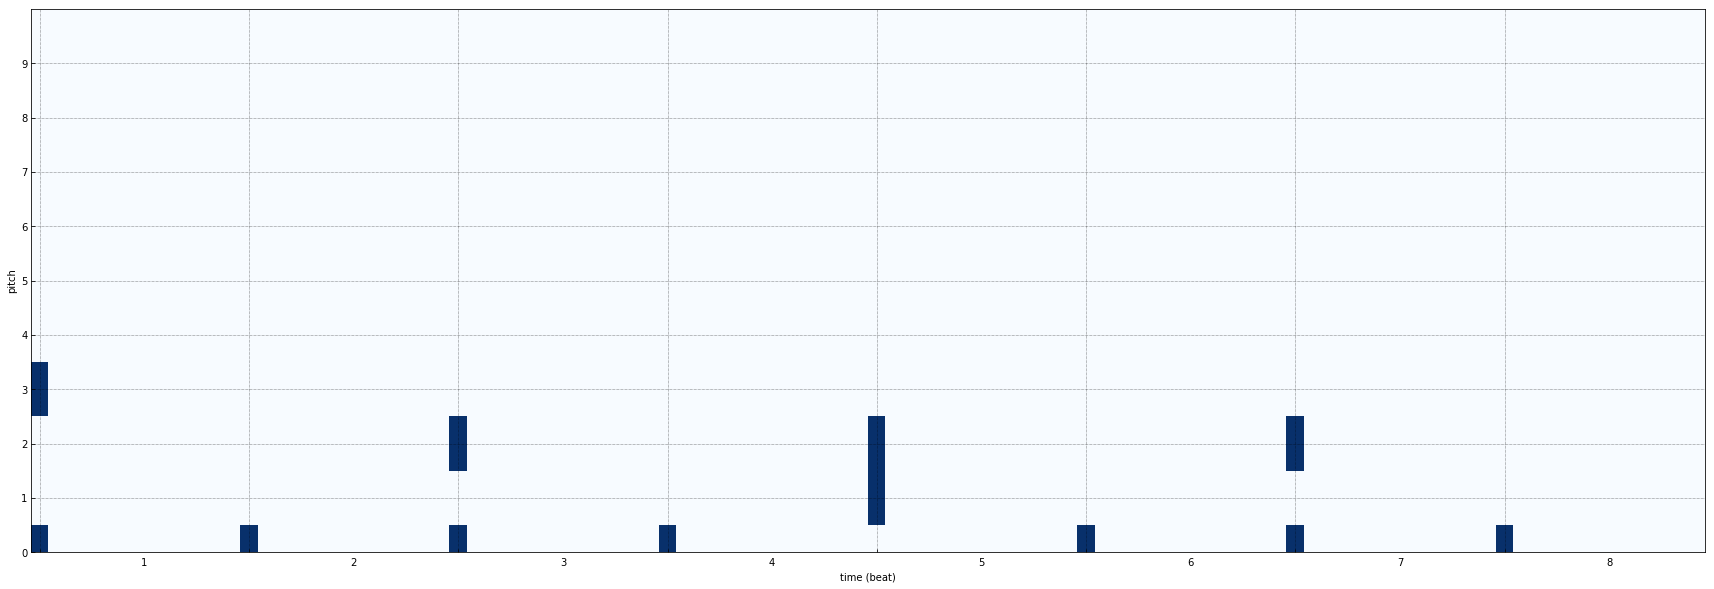

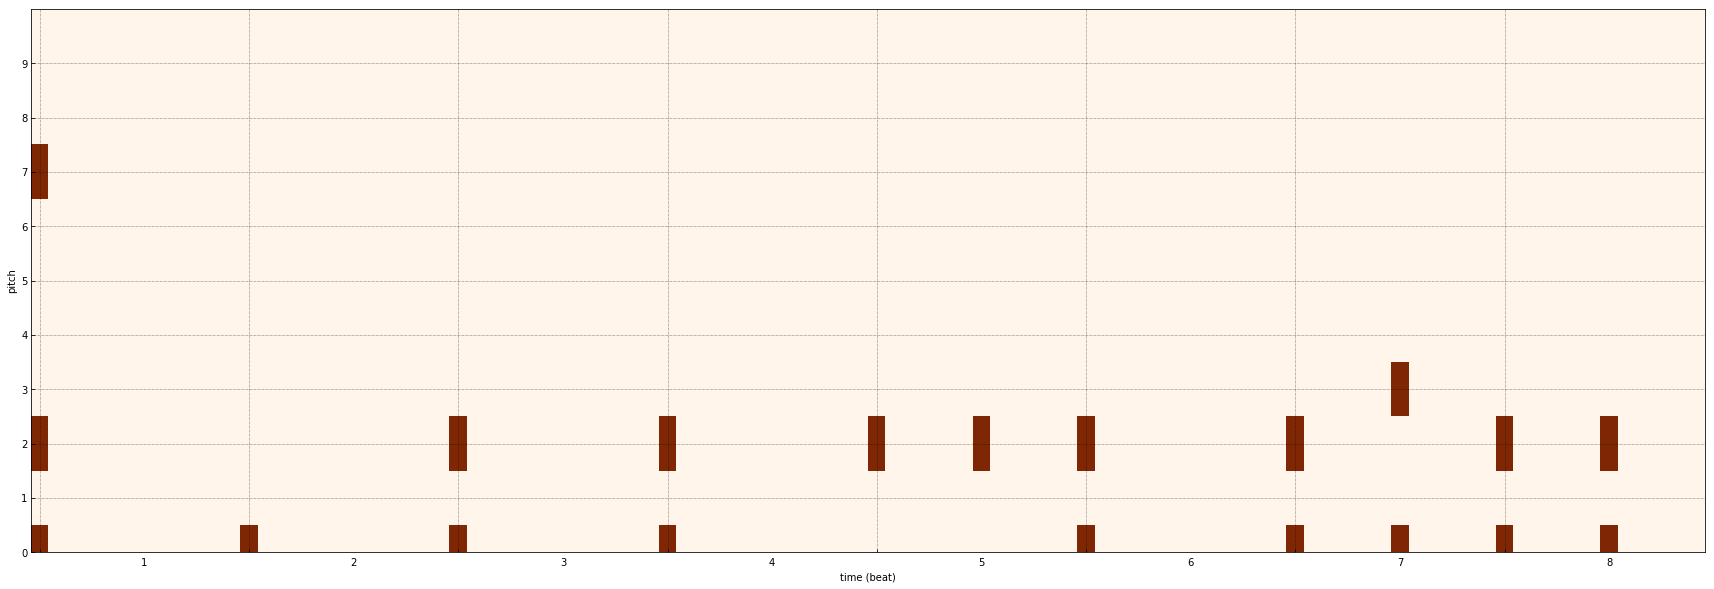

0.76159084 2.354469e-12


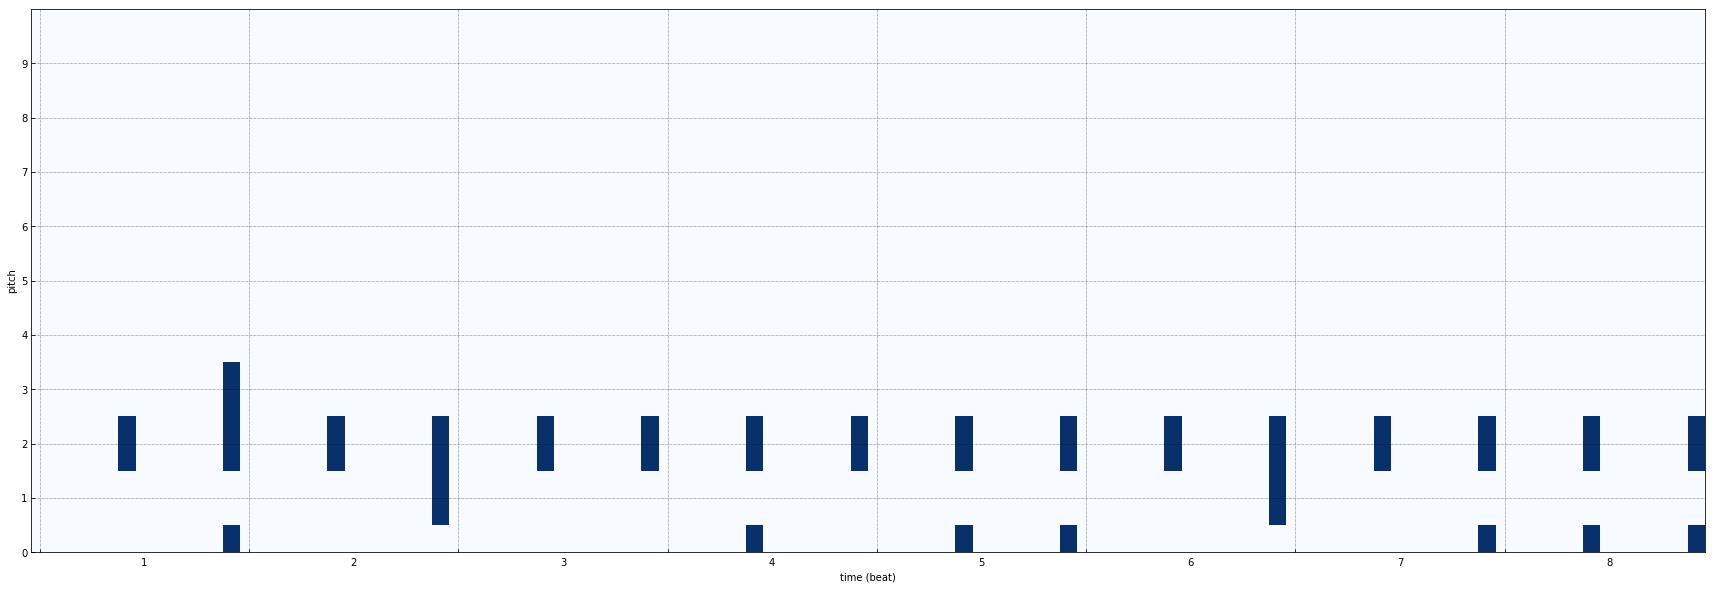

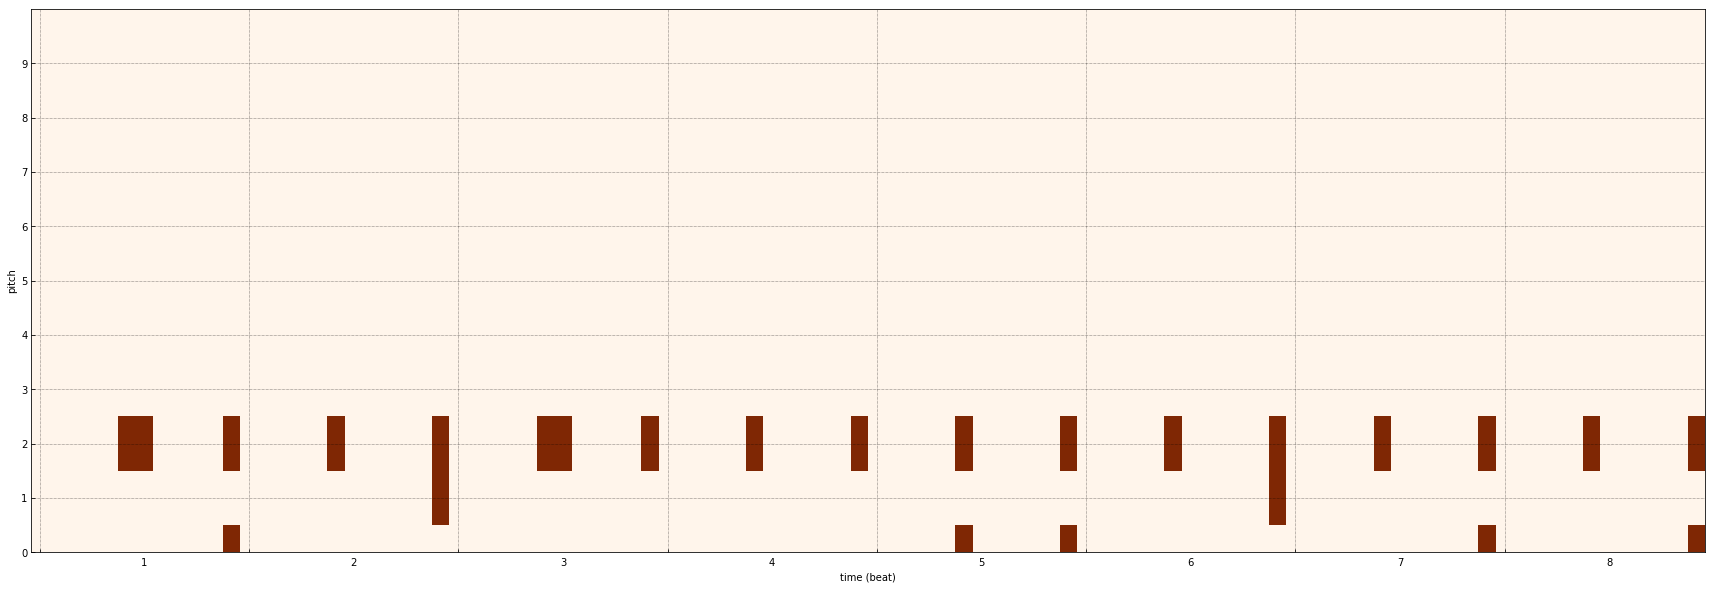

0.76159406 1.0151013e-14


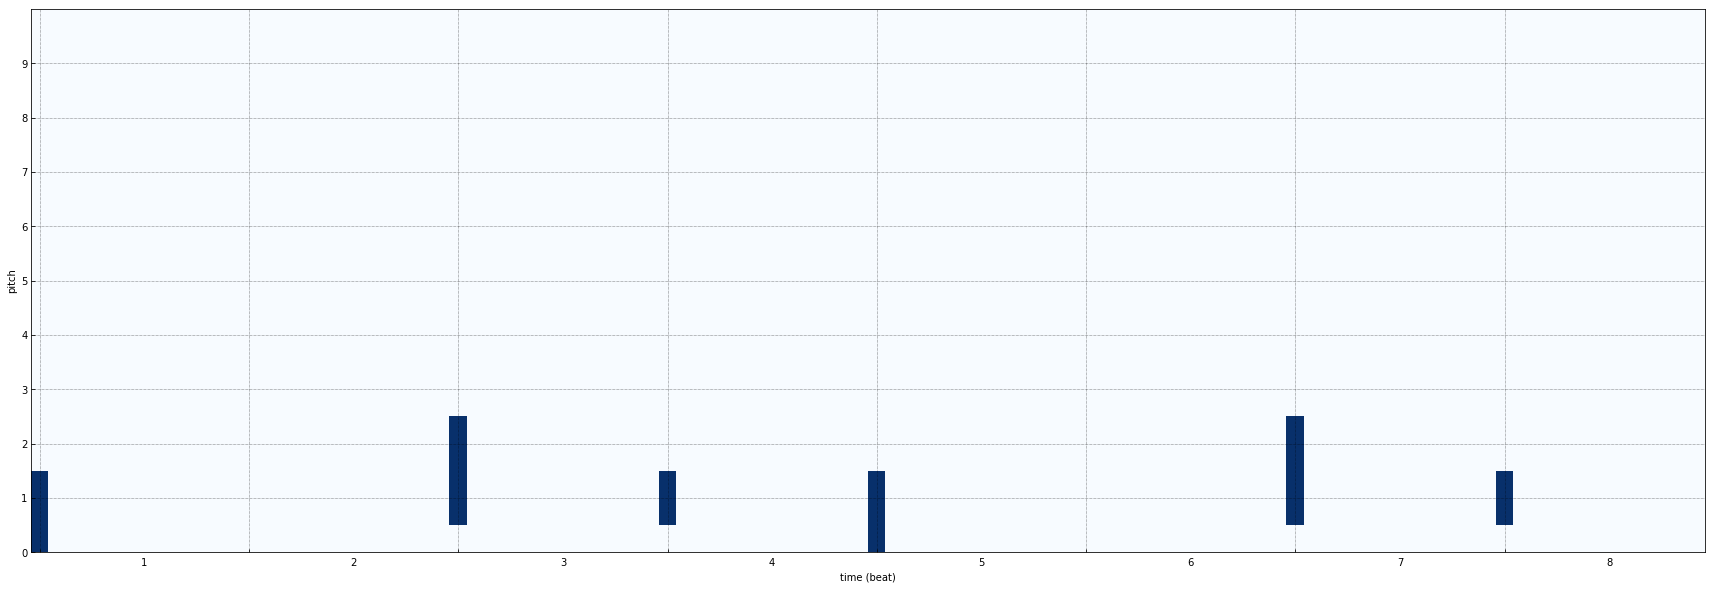

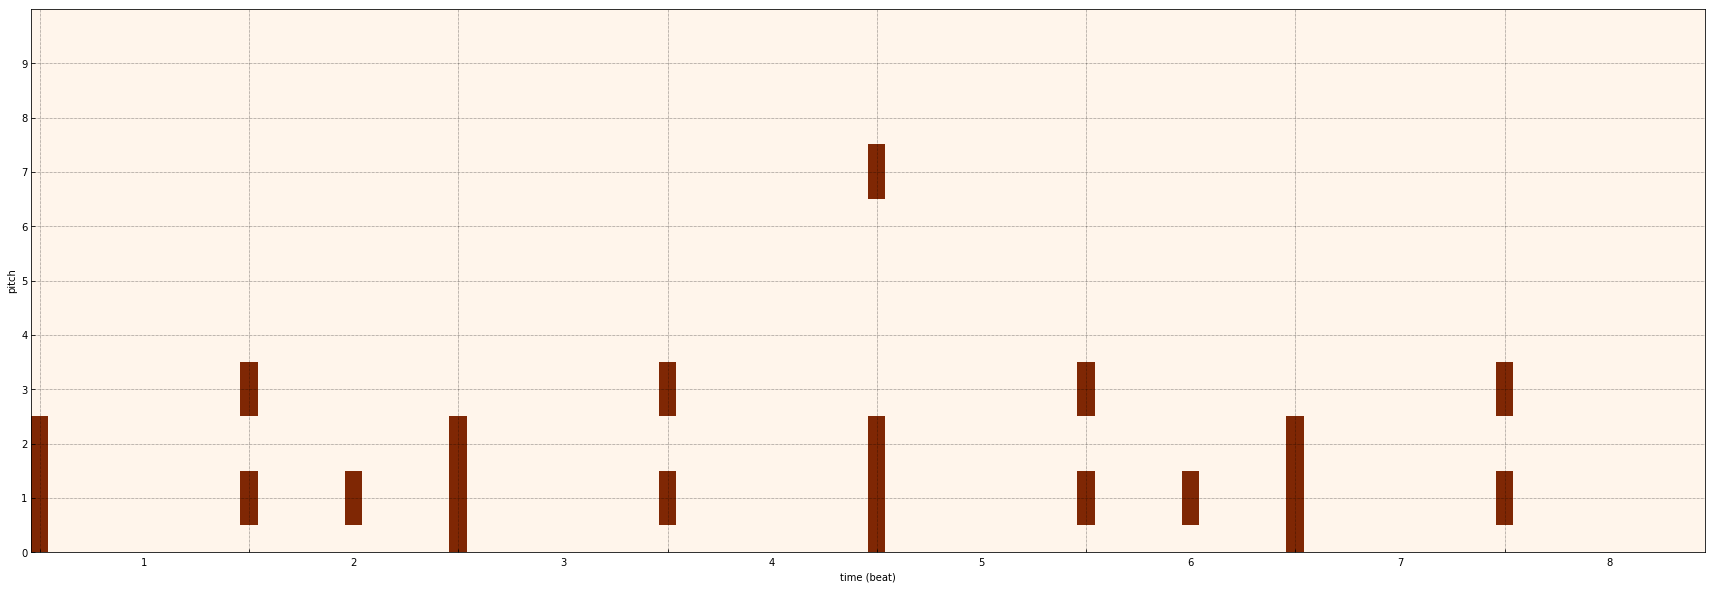

0.76159346 2.3764024e-14


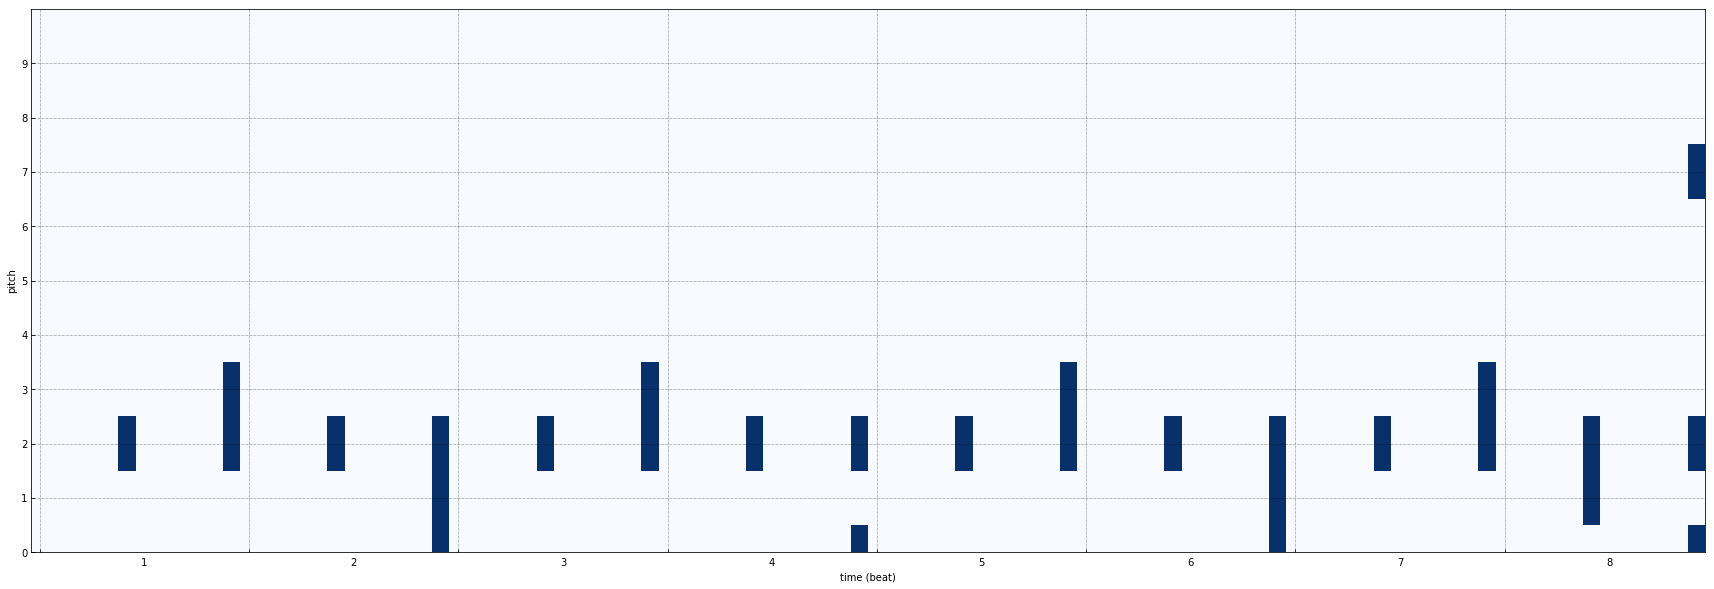

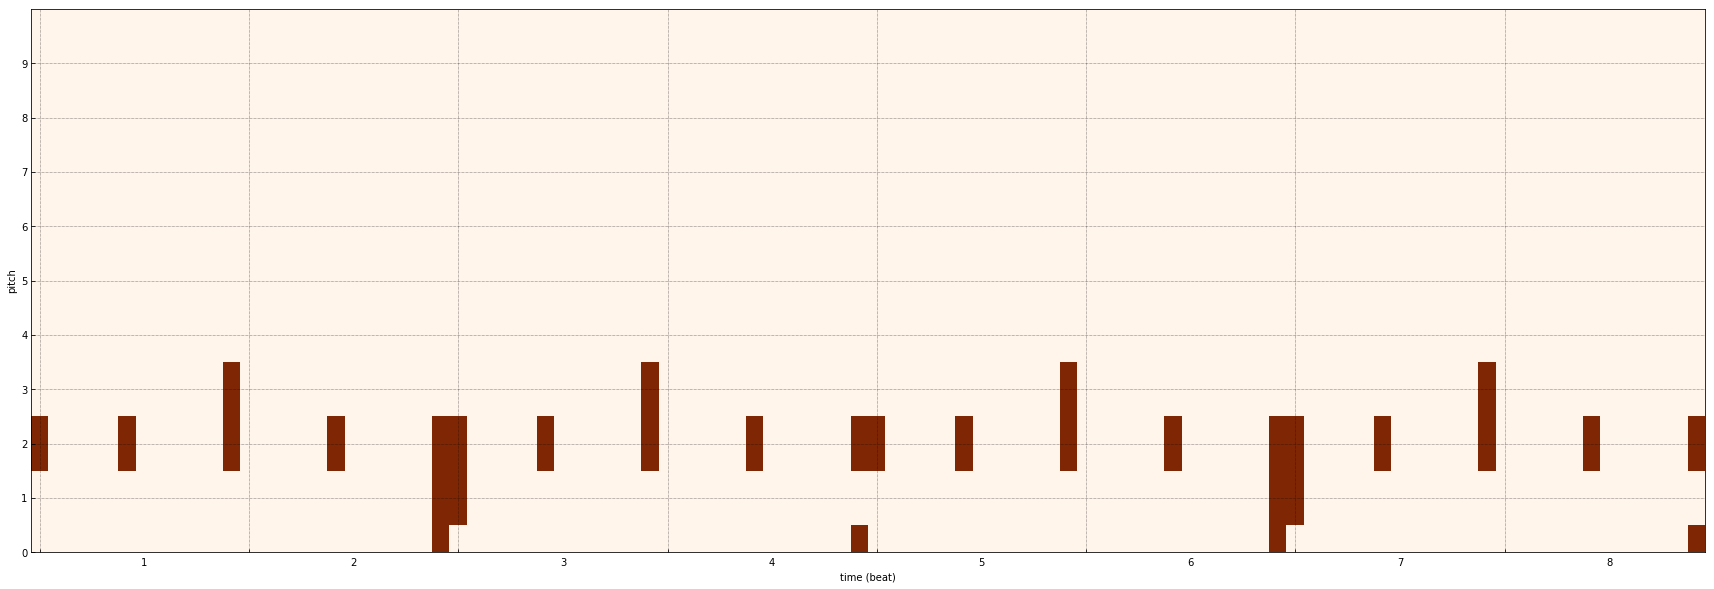

0.76159346 5.234537e-13


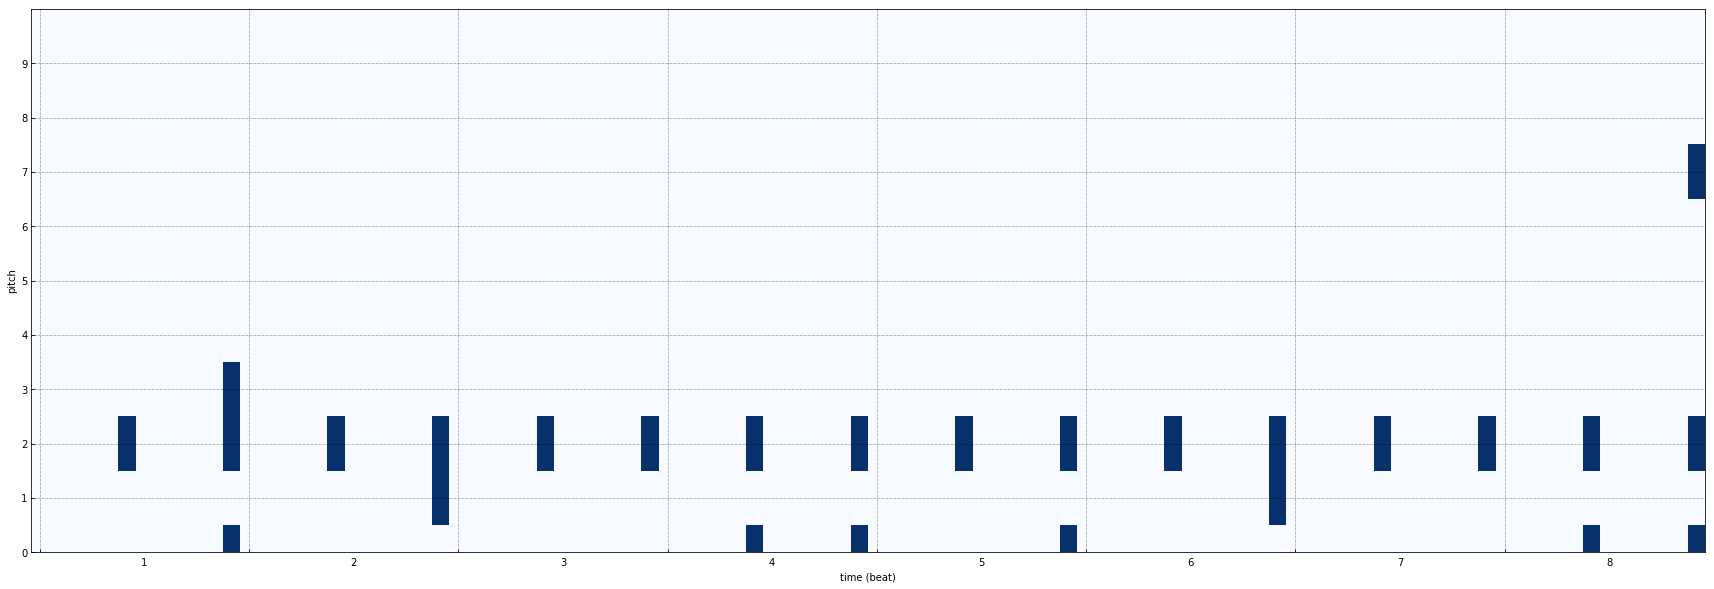

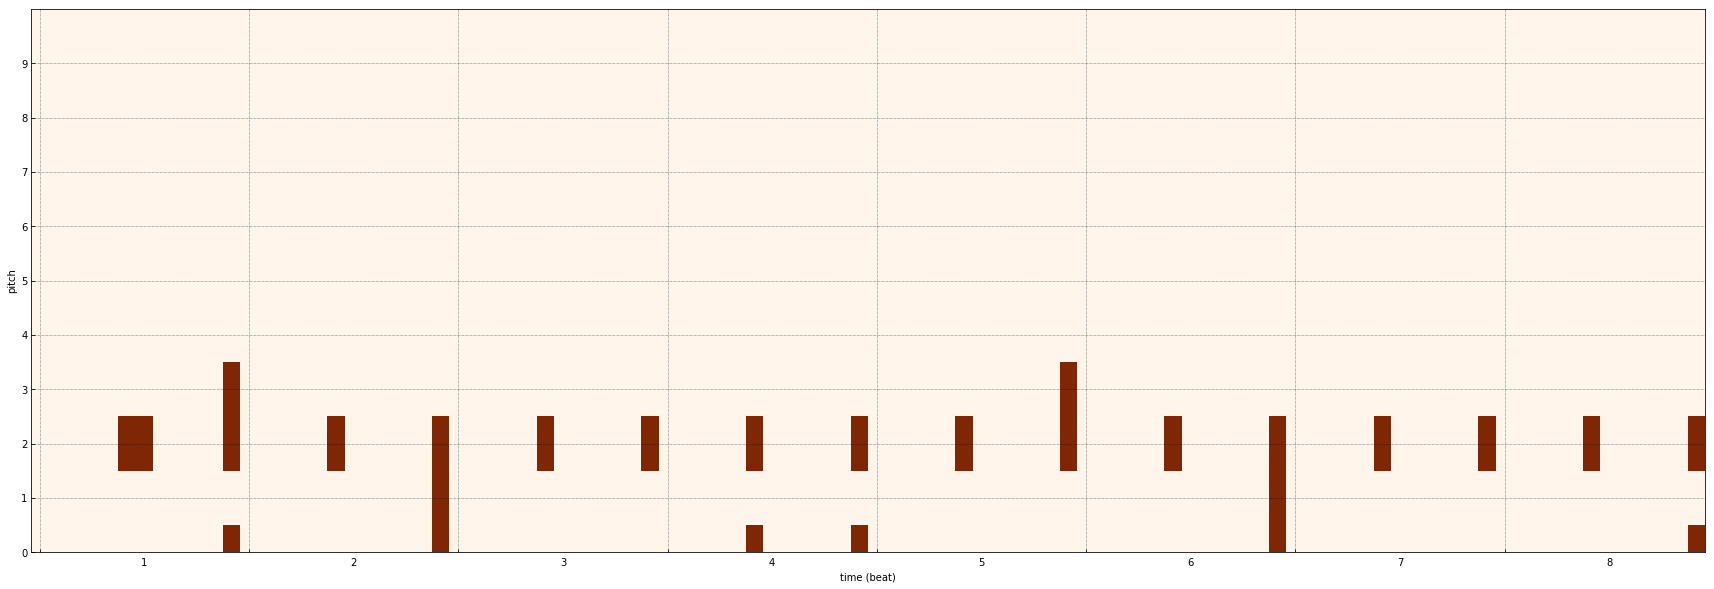

0.76147693 2.3082963e-15


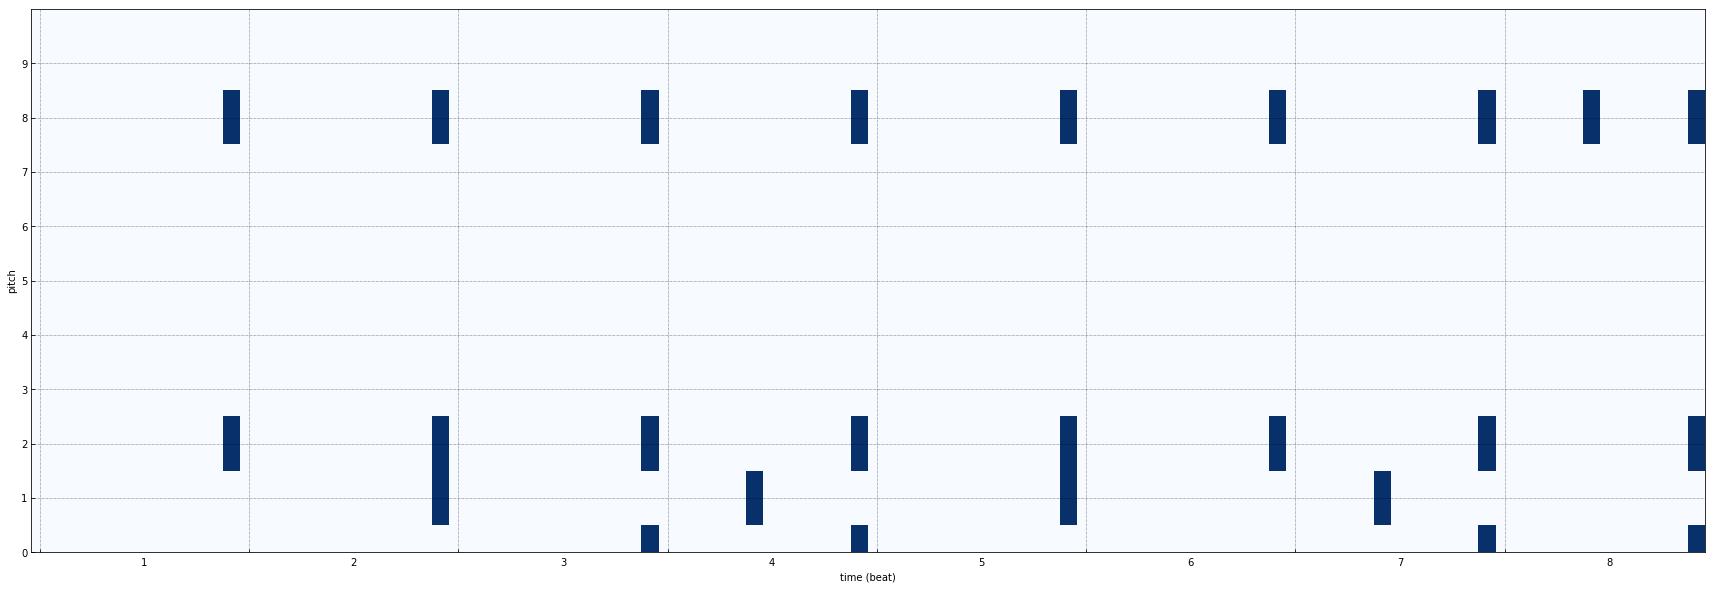

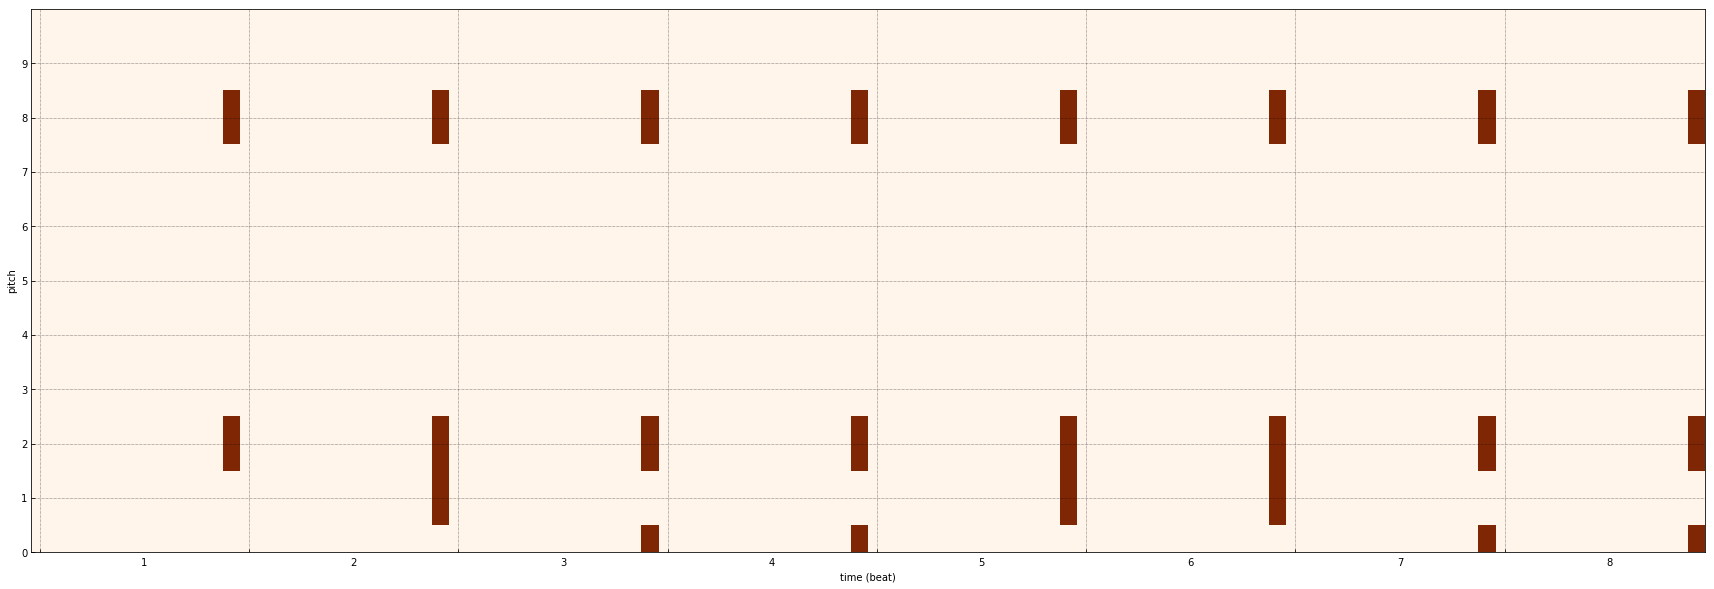

0.76158905 8.296916e-13


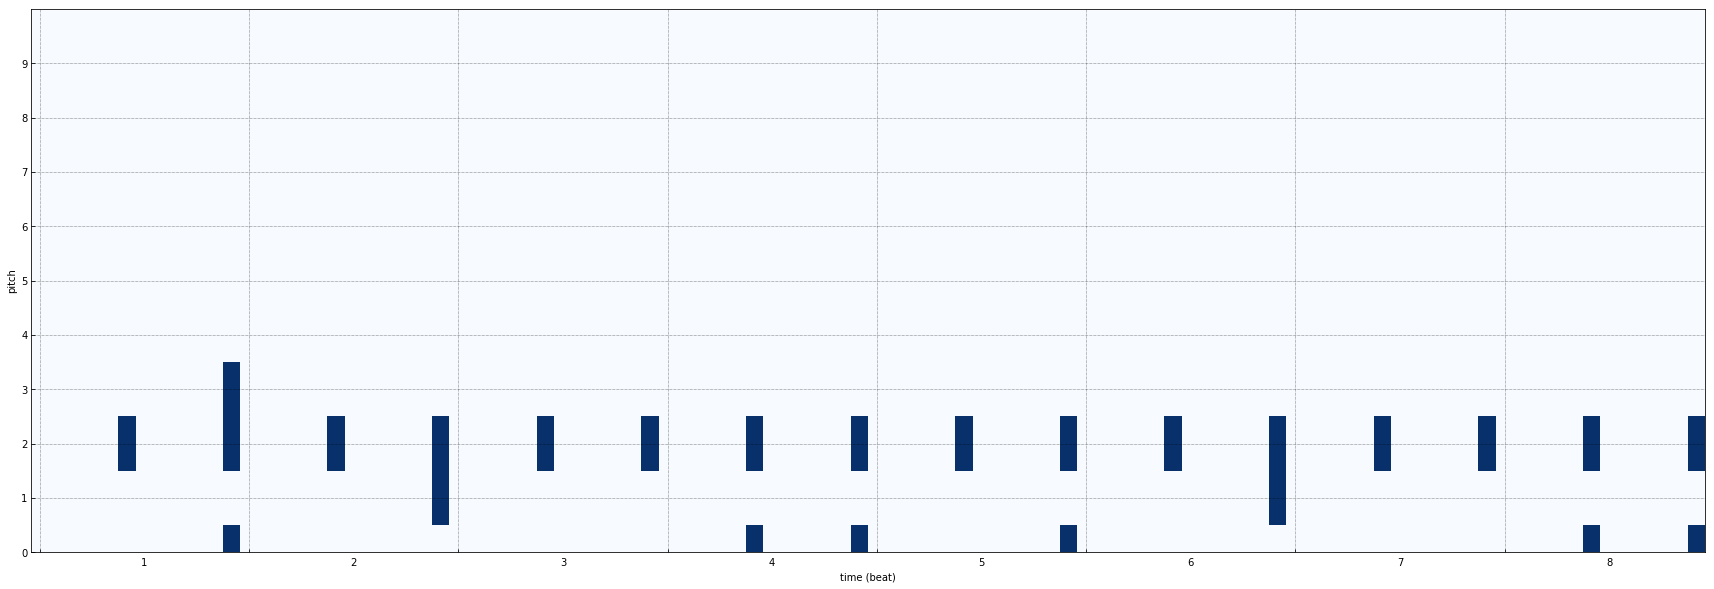

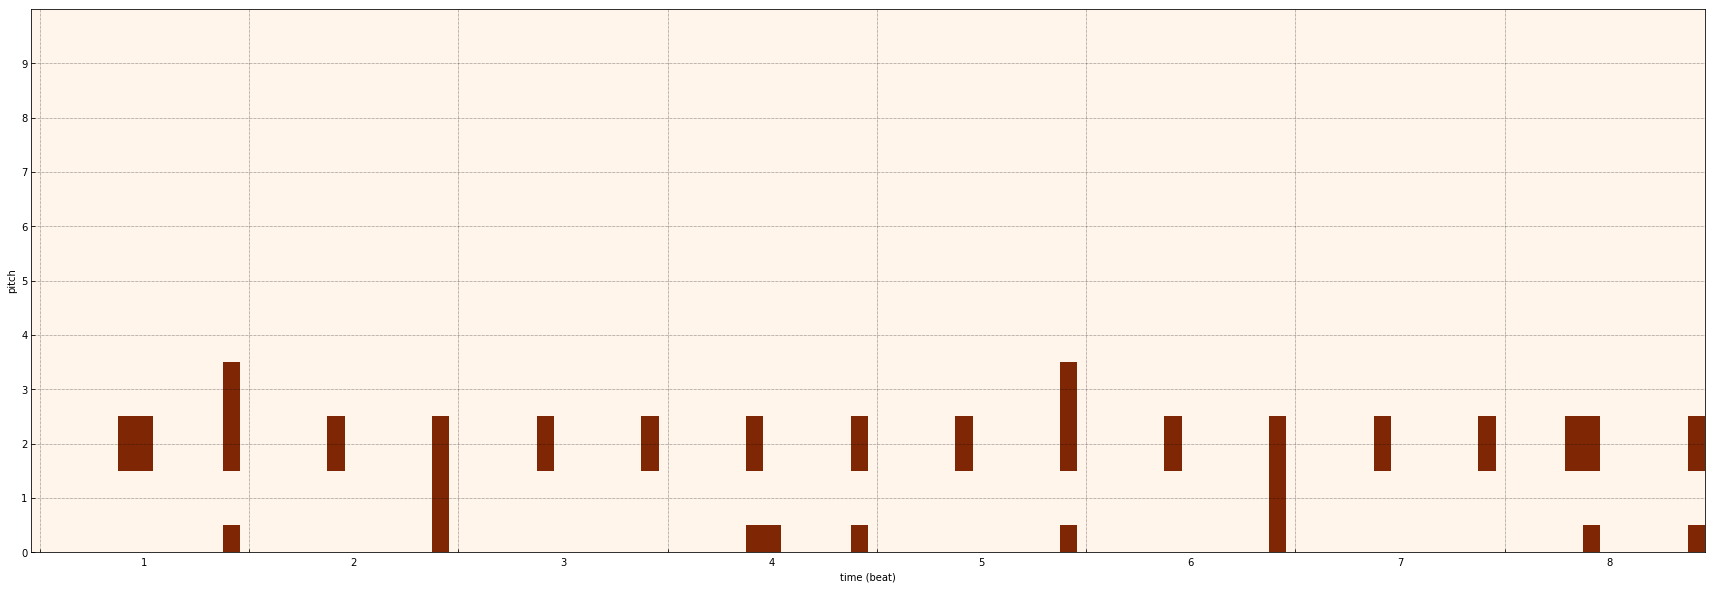

0.7615942 5.3064416e-13


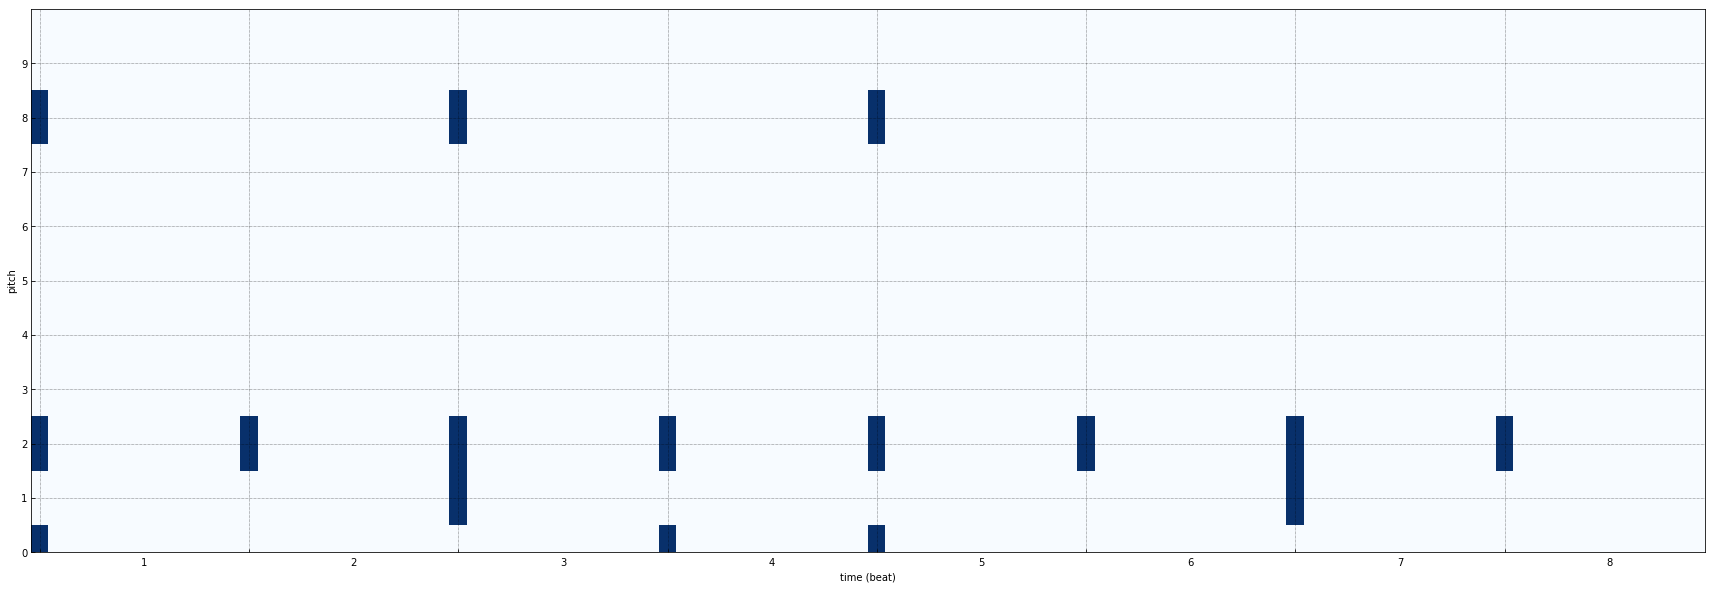

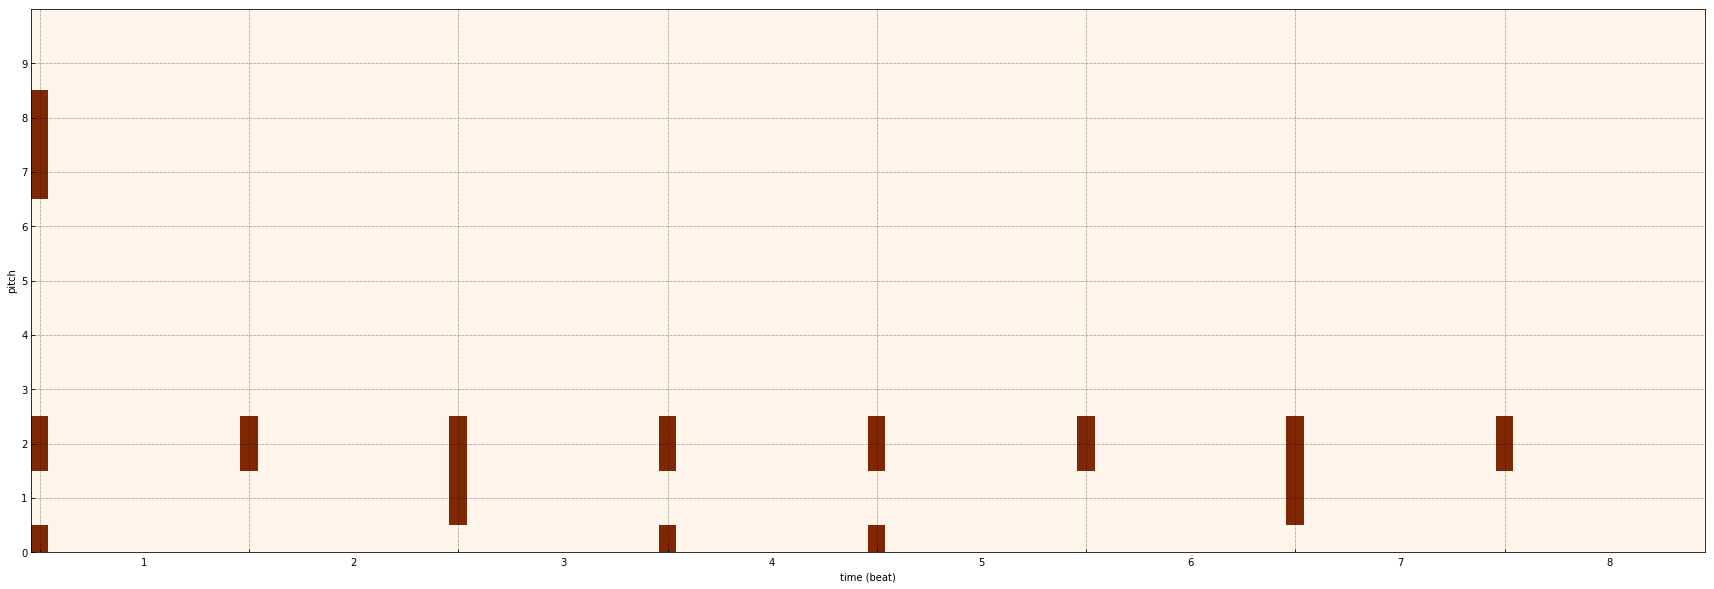

0.7615942 4.166232e-14


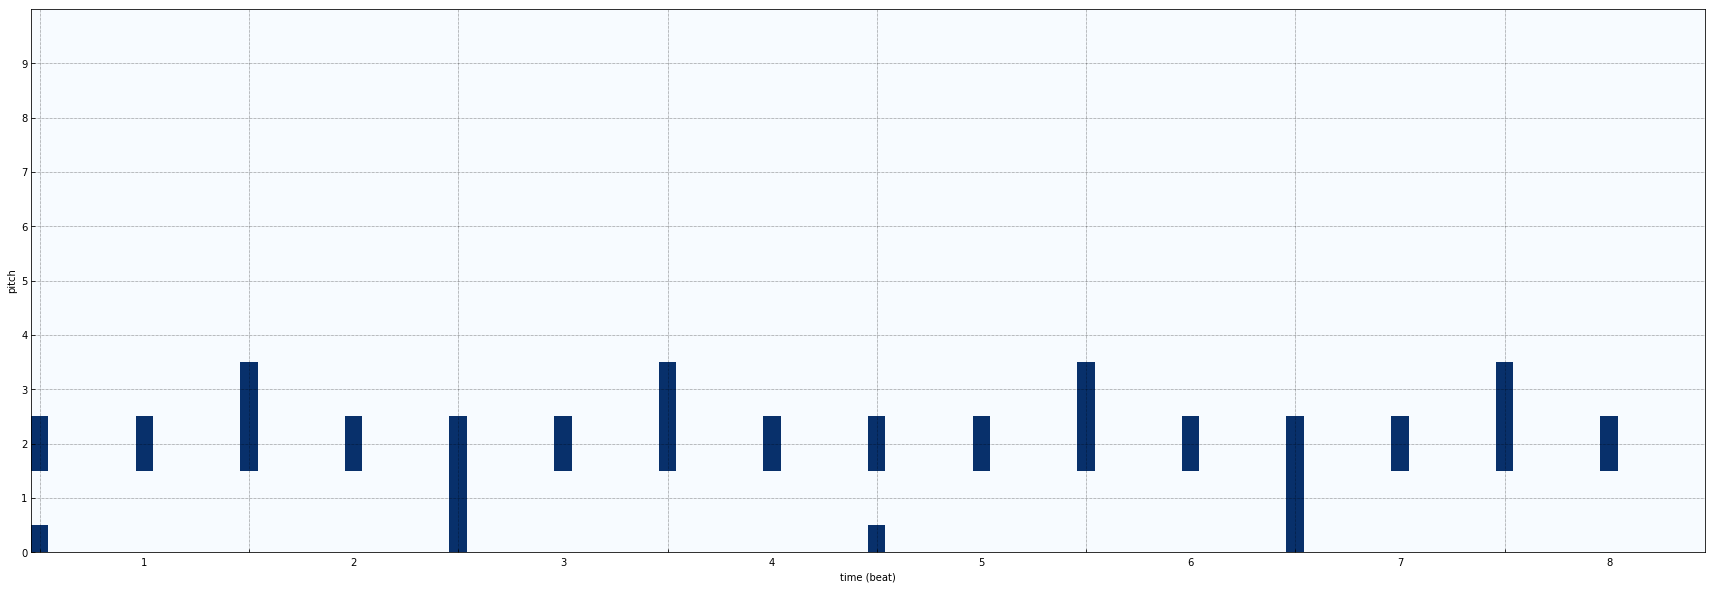

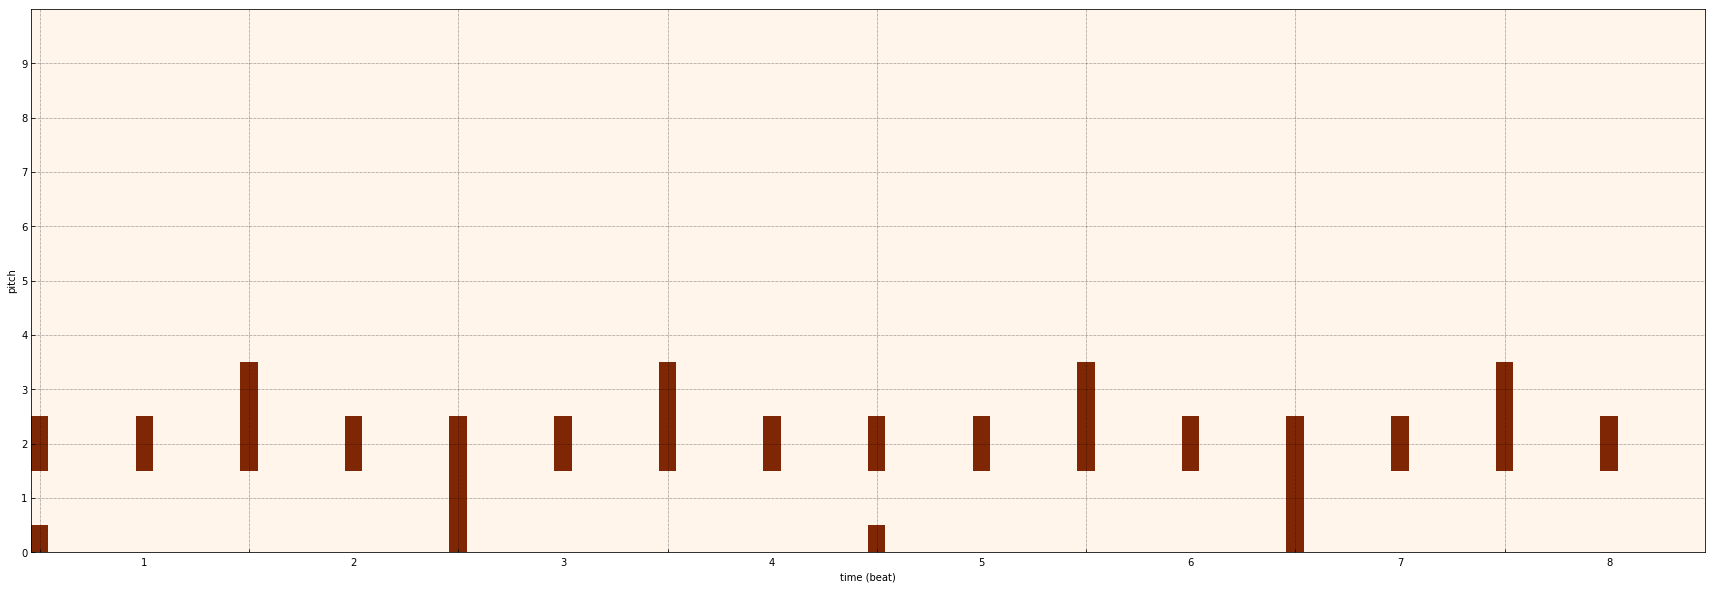

0.7615777 7.1073215e-13


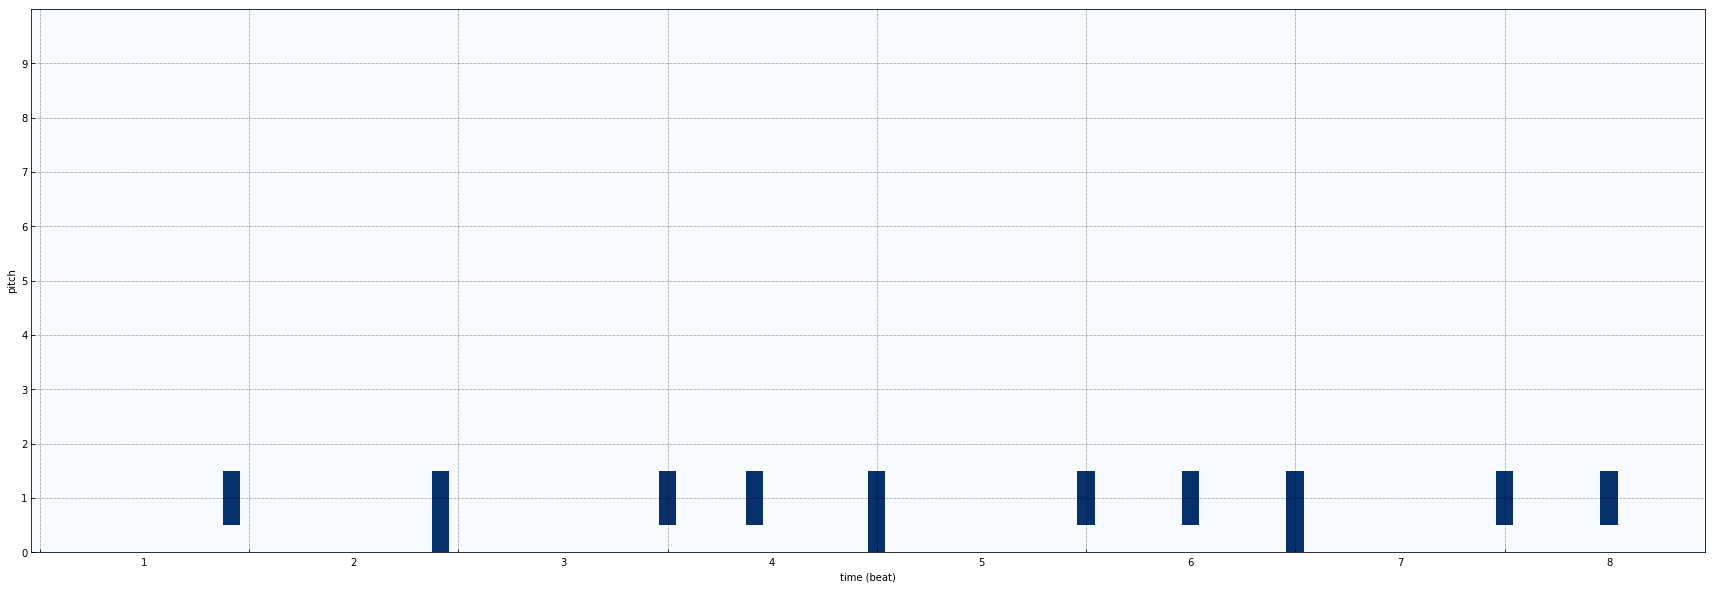

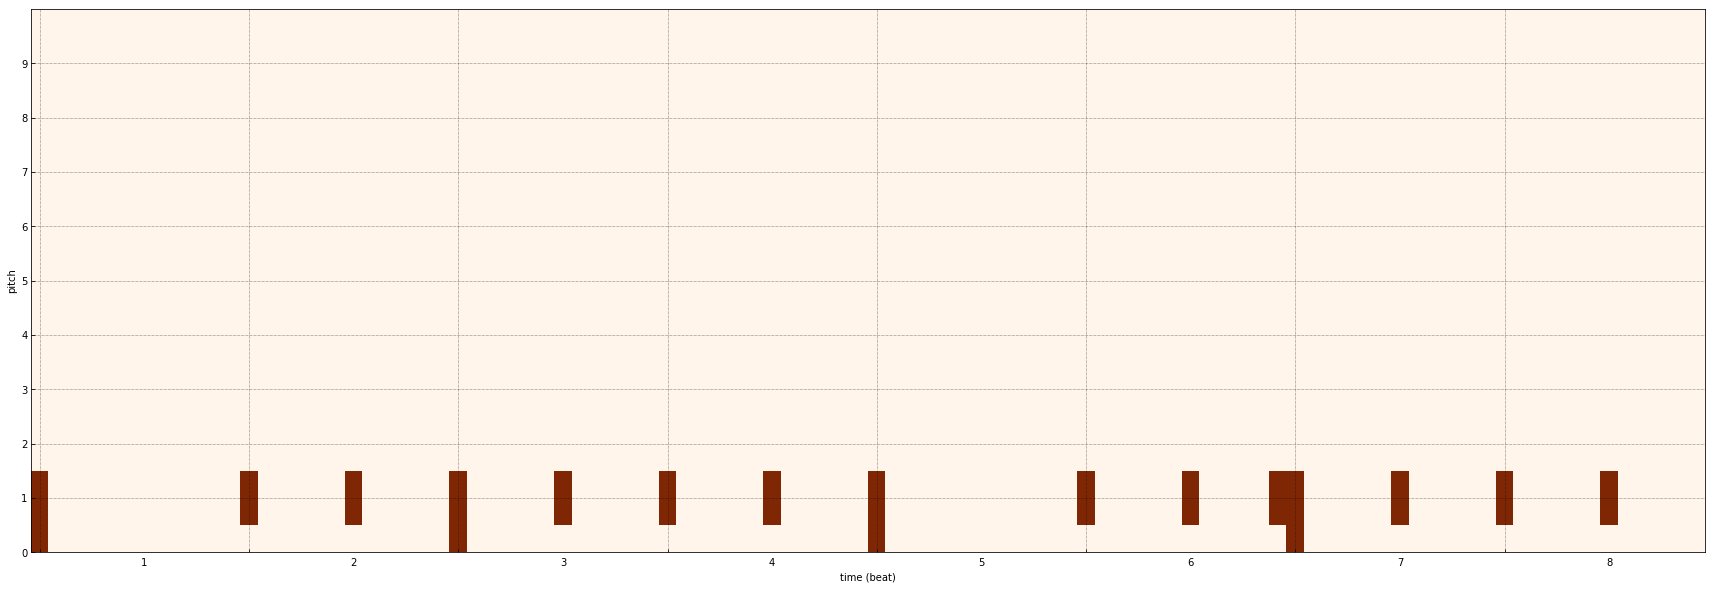

0.7615914 2.3878157e-14


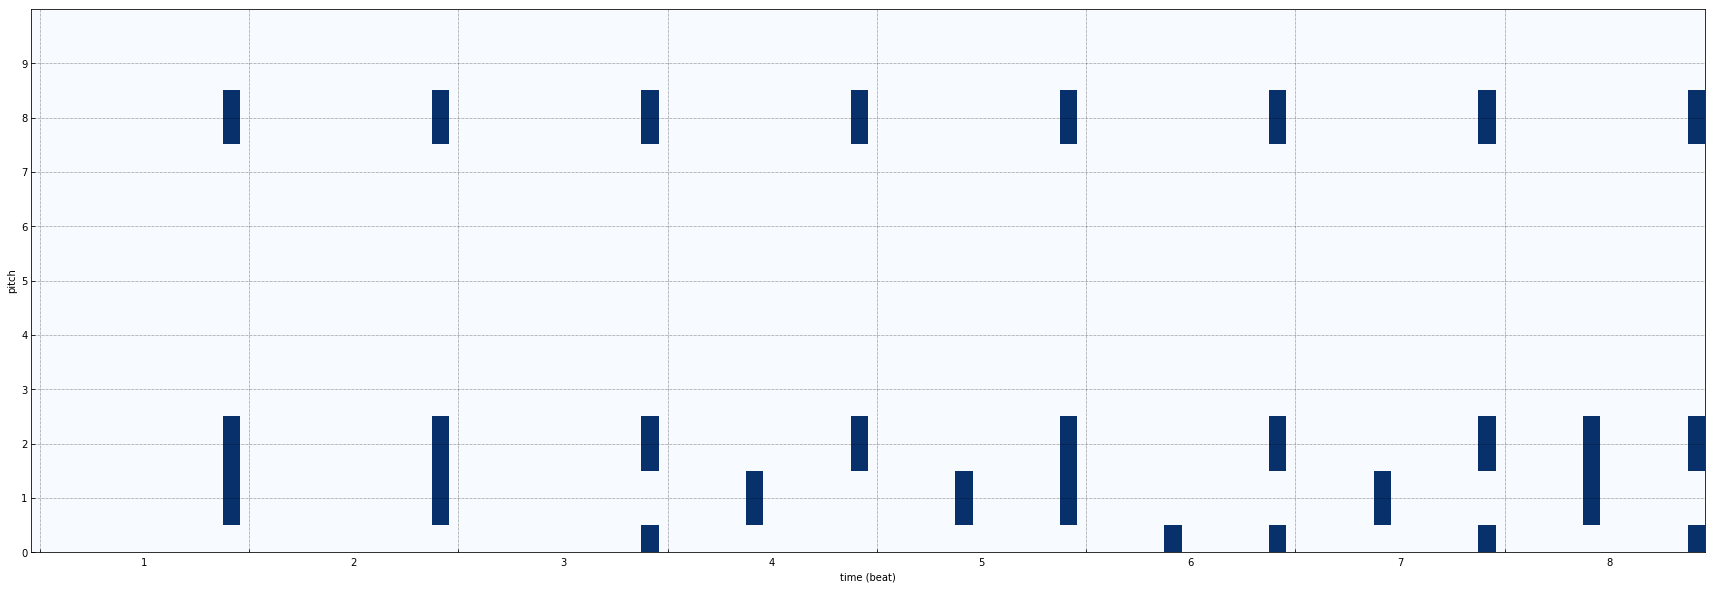

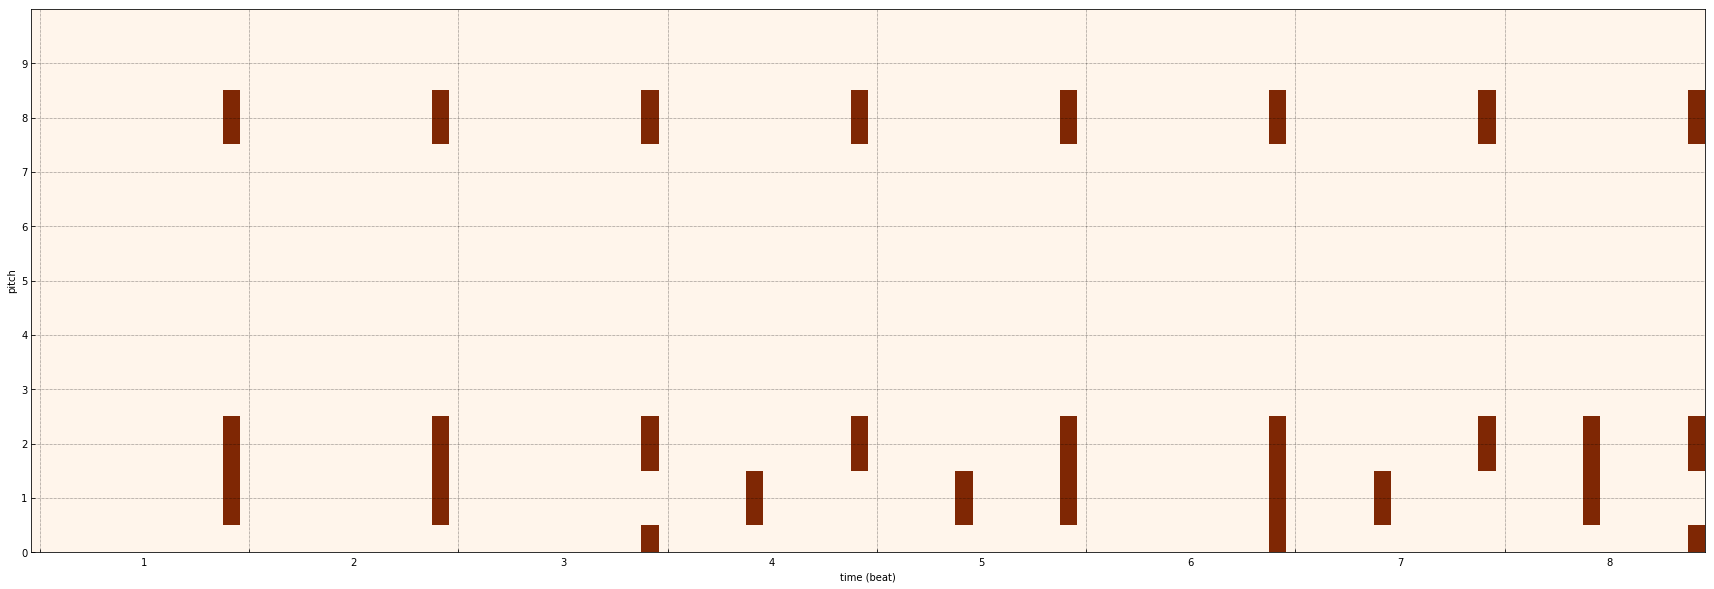

0.7615843 6.1298135e-14


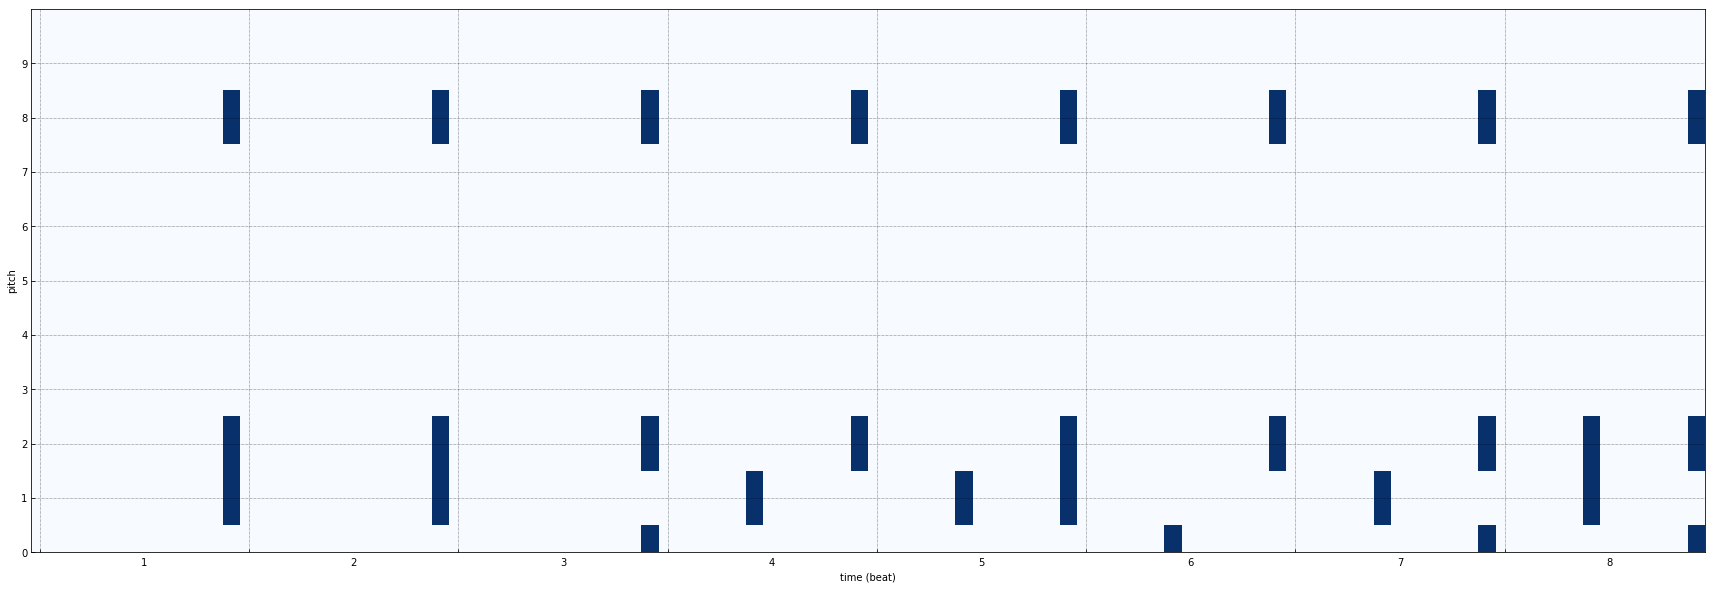

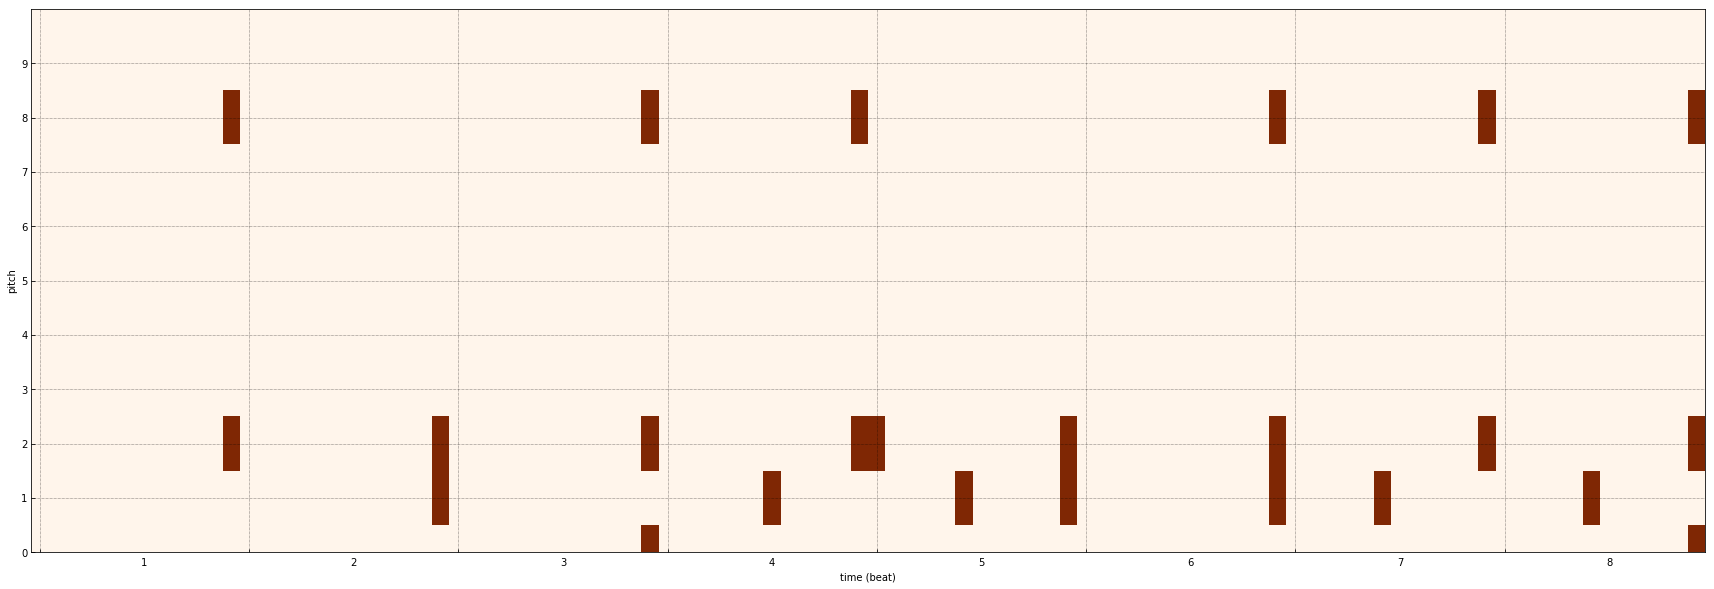

0.76056063 1.5687354e-11


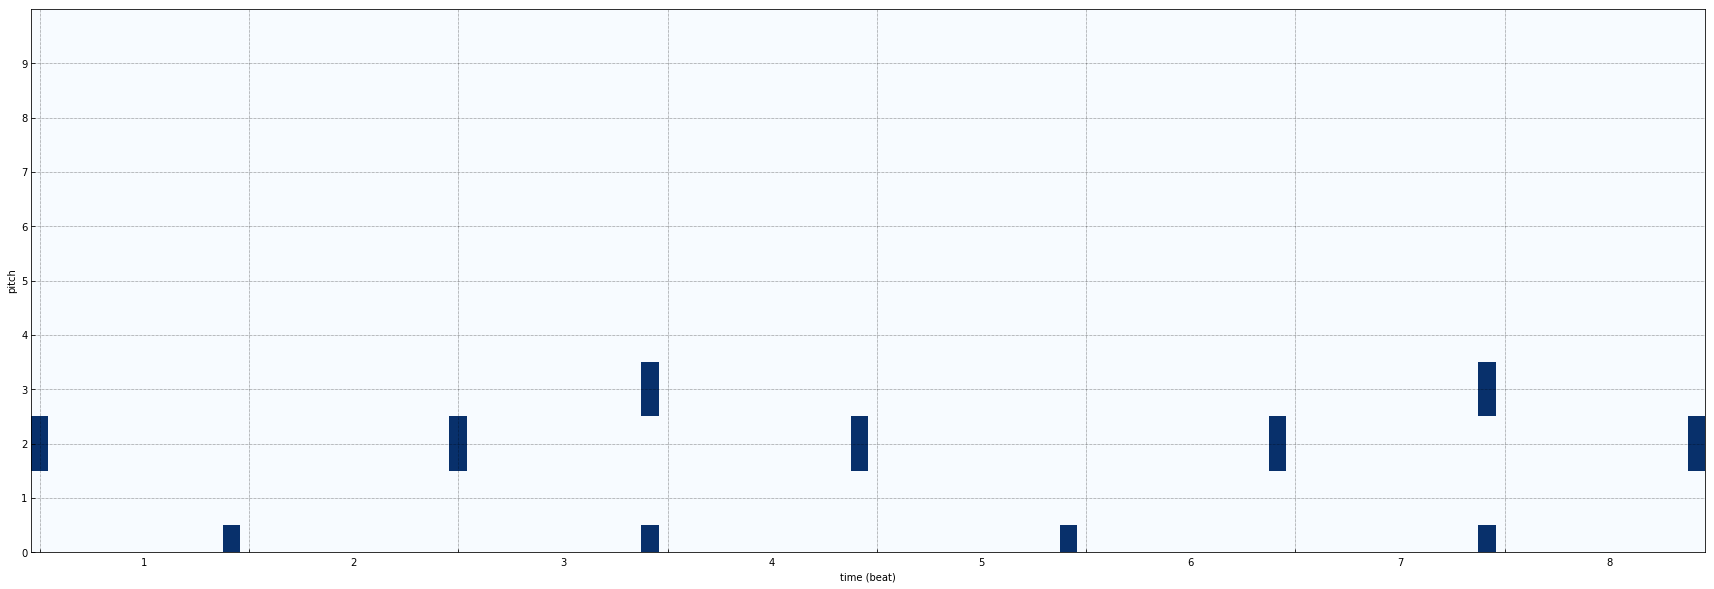

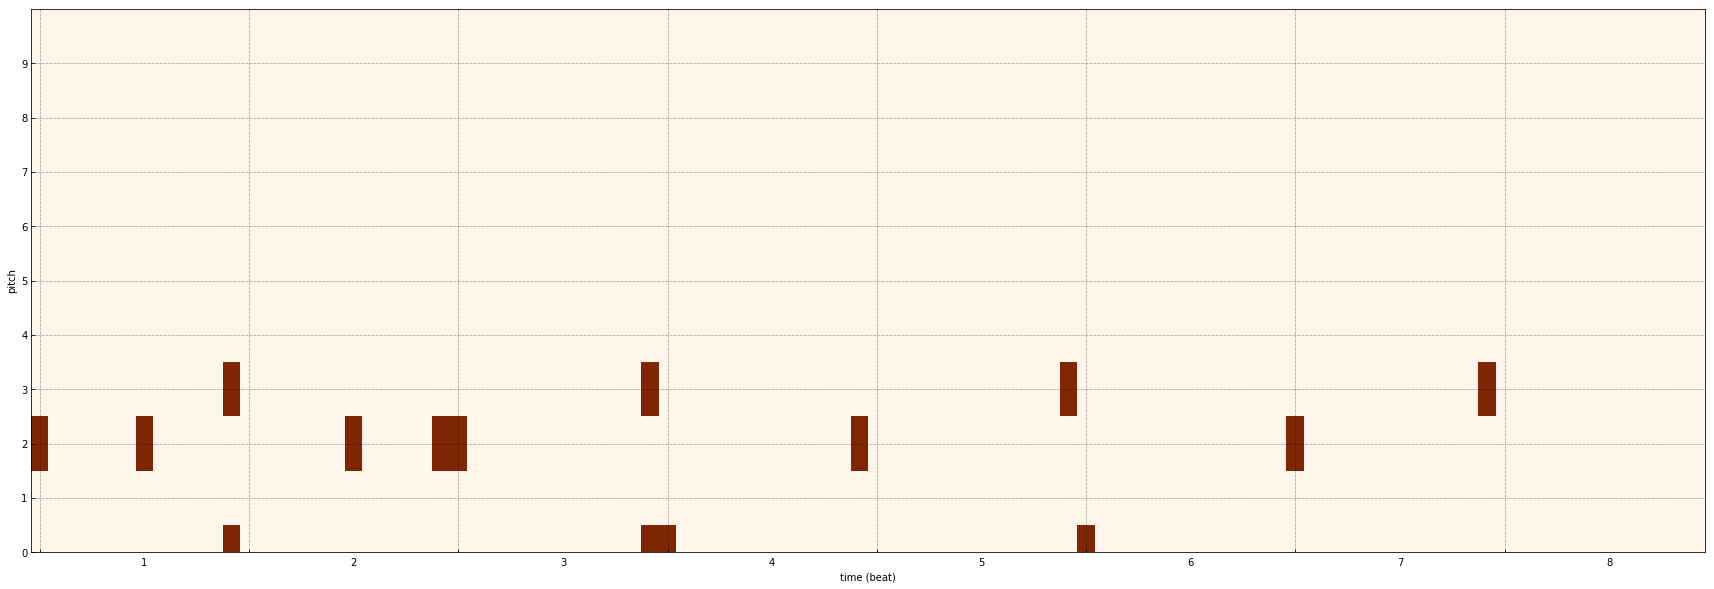

0.76152414 1.3020457e-12


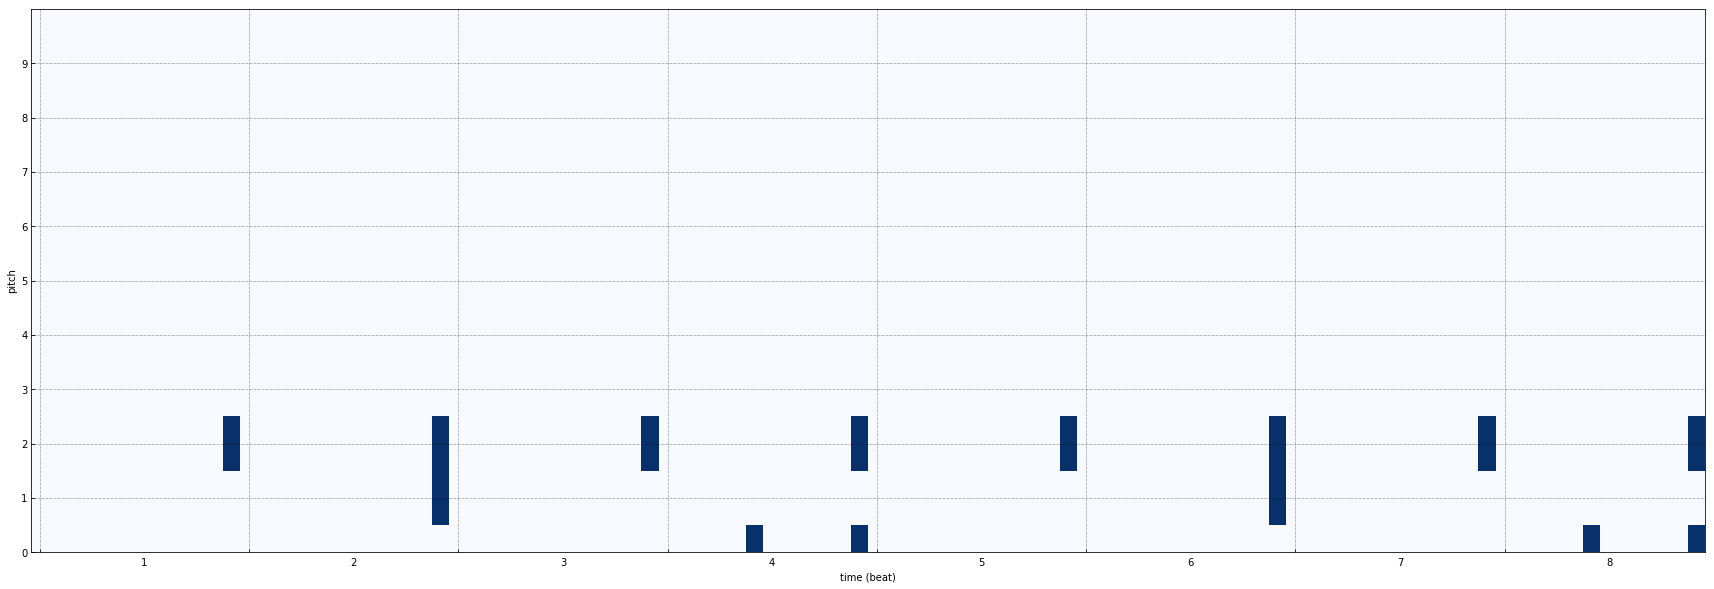

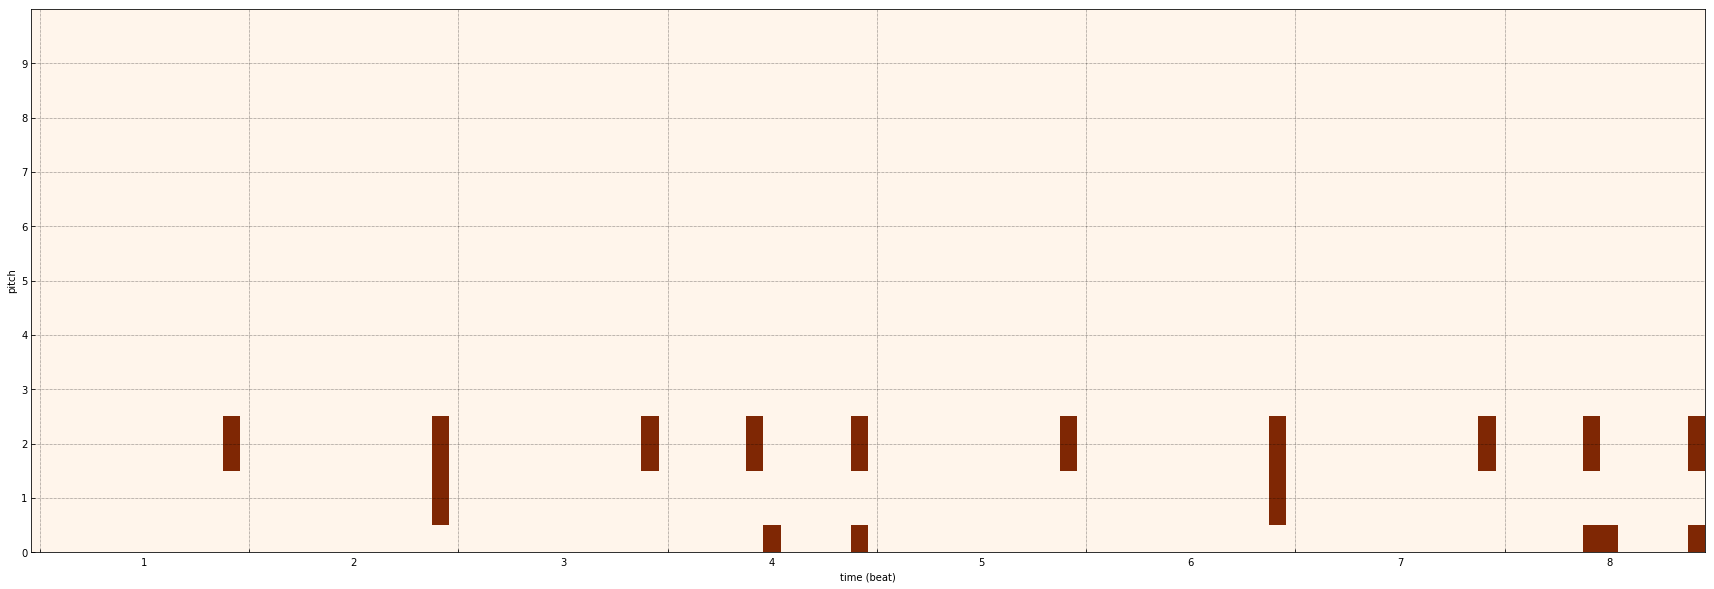

0.7615535 1.7227781e-14


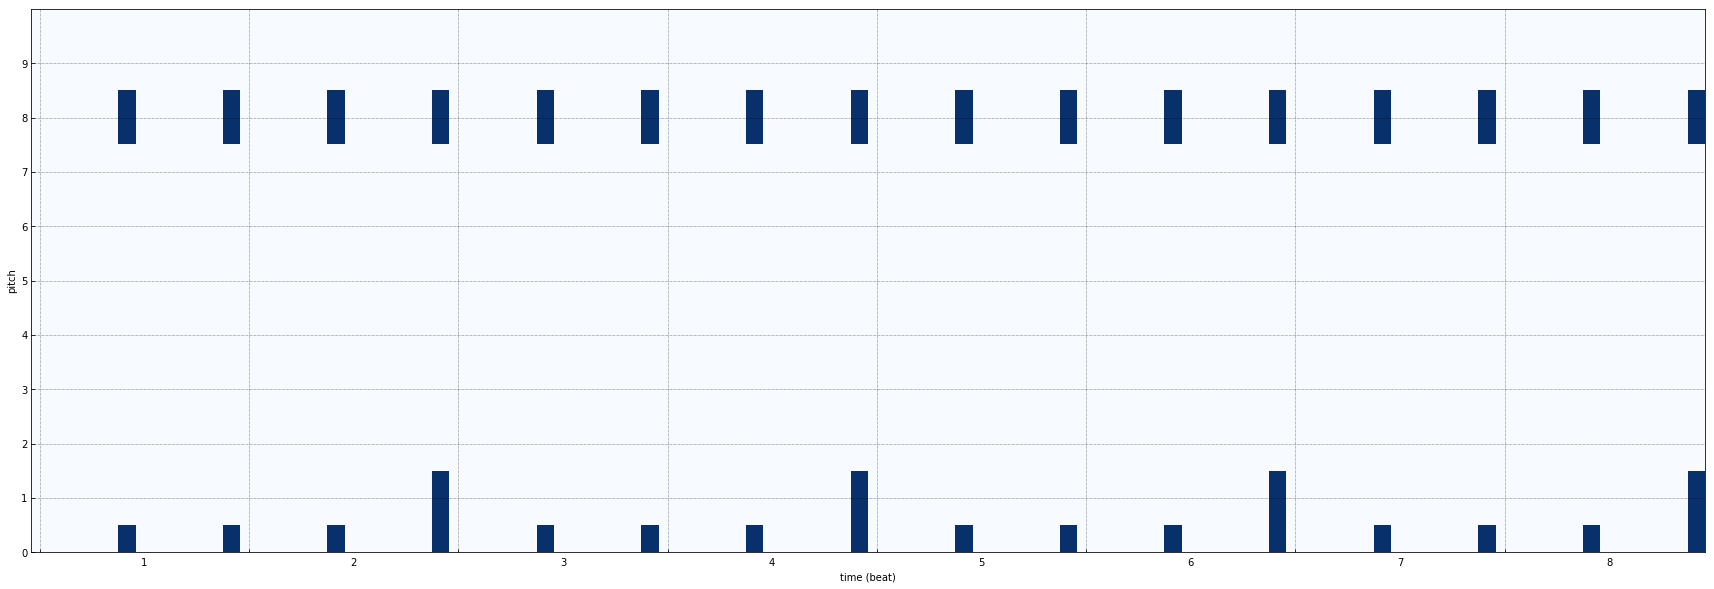

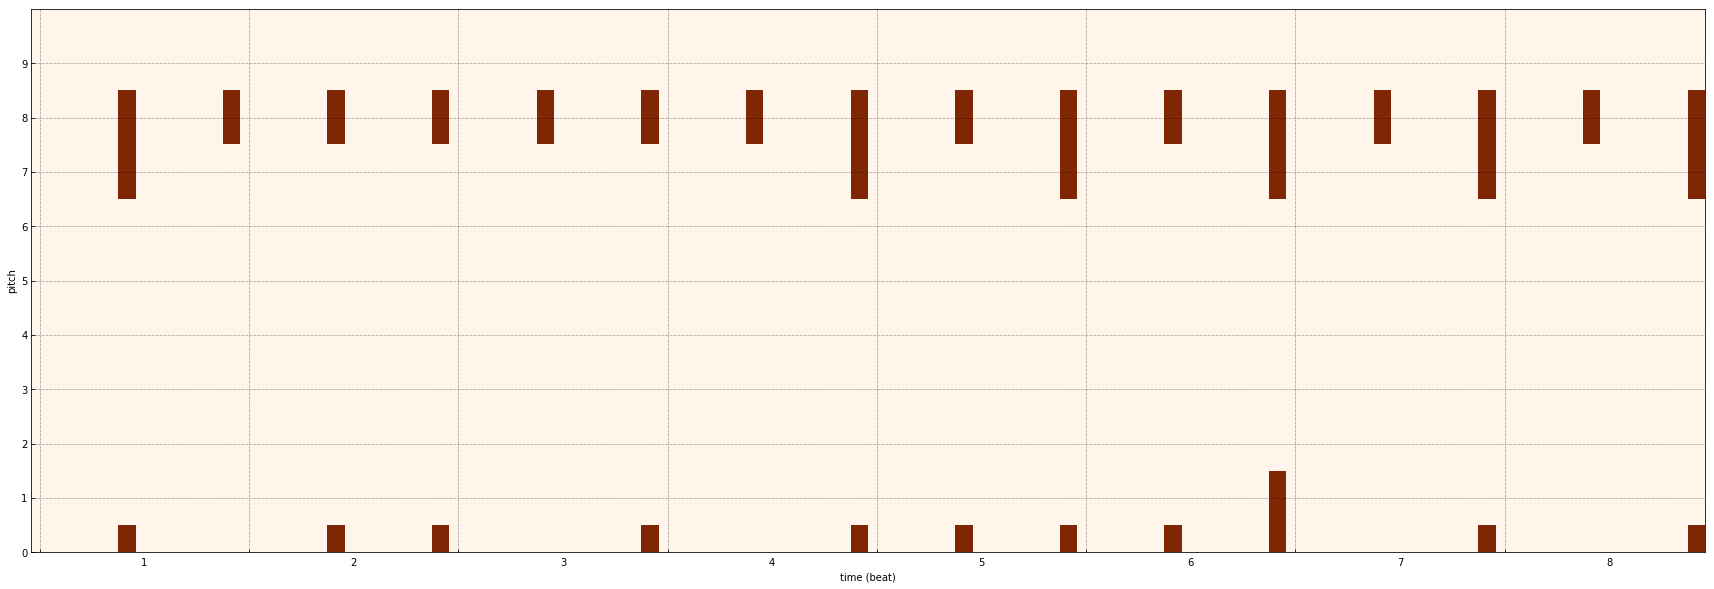

0.76053894 2.765365e-10


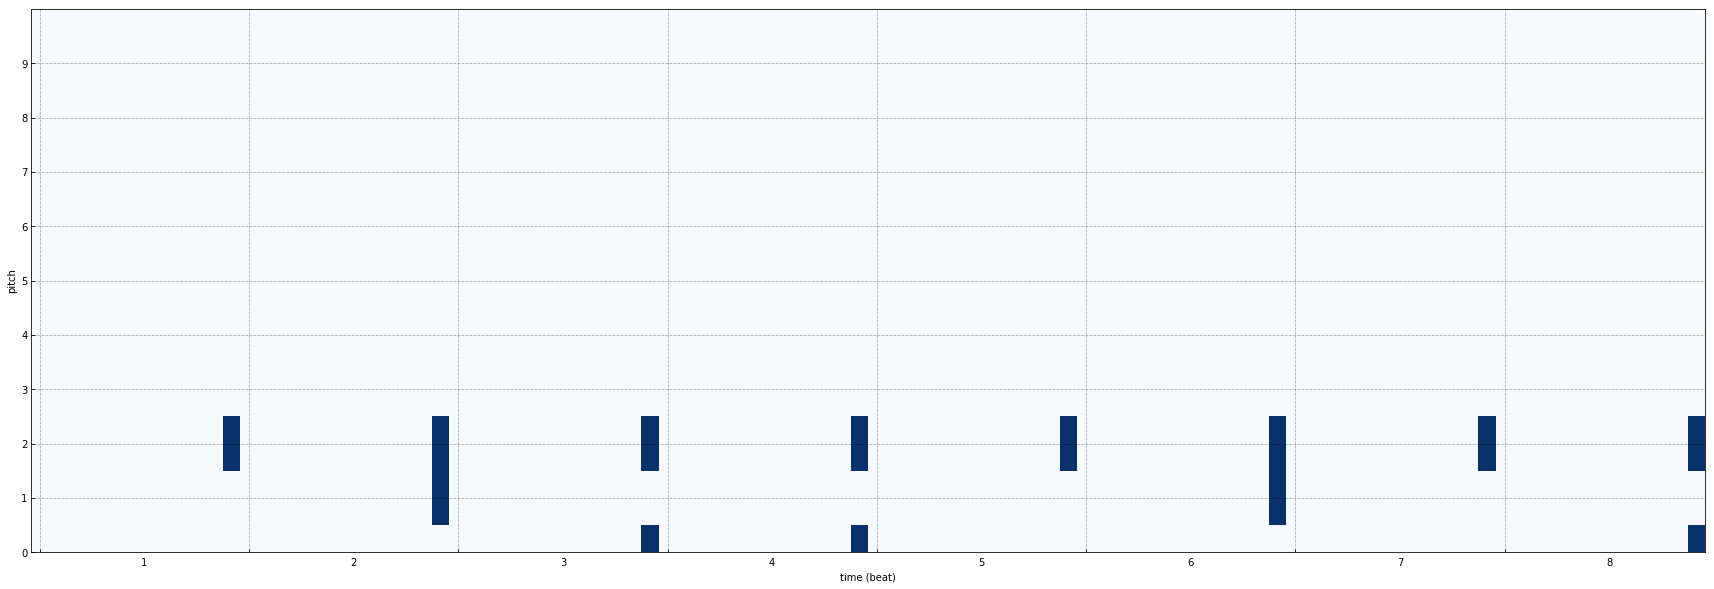

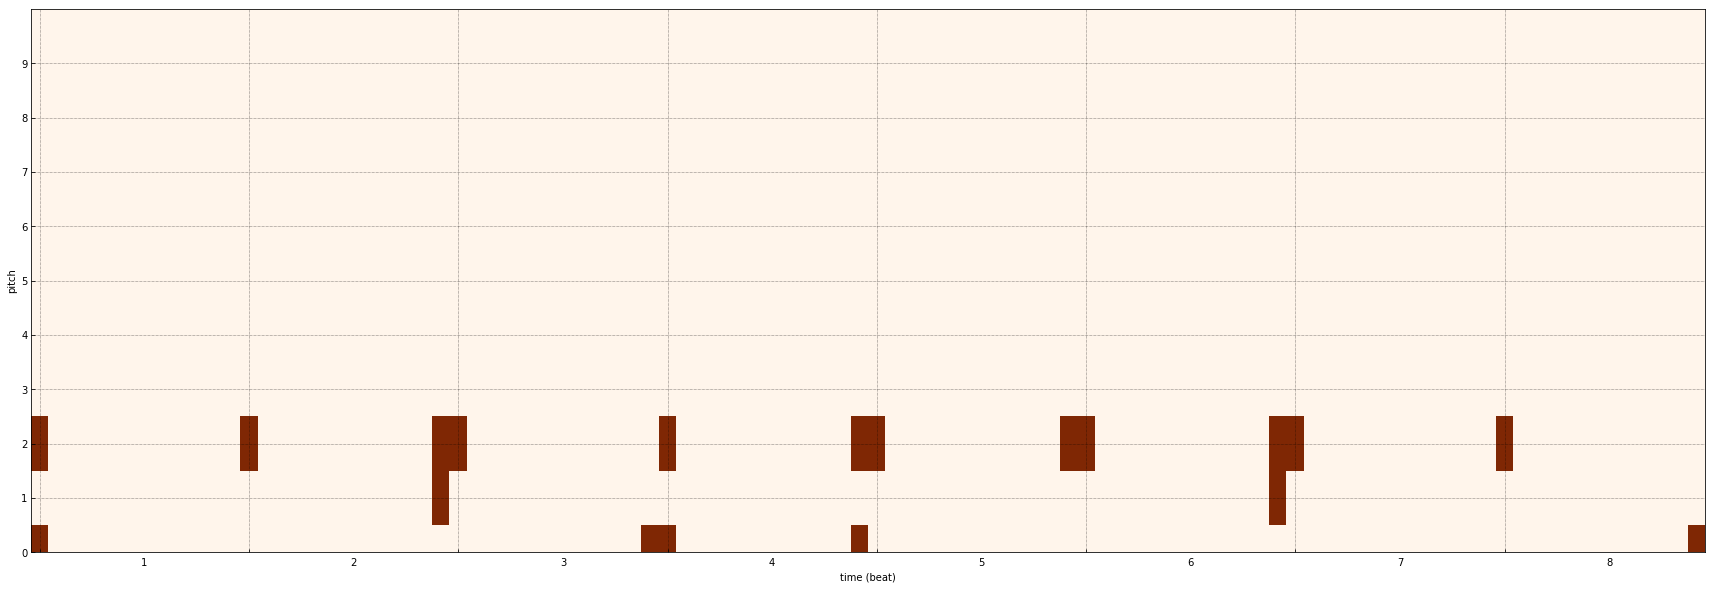

0.7615093 1.06539126e-13


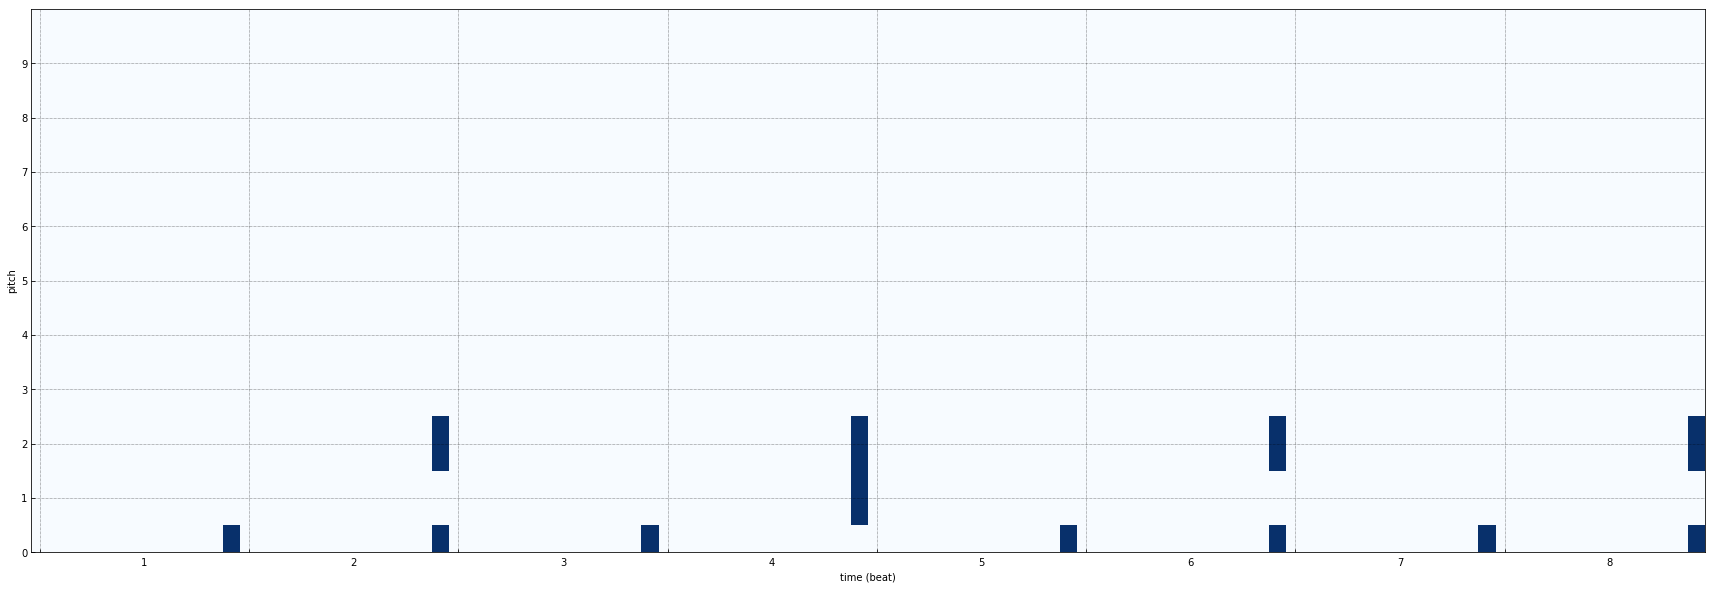

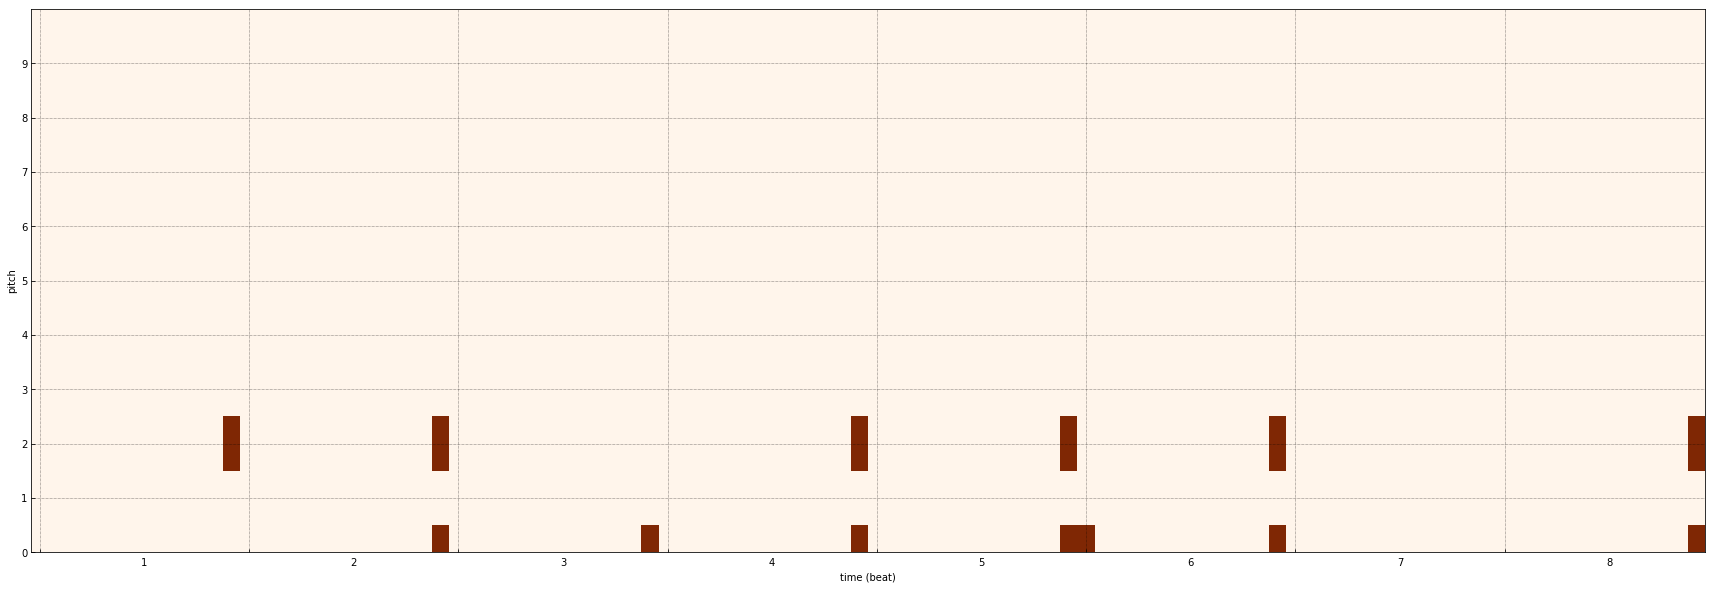

0.7614579 6.7043896e-13


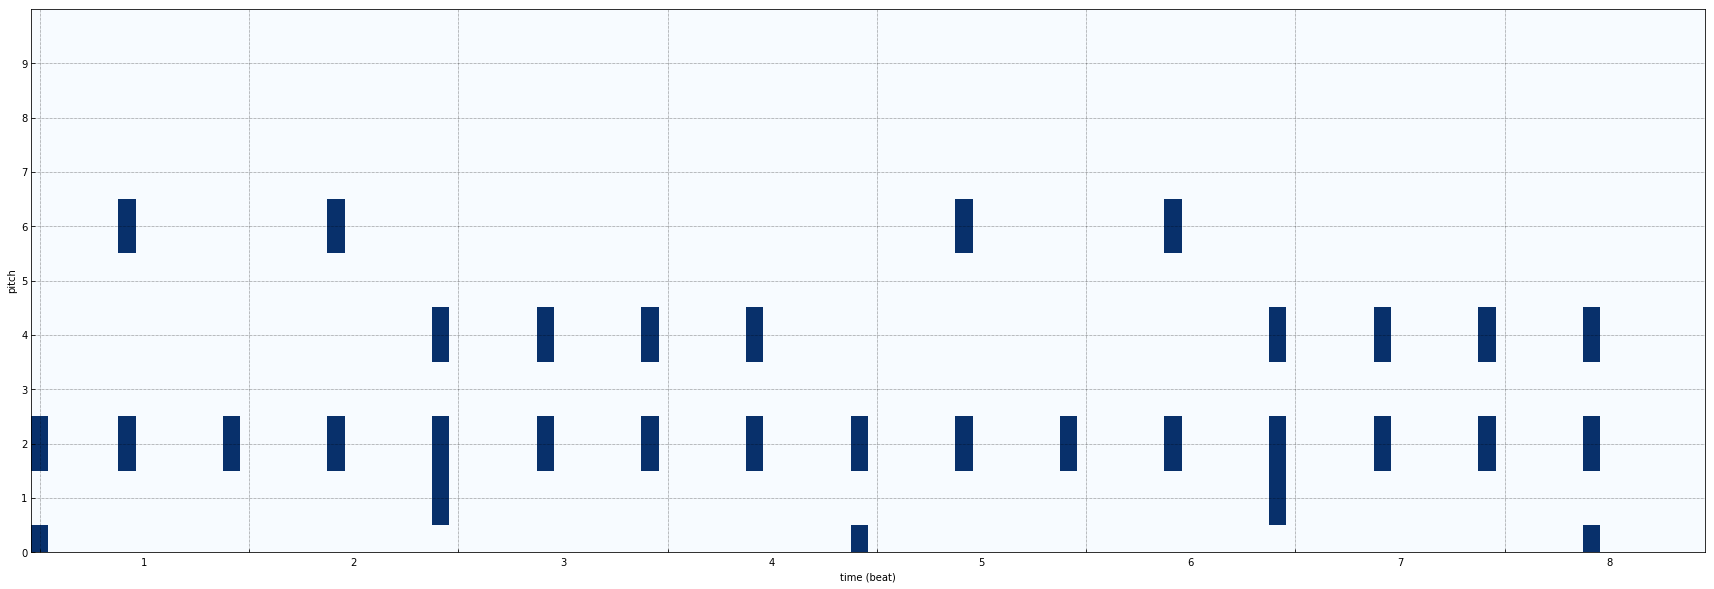

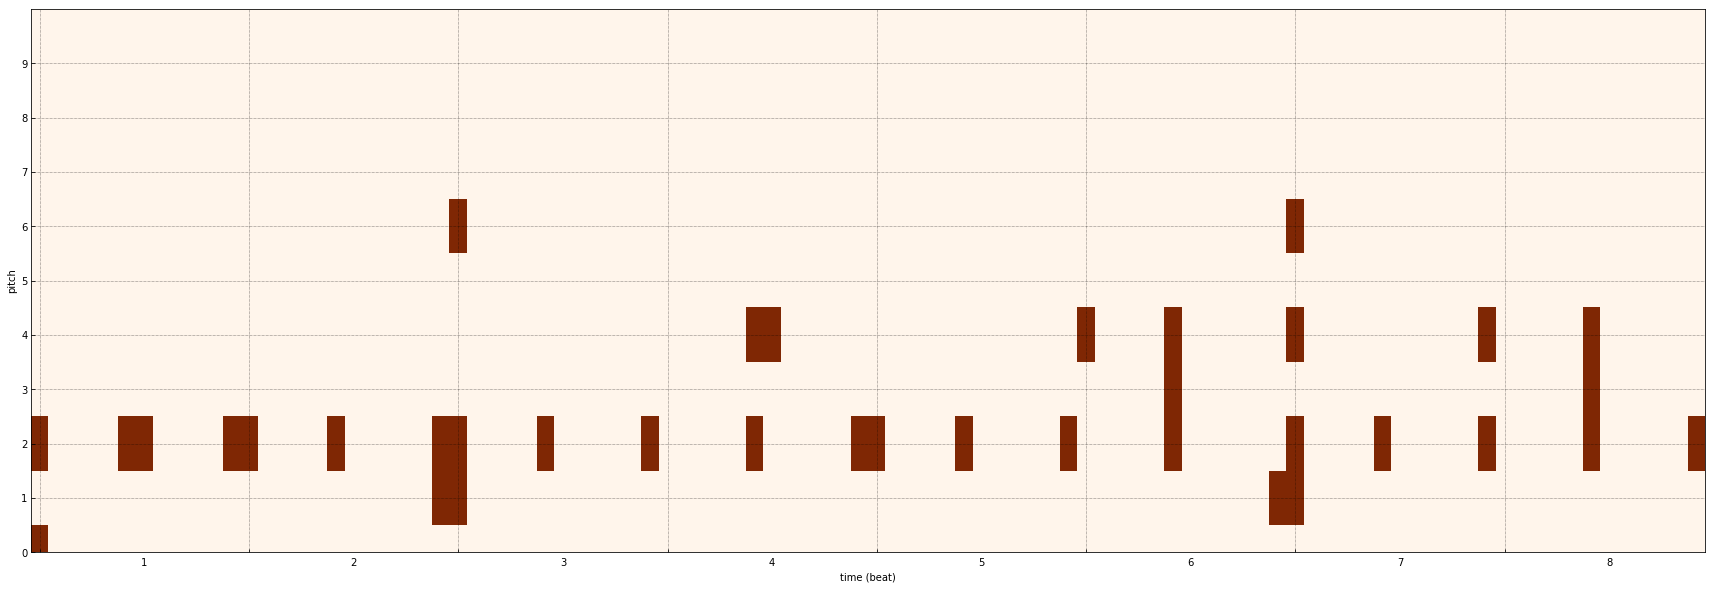

0.7615942 2.546248e-13


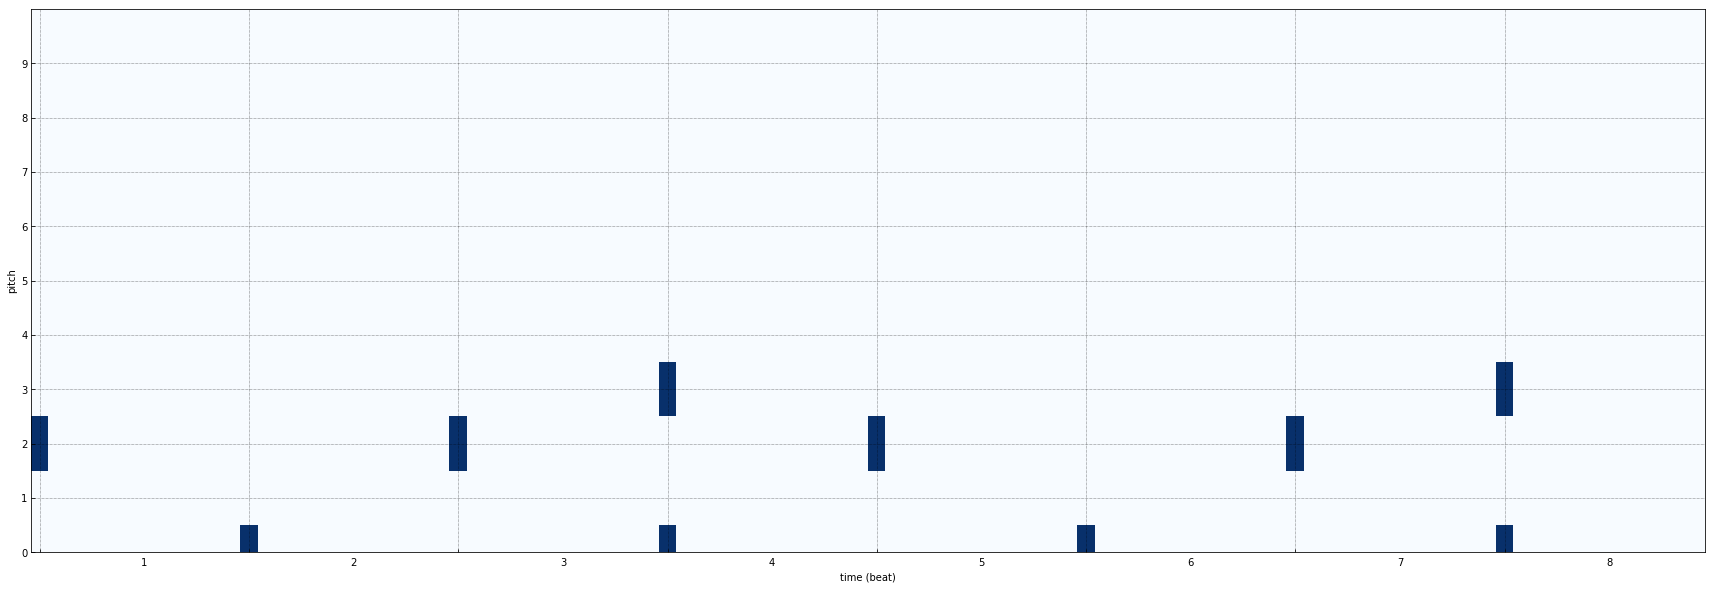

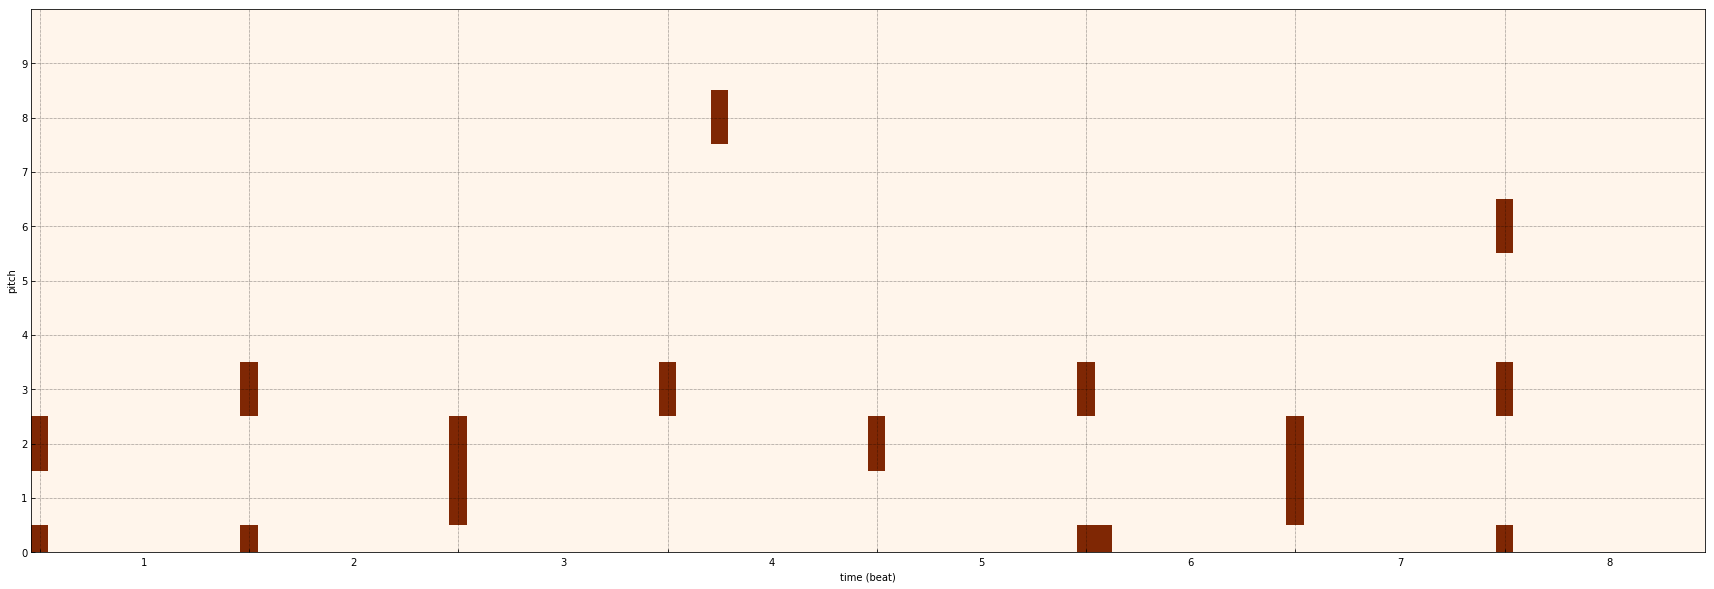

0.7605381 2.7653171e-10


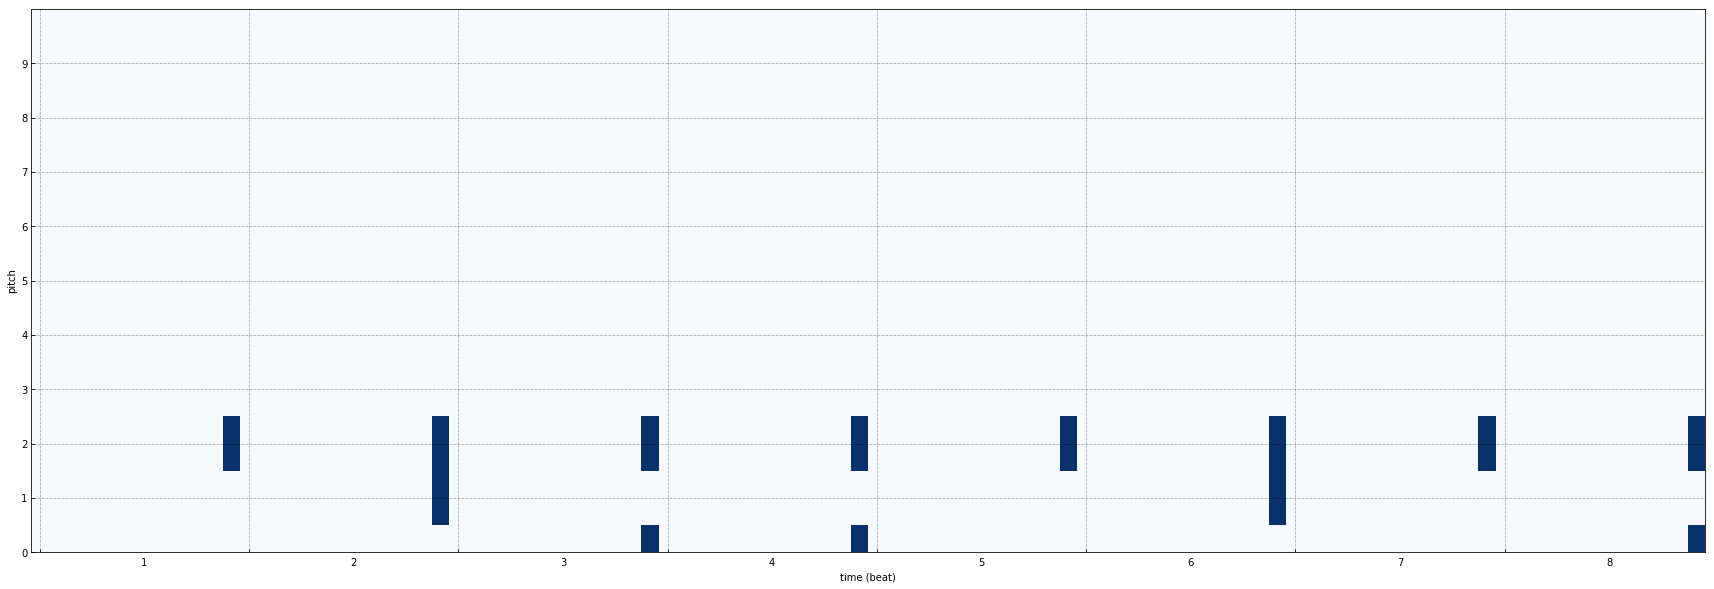

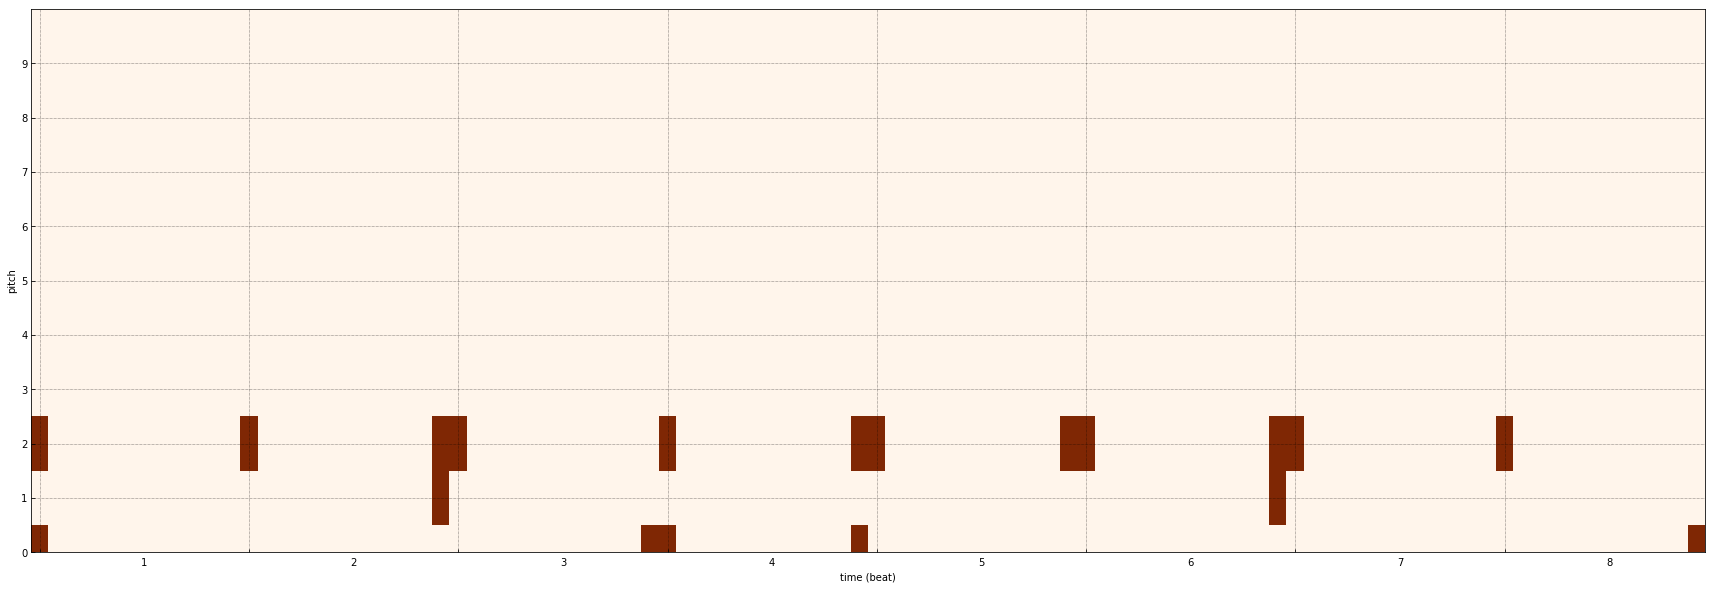

In [11]:
for batch_i, data in enumerate(test_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = Variable(data[0]).type(torch.float32).to(device)
        data_out = vae(data)
        
        
        for i in range(len(data)):
            if i < 20:
                data_i = data[i].cpu().data.numpy()
                data_o = data_out[i].cpu().data.numpy()
                print(data_o.max(), data_o.min())
                data_o = np.where(data_o > 0.2, 1, 0)
                pltReducedDrumTrack(data_i)
                pltReducedDrumTrack(data_o, cmap='Oranges')